In [ ]:
!pip install torch==1.13.1+cu117 torchvision==0.14.1+cu117 torchaudio==0.13.1 --extra-index-url https://download.pytorch.org/whl/cu117
!pip install simpletransformers


In [ ]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.current_device())
print(torch.cuda.device(0))

In [1]:
cd E:\TEST

E:\TEST


In [6]:
pwd


'D:\\Users\\hanklee\\專題'

In [3]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import pandas as pd
import logging
import time, pathlib, random
import torch
import os
import csv
from sklearn.metrics import f1_score, accuracy_score
import logging
from simpletransformers.classification import ClassificationModel
import sklearn
# def early_stopping_metric(eval_preds, eval_labels):
#     return f1_multiclass(eval_labels, eval_preds)
# def f1_multiclass(labels, preds): 
#     return f1_score(labels, preds, average='micro', zero_division=0)
def f1_multiclass(labels, preds): 
    return f1_score(labels, preds, average='weighted', zero_division=0)
def train():
    # 讀取資料後，開始訓練
    '''計時開始 - 訓練'''
    tStartTrain = time.time() 

    '''放置符合訓練格式的資料'''
    train_data = []

    '''讀取 AIdea 提供的訓練資料集'''
    train_aidea_csv = pd.read_csv('D:/Users/hanklee/專題/zzz.csv', escapechar='\\',header=None)


    '''資料轉換'''
    list_dataset_train_aidea = train_aidea_csv.values.tolist()
#     for dataset in list_dataset_train_aidea:
#         train_data.append([dataset[0], dataset[1]])
    train_data = [[dataset[0], dataset[1]] for dataset in list_dataset_train_aidea]
    
    # 切分資料
    '''隨機排序訓練資料'''
    random.shuffle(train_data) # 將訓練資料重新隨機排序
    middle = int(len(train_data) * 0.7) # 訓練資料的總數 (70%)
    list_train = train_data[:middle] # 透過 slicing 取得訓練資料 (70%)
    list_eval = train_data[middle:] # 透過 slicing 取得評估資料 (30%)





    # 模型手動設定
    '''pre-trained model、batch size 與 epoch'''
    model = 'bert'
    model_name_prefix = ''
    model_name_main = 'bert-base-uncased'
    model_name = model_name_prefix + model_name_main
    batch_size = 44
    epoch = 10

    '''output 資料夾'''
    output_dir = f"outputs/{model_name_main}-bs-{batch_size}-ep-{epoch}-cls-model/"

    '''自訂參數'''
    model_args = ClassificationArgs()
    model_args.train_batch_size = batch_size
    model_args.num_train_epochs = epoch
    model_args.overwrite_output_dir = True
    model_args.reprocess_input_data = True
    model_args.use_multiprocessing = True
    model_args.save_model_every_epoch = False # https://simpletransformers.ai/docs/tips-and-tricks/#dont-save-model-checkpoints
    model_args.save_steps = -1
    model_args.learning_rate = 4e-5
    model_args.output_dir = output_dir
    # model_args.f1_score = True

    ''' Early Stopping 設定'''
    # https://simpletransformers.ai/docs/tips-and-tricks/#using-early-stopping
    # https://www.voxco.com/blog/matthewss-correlation-coefficient-definition-formula-and-advantages/
    model_args.use_early_stopping = False
    model_args.early_stopping_metric = "f1_score" # Matthews's correlation coefficient
    model_args.early_stopping_delta = 0.01 # test data does not improve upon the best mcc score by at least 0.01
    model_args.early_stopping_patience = 5 # 5 consecutive evaluations
    # model_args.early_stopping_metric = early_stopping_metric
    
    

    '''如果 use_early_stopping 為 False 的話，evaluate_during_training 可以改成 True'''
    model_args.evaluate_during_training = True
    model_args.eval_batch_size = batch_size
    model_args.use_multiprocessing_for_evaluation = True

    '''每幾個 steps 執行一次 eval'''
    model_args.evaluate_during_training_steps = 2000 # An evaluation will occur once for every 2000 training steps.

    '''建立 ClassificationModel'''
    model = ClassificationModel(
        model, 
        model_name, 
        use_cuda=torch.cuda.is_available(), #torch.cuda.is_available()
        cuda_device=0, # 使用第 1 顆 GPU (Device ID: 0),
        num_labels=10,
        args=model_args
    )

    '''train_data 轉成 data frame 後，給序欄位名稱'''
    train_df = pd.DataFrame(list_train)
    train_df.columns = ["text", "labels"]

    '''eval_data 轉成 data frame 後，給序欄位名稱'''
    eval_df = pd.DataFrame(list_eval)
    eval_df.columns = ["text", "labels"]

    '''訓練model'''
    model.train_model(train_df,eval_df=eval_df, f1_score=f1_multiclass)

    '''計時結束 - 訓練'''
    tEndTrain = time.time()

    '''訓練執行的時間'''
    print("[Train] It took %f sec" % (tEndTrain - tStartTrain))





    # 評估
    '''計時開始 - 評估'''
    tStartEval = time.time() 

    '''評估模型'''
    result, model_outputs, wrong_predictions = model.eval_model(eval_df,  f1_score=f1_multiclass) 
    print(f"result: {result}, model_outputs: {model_outputs}, wrong_predictions: {wrong_predictions}")

    '''計時結束 - 評估'''
    tEndEval = time.time()

    '''評估執行的時間'''
    print("[Evaluation] It took %f sec" % (tEndEval - tStartEval))





    # 預測
    '''計時開始 - 預測'''
    tStartPredict = time.time() 

    '''預測結果'''
    predictions, raw_outputs = model.predict([
        "I watched this film because I'm a big fan of River Phoenix and Joaquin Phoenix. I thought I would give their sister a try, Rain Phoenix. I regret checking it out. She was embarrasing and the film just has this weird plot if thats what you want to call it. Sissy was just weird and Jellybean just sits on a toilet who both sleep with this old man in the mountains, whats going on? I have never been so unsatisfied in my life. It was just total rubbish. I can't believe that the actors agreed to do such a waste of film, money, time and space. Have Sissy being 'beautiful' didnt get to me. I thought she was everything but that. Those thumbs were just stupid, and why do we care if she can hitchhike? WHATS THE POINT??? 0 out of 10, shame the poll doesnt have a 0, doesnt even deserve a 1. Hopefully, Rain is better in other films, I forgive her for this one performance, I mean I wouldnt do much better with that film.",
        "It does not seem that this movie managed to please a lot of people. First off, not many seem to have seen it in the first place (I just bumped into it by accident), and then judging by the reviews and the rating, of those that did many did not enjoy it very much.<br /><br />Well, I did. I usually tolerate Gere for his looks and his charm, and even though I did not consider him a great actor, I know he can do crazy pretty well (I liked his Mr Jones). But this performance is all different. He is not pretty in this one, and he is not charming. His character is completely different from anything I had seen from him up to that point---old, ugly, broken, determined. And Gere, in what to me is so far his best performance ever, pulls it off beautifully. I guess it is a sign of how well an actor does his job if you cannot imagine anyone else doing it instead---think Hopkins as Hannibal Lecter, or Washington as Alonzo in Training Day. That is how good Gere was here.<br /><br />The rest of the cast were fine by me, too. I guess I would not have cast Danes in this role, mostly because I think she is too good-looking for it. But she actually does an excellent job, holding her own with a Gere in top form, which is no small feat. Strickland easily delivers the best supporting act, in a part that requires a considerable range from her. I actually think she owns the key scene with Gere and Danes, and that is quite an achievement.<br /><br />So what about the rest of the movie, apart from some excellent acting? The story is perhaps not hugely surprising, some 8mm-ish aspects to it, but adding the ""veteran breaks in rookie"" storyline to the who-dunnit, and also (like Silence of the Lambs) adding a sense of urgency through trying to save the girl and the impending retirement of Gere's character. All that is a backdrop to the development of the two main characters, as they help each other settle into their respective new stations in life. That's a lot to accomplish in a 100 minutes, but it is done well, and we end up caring for the characters and what happens to them.<br /><br />Direction and photography were adequate. I could have done without the modern music-video camera movements and cutting, but then I am an old curmudgeon, and it really wasn't all that bad, in fact I think it did help with the atmosphere of the movie, which as you might have guessed, by and large isn't a happy one.<br /><br />Worth seeing.",
        "      Enough is not a bad movie , just mediocre .",
        "my friend and i rented this one a few nights ago. and, i must say, this is the single best movie i have ever seen. i mean, woah! ""dude, we better get some brew before this joint closes"" and ""dude, linda's not wearin' a bra again."" what poetry! woah! and it's such a wonderfuly original movie, too. i mean, you don't usually find a slasher film where every single murder is exactly the same. i mean, exactly! now that's originality. and almost all the transitions between scenes are these great close-ups of the psycho in the ER scrubs. how cool! the acting is so wonderful to. the dad was just brilliant. must have studied REAL DADS before filming. and how many movies do you find that just don't make any sense? not many. but this is one of those gems. i mean, how cool is it that one guy waited outside for like six hours to pull a prank, while his friends were both inside? that's really cool. overall i'd say this is the single greatest film of the genre, nay, in the world! *****",
        "Just about everything in this movie is wrong, wrong, wrong. Take Mike Myers, for example. He's reached the point where you realize that his shtick hasn't changed since his SNL days, over ten years ago. He's doing the same cutesy stream-of-consciousness jokes and the same voices. His Cat is painfully unfunny. He tries way to hard. He's some weird Type A comedian, not the cool cat he's supposed to be. The rest of the movie is just as bad. The sets are unbelievably ugly --- and clearly a waste of millions of dollars. (Cardboard cut-outs for the background buildings would have made more sense than constructing an entire neighborhood and main street.) Alec Balwin tries to do a funny Great Santini impression, but he ends up looking and sounding incoherent. There's even an innapropriate cheesecake moment with faux celebrity Paris Hilton --- that sticks in the mind simply because this is supposed to be a Dr. Seuss story. Avoid this movie at all costs, folks. It's not even an interesting train wreck. (I hope they'll make Horton Hears a Who with Robin Williams. Then we'll have the bad-Seuss movie-starring-spasitc- comedian trilogy.)",
        "this isn't 'Bonnie and Clyde' or 'Thelma and Louise' but it is a fine road movie. it sets up its two main characters gently and easily. viewers learn the underlying tensions quickly, which is a tribute to the director. there is the young french (and English) speaking son who wants to do well in France, has a french girlfriend and who drinks alcohol, parties as young men do. And there is his moroccan arabic (and french) speaking father who devoutly follows his Muslim faith, with generosity and the wisdom of elders and who rejects the new culture surrounding him (like mobile phones). the film could explore very powerful politics - the odd couple drive thru the former Yugoslavia, thru Turkey and then thru the Middle East to get to Mecca. these are areas where the Muslim populations have been involved in wars, repression, ethnic cleansing; where dictators have pursued torture and summary executions to hold power and where religious communities are in constant deadly battle with each other. yet the film moves thru those places and possibilities with only hints of such agendas. the relationship between the two is key to this film, and faith, politics are the backdrop. it seems to be saying that we are all human, and need to understand and care for each other in order to manage well in this world. it certainly isn't 'Natural Born Killers' and is all the better for it.",
        "I have to say that I really liked UNDER SIEGE and HARD TO KILL.<br /><br />watching Seagal doing his funny martial arts on people. I have<br /><br />been always looking forward to Seagal-Movies and, unfortunately, I was first disappointed by GLIMMER MAN, which I found really bad. THE FOREIGNER is probably one of the worst Seagal has ever<br /><br />acted in. Horribly boring, badly edited, wrongest soundtrack and so on! Dear reader, do yourself a favor an stay away from this!<br /><br />Honestly: Stay away!",
        "Kramer Vs. Kramer is a near-heartening drama about shocking, drastic augmentations of the two subjects of a failed married couple. Meryl Streep, in the throes of her trademark maternal sensitivity, plays an unhappy stay-at-home mother who feels confined to such a role and within the first five minutes of the film leaves her inattentive husband, in a fantastic performance by Dustin Hoffman, to find another role for herself. Hoffman is dumbstruck, having absolutely no idea what to do with himself, having taken so much for granted that he doesn't know the first thing about getting his son to school in the morning.<br /><br />Hoffman seamlessly characterizes this husband as such a juicy load of setbacks. He is restless, relentless and impatient, but even though the positive side to those three adjectives should include just the opposite, he is unremittingly fixated on whatever he turns his head to. He's been focused on his career in advertising, and when he is left to raise his son Billy all by himself, chaos ushers in immediately. He's the one throwing temper tantrums and quitting angrily halfway through an activity. After awhile, as he befriends his neighbor and Joanna's former friend, played by sexy Jane Alexander, Hoffman cools his jets enough to understand why his wife left. In the meantime, his boundless energy redirects towards raising Billy and he loses his job.<br /><br />The custody battle of the title is a brilliantly grey circumstance. Even if the ending is a little unmotivated, subjectified for the audience, the last line and the last shot still have that witty screen writing touch that seemed to diminish after the magical 1970s.",
        "Like the other comments says, this might be surprise to those who haven't seen the work of Jeunet & Caro or Emir Kusturica. But have you already seen Delicatessen, there is nothing new it this film. I thought Delicatessen was great when it came out, but this film just arrive too late to be of any interest. I don't think it's a worse film than Delicatessen but it's a bore to see it now, like it probably would be to watch Delicatessen again. There is really no point to the film, nothing that really matter or stays with you. There may be a distant similarity to the films of Kusturica, but he's really in a different league, so you should rather go see his films than waste your time on Tuvalu.",
        "The tunes are the best aspect of this television film which has admittedly better-than-average production values, but very surface and slightly altered biography. Dramatizes Richard's discovery of ""We've Only Just Begun"" and Karen's marriage troubles admirably (the ""Superstar"" montage was a nice touch), yet notably leaves out the disagreement with Neil Sedaka, the contribution of Tony Peluso's guitar solos, etc. Gibb is sweet in her Karen persona, but it doesn't include the tomboyish and gutsier sides of the real Carpenter's personality. Anderson is in fine form as the creative and take-charge Richard, and Fletcher makes her mark as the loving but overbearing Agnes. The most haunting moment of the original broadcast is the use of ""Goodbye to Love"" in the background of a commercial displaying an anorexia hotline."
    ])

    print(f"預測結果: {predictions}")
    # 答案: label => [0,1,0,0,0, 1,0,1,0,1]

    '''計時結束 - 預測'''
    tEndPredict = time.time()

    '''預測執行的時間'''
    print("[Predict] It took %f sec" % (tEndPredict - tStartPredict))


if __name__ == "__main__":
    train()

D:\Users\hanklee\anaconda3\envs\sst\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from

Epochs 0/10. Running Loss:    2.3141:   1%| | 88/13025 [01:52<4:30:19,  1.25s/i
Epochs 0/10. Running Loss:    2.3141:   1%| | 89/13025 [01:53<4:30:07,  1.25s/i
Epochs 0/10. Running Loss:    2.3234:   1%| | 89/13025 [01:53<4:30:07,  1.25s/i
Epochs 0/10. Running Loss:    2.3234:   1%| | 90/13025 [01:54<4:29:59,  1.25s/i
Epochs 0/10. Running Loss:    2.3219:   1%| | 90/13025 [01:55<4:29:59,  1.25s/i
Epochs 0/10. Running Loss:    2.3219:   1%| | 91/13025 [01:55<4:29:29,  1.25s/i
Epochs 0/10. Running Loss:    2.2850:   1%| | 91/13025 [01:56<4:29:29,  1.25s/i
Epochs 0/10. Running Loss:    2.2850:   1%| | 92/13025 [01:57<4:29:55,  1.25s/i
Epochs 0/10. Running Loss:    2.2660:   1%| | 92/13025 [01:57<4:29:55,  1.25s/i
Epochs 0/10. Running Loss:    2.2660:   1%| | 93/13025 [01:58<4:30:33,  1.26s/i
Epochs 0/10. Running Loss:    2.2776:   1%| | 93/13025 [01:58<4:30:33,  1.26s/i
Epochs 0/10. Running Loss:    2.2776:   1%| | 94/13025 [01:59<4:30:18,  1.25s/i
Epochs 0/10. Running Loss:    2.3165:   

Epochs 0/10. Running Loss:    2.1939:   1%| | 186/13025 [03:56<4:27:50,  1.25s/
Epochs 0/10. Running Loss:    2.1939:   1%| | 187/13025 [03:56<4:27:28,  1.25s/
Epochs 0/10. Running Loss:    2.2395:   1%| | 187/13025 [03:57<4:27:28,  1.25s/
Epochs 0/10. Running Loss:    2.2395:   1%| | 188/13025 [03:58<4:27:49,  1.25s/
Epochs 0/10. Running Loss:    2.3162:   1%| | 188/13025 [03:58<4:27:49,  1.25s/
Epochs 0/10. Running Loss:    2.3162:   1%| | 189/13025 [03:59<4:28:16,  1.25s/
Epochs 0/10. Running Loss:    2.2617:   1%| | 189/13025 [03:59<4:28:16,  1.25s/
Epochs 0/10. Running Loss:    2.2617:   1%| | 190/13025 [04:00<4:28:00,  1.25s/
Epochs 0/10. Running Loss:    2.2264:   1%| | 190/13025 [04:01<4:28:00,  1.25s/
Epochs 0/10. Running Loss:    2.2264:   1%| | 191/13025 [04:01<4:28:00,  1.25s/
Epochs 0/10. Running Loss:    2.2279:   1%| | 191/13025 [04:02<4:28:00,  1.25s/
Epochs 0/10. Running Loss:    2.2279:   1%| | 192/13025 [04:03<4:28:16,  1.25s/
Epochs 0/10. Running Loss:    2.2644:   

Epochs 0/10. Running Loss:    2.2257:   2%| | 284/13025 [05:59<4:26:01,  1.25s/
Epochs 0/10. Running Loss:    2.2257:   2%| | 285/13025 [05:59<4:26:00,  1.25s/
Epochs 0/10. Running Loss:    2.2565:   2%| | 285/13025 [06:00<4:26:00,  1.25s/
Epochs 0/10. Running Loss:    2.2565:   2%| | 286/13025 [06:01<4:26:59,  1.26s/
Epochs 0/10. Running Loss:    2.1881:   2%| | 286/13025 [06:01<4:26:59,  1.26s/
Epochs 0/10. Running Loss:    2.1881:   2%| | 287/13025 [06:02<4:27:35,  1.26s/
Epochs 0/10. Running Loss:    2.1236:   2%| | 287/13025 [06:02<4:27:35,  1.26s/
Epochs 0/10. Running Loss:    2.1236:   2%| | 288/13025 [06:03<4:29:49,  1.27s/
Epochs 0/10. Running Loss:    2.2310:   2%| | 288/13025 [06:04<4:29:49,  1.27s/
Epochs 0/10. Running Loss:    2.2310:   2%| | 289/13025 [06:05<4:30:00,  1.27s/
Epochs 0/10. Running Loss:    2.2447:   2%| | 289/13025 [06:05<4:30:00,  1.27s/
Epochs 0/10. Running Loss:    2.2447:   2%| | 290/13025 [06:06<4:29:41,  1.27s/
Epochs 0/10. Running Loss:    2.3026:   

Epochs 0/10. Running Loss:    2.0552:   3%| | 382/13025 [08:02<4:30:01,  1.28s/
Epochs 0/10. Running Loss:    2.0552:   3%| | 383/13025 [08:03<4:29:38,  1.28s/
Epochs 0/10. Running Loss:    2.1335:   3%| | 383/13025 [08:03<4:29:38,  1.28s/
Epochs 0/10. Running Loss:    2.1335:   3%| | 384/13025 [08:04<4:30:03,  1.28s/
Epochs 0/10. Running Loss:    2.1861:   3%| | 384/13025 [08:05<4:30:03,  1.28s/
Epochs 0/10. Running Loss:    2.1861:   3%| | 385/13025 [08:06<4:31:06,  1.29s/
Epochs 0/10. Running Loss:    2.2396:   3%| | 385/13025 [08:06<4:31:06,  1.29s/
Epochs 0/10. Running Loss:    2.2396:   3%| | 386/13025 [08:07<4:30:06,  1.28s/
Epochs 0/10. Running Loss:    2.2612:   3%| | 386/13025 [08:07<4:30:06,  1.28s/
Epochs 0/10. Running Loss:    2.2612:   3%| | 387/13025 [08:08<4:29:40,  1.28s/
Epochs 0/10. Running Loss:    2.1603:   3%| | 387/13025 [08:09<4:29:40,  1.28s/
Epochs 0/10. Running Loss:    2.1603:   3%| | 388/13025 [08:09<4:30:01,  1.28s/
Epochs 0/10. Running Loss:    2.1552:   

Epochs 0/10. Running Loss:    2.1752:   4%| | 480/13025 [10:05<4:22:51,  1.26s/
Epochs 0/10. Running Loss:    2.1752:   4%| | 481/13025 [10:06<4:23:36,  1.26s/
Epochs 0/10. Running Loss:    2.0875:   4%| | 481/13025 [10:07<4:23:36,  1.26s/
Epochs 0/10. Running Loss:    2.0875:   4%| | 482/13025 [10:08<4:25:04,  1.27s/
Epochs 0/10. Running Loss:    2.0465:   4%| | 482/13025 [10:08<4:25:04,  1.27s/
Epochs 0/10. Running Loss:    2.0465:   4%| | 483/13025 [10:09<4:25:00,  1.27s/
Epochs 0/10. Running Loss:    2.1866:   4%| | 483/13025 [10:09<4:25:00,  1.27s/
Epochs 0/10. Running Loss:    2.1866:   4%| | 484/13025 [10:10<4:24:56,  1.27s/
Epochs 0/10. Running Loss:    2.3147:   4%| | 484/13025 [10:11<4:24:56,  1.27s/
Epochs 0/10. Running Loss:    2.3147:   4%| | 485/13025 [10:11<4:25:30,  1.27s/
Epochs 0/10. Running Loss:    2.2555:   4%| | 485/13025 [10:12<4:25:30,  1.27s/
Epochs 0/10. Running Loss:    2.2555:   4%| | 486/13025 [10:13<4:25:36,  1.27s/
Epochs 0/10. Running Loss:    2.1968:   

Epochs 0/10. Running Loss:    2.0823:   4%| | 578/13025 [12:09<4:20:18,  1.25s/
Epochs 0/10. Running Loss:    2.0823:   4%| | 579/13025 [12:09<4:20:02,  1.25s/
Epochs 0/10. Running Loss:    2.1873:   4%| | 579/13025 [12:10<4:20:02,  1.25s/
Epochs 0/10. Running Loss:    2.1873:   4%| | 580/13025 [12:11<4:19:40,  1.25s/
Epochs 0/10. Running Loss:    2.1519:   4%| | 580/13025 [12:11<4:19:40,  1.25s/
Epochs 0/10. Running Loss:    2.1519:   4%| | 581/13025 [12:12<4:20:04,  1.25s/
Epochs 0/10. Running Loss:    2.1848:   4%| | 581/13025 [12:12<4:20:04,  1.25s/
Epochs 0/10. Running Loss:    2.1848:   4%| | 582/13025 [12:13<4:19:41,  1.25s/
Epochs 0/10. Running Loss:    2.0190:   4%| | 582/13025 [12:14<4:19:41,  1.25s/
Epochs 0/10. Running Loss:    2.0190:   4%| | 583/13025 [12:14<4:20:12,  1.25s/
Epochs 0/10. Running Loss:    2.3429:   4%| | 583/13025 [12:15<4:20:12,  1.25s/
Epochs 0/10. Running Loss:    2.3429:   4%| | 584/13025 [12:16<4:20:10,  1.25s/
Epochs 0/10. Running Loss:    2.0822:   

Epochs 0/10. Running Loss:    2.0919:   5%| | 676/13025 [14:12<4:20:09,  1.26s/
Epochs 0/10. Running Loss:    2.0919:   5%| | 677/13025 [14:13<4:20:49,  1.27s/
Epochs 0/10. Running Loss:    2.0508:   5%| | 677/13025 [14:13<4:20:49,  1.27s/
Epochs 0/10. Running Loss:    2.0508:   5%| | 678/13025 [14:14<4:21:20,  1.27s/
Epochs 0/10. Running Loss:    2.0665:   5%| | 678/13025 [14:15<4:21:20,  1.27s/
Epochs 0/10. Running Loss:    2.0665:   5%| | 679/13025 [14:15<4:22:46,  1.28s/
Epochs 0/10. Running Loss:    1.9864:   5%| | 679/13025 [14:16<4:22:46,  1.28s/
Epochs 0/10. Running Loss:    1.9864:   5%| | 680/13025 [14:17<4:22:33,  1.28s/
Epochs 0/10. Running Loss:    2.0114:   5%| | 680/13025 [14:17<4:22:33,  1.28s/
Epochs 0/10. Running Loss:    2.0114:   5%| | 681/13025 [14:18<4:22:15,  1.27s/
Epochs 0/10. Running Loss:    2.0084:   5%| | 681/13025 [14:18<4:22:15,  1.27s/
Epochs 0/10. Running Loss:    2.0084:   5%| | 682/13025 [14:19<4:22:26,  1.28s/
Epochs 0/10. Running Loss:    2.0522:   

Epochs 0/10. Running Loss:    1.9548:   6%| | 774/13025 [16:15<4:15:53,  1.25s/
Epochs 0/10. Running Loss:    1.9548:   6%| | 775/13025 [16:16<4:16:01,  1.25s/
Epochs 0/10. Running Loss:    1.9543:   6%| | 775/13025 [16:17<4:16:01,  1.25s/
Epochs 0/10. Running Loss:    1.9543:   6%| | 776/13025 [16:17<4:16:03,  1.25s/
Epochs 0/10. Running Loss:    2.0253:   6%| | 776/13025 [16:18<4:16:03,  1.25s/
Epochs 0/10. Running Loss:    2.0253:   6%| | 777/13025 [16:19<4:15:23,  1.25s/
Epochs 0/10. Running Loss:    1.9424:   6%| | 777/13025 [16:19<4:15:23,  1.25s/
Epochs 0/10. Running Loss:    1.9424:   6%| | 778/13025 [16:20<4:14:47,  1.25s/
Epochs 0/10. Running Loss:    2.1335:   6%| | 778/13025 [16:20<4:14:47,  1.25s/
Epochs 0/10. Running Loss:    2.1335:   6%| | 779/13025 [16:21<4:15:23,  1.25s/
Epochs 0/10. Running Loss:    2.1234:   6%| | 779/13025 [16:22<4:15:23,  1.25s/
Epochs 0/10. Running Loss:    2.1234:   6%| | 780/13025 [16:22<4:15:08,  1.25s/
Epochs 0/10. Running Loss:    1.9354:   

Epochs 0/10. Running Loss:    1.7862:   7%| | 872/13025 [18:18<4:12:54,  1.25s/
Epochs 0/10. Running Loss:    1.7862:   7%| | 873/13025 [18:19<4:13:03,  1.25s/
Epochs 0/10. Running Loss:    1.9212:   7%| | 873/13025 [18:20<4:13:03,  1.25s/
Epochs 0/10. Running Loss:    1.9212:   7%| | 874/13025 [18:20<4:12:47,  1.25s/
Epochs 0/10. Running Loss:    1.8064:   7%| | 874/13025 [18:21<4:12:47,  1.25s/
Epochs 0/10. Running Loss:    1.8064:   7%| | 875/13025 [18:22<4:13:53,  1.25s/
Epochs 0/10. Running Loss:    1.8426:   7%| | 875/13025 [18:22<4:13:53,  1.25s/
Epochs 0/10. Running Loss:    1.8426:   7%| | 876/13025 [18:23<4:14:41,  1.26s/
Epochs 0/10. Running Loss:    1.8580:   7%| | 876/13025 [18:23<4:14:41,  1.26s/
Epochs 0/10. Running Loss:    1.8580:   7%| | 877/13025 [18:24<4:15:41,  1.26s/
Epochs 0/10. Running Loss:    1.8865:   7%| | 877/13025 [18:25<4:15:41,  1.26s/
Epochs 0/10. Running Loss:    1.8865:   7%| | 878/13025 [18:26<4:16:43,  1.27s/
Epochs 0/10. Running Loss:    1.8551:   

Epochs 0/10. Running Loss:    1.9054:   7%| | 970/13025 [20:22<4:10:52,  1.25s/
Epochs 0/10. Running Loss:    1.9054:   7%| | 971/13025 [20:22<4:10:45,  1.25s/
Epochs 0/10. Running Loss:    1.7938:   7%| | 971/13025 [20:23<4:10:45,  1.25s/
Epochs 0/10. Running Loss:    1.7938:   7%| | 972/13025 [20:24<4:11:00,  1.25s/
Epochs 0/10. Running Loss:    1.8652:   7%| | 972/13025 [20:24<4:11:00,  1.25s/
Epochs 0/10. Running Loss:    1.8652:   7%| | 973/13025 [20:25<4:12:38,  1.26s/
Epochs 0/10. Running Loss:    1.8517:   7%| | 973/13025 [20:25<4:12:38,  1.26s/
Epochs 0/10. Running Loss:    1.8517:   7%| | 974/13025 [20:26<4:13:07,  1.26s/
Epochs 0/10. Running Loss:    1.5823:   7%| | 974/13025 [20:27<4:13:07,  1.26s/
Epochs 0/10. Running Loss:    1.5823:   7%| | 975/13025 [20:27<4:13:05,  1.26s/
Epochs 0/10. Running Loss:    1.8104:   7%| | 975/13025 [20:28<4:13:05,  1.26s/
Epochs 0/10. Running Loss:    1.8104:   7%| | 976/13025 [20:29<4:12:37,  1.26s/
Epochs 0/10. Running Loss:    1.6870:   

Epochs 0/10. Running Loss:    1.8118:   8%| | 1068/13025 [22:30<4:25:23,  1.33s
Epochs 0/10. Running Loss:    1.8118:   8%| | 1069/13025 [22:31<4:25:45,  1.33s
Epochs 0/10. Running Loss:    1.7491:   8%| | 1069/13025 [22:31<4:25:45,  1.33s
Epochs 0/10. Running Loss:    1.7491:   8%| | 1070/13025 [22:32<4:25:40,  1.33s
Epochs 0/10. Running Loss:    1.7957:   8%| | 1070/13025 [22:32<4:25:40,  1.33s
Epochs 0/10. Running Loss:    1.7957:   8%| | 1071/13025 [22:33<4:25:28,  1.33s
Epochs 0/10. Running Loss:    1.8871:   8%| | 1071/13025 [22:34<4:25:28,  1.33s
Epochs 0/10. Running Loss:    1.8871:   8%| | 1072/13025 [22:35<4:25:21,  1.33s
Epochs 0/10. Running Loss:    1.8947:   8%| | 1072/13025 [22:35<4:25:21,  1.33s
Epochs 0/10. Running Loss:    1.8947:   8%| | 1073/13025 [22:36<4:27:31,  1.34s
Epochs 0/10. Running Loss:    1.8508:   8%| | 1073/13025 [22:36<4:27:31,  1.34s
Epochs 0/10. Running Loss:    1.8508:   8%| | 1074/13025 [22:37<4:27:05,  1.34s
Epochs 0/10. Running Loss:    1.7553:   

Epochs 0/10. Running Loss:    1.6946:   9%| | 1166/13025 [24:41<4:23:47,  1.33s
Epochs 0/10. Running Loss:    1.6946:   9%| | 1167/13025 [24:42<4:25:00,  1.34s
Epochs 0/10. Running Loss:    1.6549:   9%| | 1167/13025 [24:42<4:25:00,  1.34s
Epochs 0/10. Running Loss:    1.6549:   9%| | 1168/13025 [24:43<4:23:05,  1.33s
Epochs 0/10. Running Loss:    1.8194:   9%| | 1168/13025 [24:43<4:23:05,  1.33s
Epochs 0/10. Running Loss:    1.8194:   9%| | 1169/13025 [24:44<4:23:34,  1.33s
Epochs 0/10. Running Loss:    1.9406:   9%| | 1169/13025 [24:45<4:23:34,  1.33s
Epochs 0/10. Running Loss:    1.9406:   9%| | 1170/13025 [24:46<4:25:47,  1.35s
Epochs 0/10. Running Loss:    1.9903:   9%| | 1170/13025 [24:46<4:25:47,  1.35s
Epochs 0/10. Running Loss:    1.9903:   9%| | 1171/13025 [24:47<4:26:31,  1.35s
Epochs 0/10. Running Loss:    1.5498:   9%| | 1171/13025 [24:47<4:26:31,  1.35s
Epochs 0/10. Running Loss:    1.5498:   9%| | 1172/13025 [24:48<4:26:52,  1.35s
Epochs 0/10. Running Loss:    1.8764:   

Epochs 0/10. Running Loss:    1.7058:  10%| | 1264/13025 [26:52<4:21:52,  1.34s
Epochs 0/10. Running Loss:    1.7058:  10%| | 1265/13025 [26:53<4:21:34,  1.33s
Epochs 0/10. Running Loss:    1.8894:  10%| | 1265/13025 [26:53<4:21:34,  1.33s
Epochs 0/10. Running Loss:    1.8894:  10%| | 1266/13025 [26:54<4:21:37,  1.33s
Epochs 0/10. Running Loss:    1.7066:  10%| | 1266/13025 [26:54<4:21:37,  1.33s
Epochs 0/10. Running Loss:    1.7066:  10%| | 1267/13025 [26:55<4:21:33,  1.33s
Epochs 0/10. Running Loss:    1.9386:  10%| | 1267/13025 [26:56<4:21:33,  1.33s
Epochs 0/10. Running Loss:    1.9386:  10%| | 1268/13025 [26:57<4:22:57,  1.34s
Epochs 0/10. Running Loss:    1.8447:  10%| | 1268/13025 [26:57<4:22:57,  1.34s
Epochs 0/10. Running Loss:    1.8447:  10%| | 1269/13025 [26:58<4:22:07,  1.34s
Epochs 0/10. Running Loss:    1.5534:  10%| | 1269/13025 [26:58<4:22:07,  1.34s
Epochs 0/10. Running Loss:    1.5534:  10%| | 1270/13025 [26:59<4:22:29,  1.34s
Epochs 0/10. Running Loss:    1.7436:  1

Epochs 0/10. Running Loss:    1.8671:  10%| | 1362/13025 [29:03<4:19:06,  1.33s
Epochs 0/10. Running Loss:    1.8671:  10%| | 1363/13025 [29:04<4:18:58,  1.33s
Epochs 0/10. Running Loss:    1.7097:  10%| | 1363/13025 [29:04<4:18:58,  1.33s
Epochs 0/10. Running Loss:    1.7097:  10%| | 1364/13025 [29:05<4:19:30,  1.34s
Epochs 0/10. Running Loss:    1.7459:  10%| | 1364/13025 [29:05<4:19:30,  1.34s
Epochs 0/10. Running Loss:    1.7459:  10%| | 1365/13025 [29:06<4:19:23,  1.33s
Epochs 0/10. Running Loss:    1.7927:  10%| | 1365/13025 [29:07<4:19:23,  1.33s
Epochs 0/10. Running Loss:    1.7927:  10%| | 1366/13025 [29:08<4:19:09,  1.33s
Epochs 0/10. Running Loss:    1.8694:  10%| | 1366/13025 [29:08<4:19:09,  1.33s
Epochs 0/10. Running Loss:    1.8694:  10%| | 1367/13025 [29:09<4:19:29,  1.34s
Epochs 0/10. Running Loss:    1.9511:  10%| | 1367/13025 [29:09<4:19:29,  1.34s
Epochs 0/10. Running Loss:    1.9511:  11%| | 1368/13025 [29:10<4:18:42,  1.33s
Epochs 0/10. Running Loss:    1.8159:  1

Epochs 0/10. Running Loss:    1.8935:  11%| | 1460/13025 [31:10<3:59:39,  1.24s
Epochs 0/10. Running Loss:    1.8935:  11%| | 1461/13025 [31:11<3:59:54,  1.24s
Epochs 0/10. Running Loss:    1.8285:  11%| | 1461/13025 [31:11<3:59:54,  1.24s
Epochs 0/10. Running Loss:    1.8285:  11%| | 1462/13025 [31:12<4:00:34,  1.25s
Epochs 0/10. Running Loss:    1.5822:  11%| | 1462/13025 [31:12<4:00:34,  1.25s
Epochs 0/10. Running Loss:    1.5822:  11%| | 1463/13025 [31:13<4:01:24,  1.25s
Epochs 0/10. Running Loss:    1.8942:  11%| | 1463/13025 [31:14<4:01:24,  1.25s
Epochs 0/10. Running Loss:    1.8942:  11%| | 1464/13025 [31:14<4:01:44,  1.25s
Epochs 0/10. Running Loss:    1.7479:  11%| | 1464/13025 [31:15<4:01:44,  1.25s
Epochs 0/10. Running Loss:    1.7479:  11%| | 1465/13025 [31:16<4:02:27,  1.26s
Epochs 0/10. Running Loss:    1.8660:  11%| | 1465/13025 [31:16<4:02:27,  1.26s
Epochs 0/10. Running Loss:    1.8660:  11%| | 1466/13025 [31:17<4:03:16,  1.26s
Epochs 0/10. Running Loss:    1.8118:  1

Epochs 0/10. Running Loss:    1.9422:  12%| | 1558/13025 [33:12<3:57:03,  1.24s
Epochs 0/10. Running Loss:    1.9422:  12%| | 1559/13025 [33:13<3:56:56,  1.24s
Epochs 0/10. Running Loss:    1.7096:  12%| | 1559/13025 [33:13<3:56:56,  1.24s
Epochs 0/10. Running Loss:    1.7096:  12%| | 1560/13025 [33:14<3:56:59,  1.24s
Epochs 0/10. Running Loss:    1.6656:  12%| | 1560/13025 [33:14<3:56:59,  1.24s
Epochs 0/10. Running Loss:    1.6656:  12%| | 1561/13025 [33:15<3:57:10,  1.24s
Epochs 0/10. Running Loss:    1.7132:  12%| | 1561/13025 [33:16<3:57:10,  1.24s
Epochs 0/10. Running Loss:    1.7132:  12%| | 1562/13025 [33:16<3:57:24,  1.24s
Epochs 0/10. Running Loss:    1.6725:  12%| | 1562/13025 [33:17<3:57:24,  1.24s
Epochs 0/10. Running Loss:    1.6725:  12%| | 1563/13025 [33:18<3:57:27,  1.24s
Epochs 0/10. Running Loss:    1.8073:  12%| | 1563/13025 [33:18<3:57:27,  1.24s
Epochs 0/10. Running Loss:    1.8073:  12%| | 1564/13025 [33:19<3:57:06,  1.24s
Epochs 0/10. Running Loss:    1.7110:  1

Epochs 0/10. Running Loss:    1.9678:  13%|▏| 1656/13025 [35:14<3:59:35,  1.26s
Epochs 0/10. Running Loss:    1.9678:  13%|▏| 1657/13025 [35:15<3:59:52,  1.27s
Epochs 0/10. Running Loss:    1.8037:  13%|▏| 1657/13025 [35:15<3:59:52,  1.27s
Epochs 0/10. Running Loss:    1.8037:  13%|▏| 1658/13025 [35:16<3:59:47,  1.27s
Epochs 0/10. Running Loss:    1.8483:  13%|▏| 1658/13025 [35:16<3:59:47,  1.27s
Epochs 0/10. Running Loss:    1.8483:  13%|▏| 1659/13025 [35:17<3:59:27,  1.26s
Epochs 0/10. Running Loss:    1.7615:  13%|▏| 1659/13025 [35:18<3:59:27,  1.26s
Epochs 0/10. Running Loss:    1.7615:  13%|▏| 1660/13025 [35:18<4:00:02,  1.27s
Epochs 0/10. Running Loss:    1.9433:  13%|▏| 1660/13025 [35:19<4:00:02,  1.27s
Epochs 0/10. Running Loss:    1.9433:  13%|▏| 1661/13025 [35:20<3:59:38,  1.27s
Epochs 0/10. Running Loss:    1.7622:  13%|▏| 1661/13025 [35:20<3:59:38,  1.27s
Epochs 0/10. Running Loss:    1.7622:  13%|▏| 1662/13025 [35:21<4:00:17,  1.27s
Epochs 0/10. Running Loss:    1.8719:  1

Epochs 0/10. Running Loss:    1.9286:  13%|▏| 1754/13025 [37:16<3:53:58,  1.25s
Epochs 0/10. Running Loss:    1.9286:  13%|▏| 1755/13025 [37:17<3:53:26,  1.24s
Epochs 0/10. Running Loss:    1.8034:  13%|▏| 1755/13025 [37:17<3:53:26,  1.24s
Epochs 0/10. Running Loss:    1.8034:  13%|▏| 1756/13025 [37:18<3:53:55,  1.25s
Epochs 0/10. Running Loss:    1.7242:  13%|▏| 1756/13025 [37:19<3:53:55,  1.25s
Epochs 0/10. Running Loss:    1.7242:  13%|▏| 1757/13025 [37:19<3:53:16,  1.24s
Epochs 0/10. Running Loss:    1.6664:  13%|▏| 1757/13025 [37:20<3:53:16,  1.24s
Epochs 0/10. Running Loss:    1.6664:  13%|▏| 1758/13025 [37:21<3:53:17,  1.24s
Epochs 0/10. Running Loss:    1.8714:  13%|▏| 1758/13025 [37:21<3:53:17,  1.24s
Epochs 0/10. Running Loss:    1.8714:  14%|▏| 1759/13025 [37:22<3:53:32,  1.24s
Epochs 0/10. Running Loss:    1.7941:  14%|▏| 1759/13025 [37:22<3:53:32,  1.24s
Epochs 0/10. Running Loss:    1.7941:  14%|▏| 1760/13025 [37:23<3:53:14,  1.24s
Epochs 0/10. Running Loss:    1.9340:  1

Epochs 0/10. Running Loss:    1.6270:  14%|▏| 1852/13025 [39:18<3:53:29,  1.25s
Epochs 0/10. Running Loss:    1.6270:  14%|▏| 1853/13025 [39:19<3:53:32,  1.25s
Epochs 0/10. Running Loss:    1.5478:  14%|▏| 1853/13025 [39:19<3:53:32,  1.25s
Epochs 0/10. Running Loss:    1.5478:  14%|▏| 1854/13025 [39:20<3:54:43,  1.26s
Epochs 0/10. Running Loss:    1.9372:  14%|▏| 1854/13025 [39:21<3:54:43,  1.26s
Epochs 0/10. Running Loss:    1.9372:  14%|▏| 1855/13025 [39:21<3:54:32,  1.26s
Epochs 0/10. Running Loss:    1.7968:  14%|▏| 1855/13025 [39:22<3:54:32,  1.26s
Epochs 0/10. Running Loss:    1.7968:  14%|▏| 1856/13025 [39:23<3:54:27,  1.26s
Epochs 0/10. Running Loss:    1.7344:  14%|▏| 1856/13025 [39:23<3:54:27,  1.26s
Epochs 0/10. Running Loss:    1.7344:  14%|▏| 1857/13025 [39:24<3:53:55,  1.26s
Epochs 0/10. Running Loss:    1.6348:  14%|▏| 1857/13025 [39:24<3:53:55,  1.26s
Epochs 0/10. Running Loss:    1.6348:  14%|▏| 1858/13025 [39:25<3:53:36,  1.26s
Epochs 0/10. Running Loss:    1.9271:  1

Epochs 0/10. Running Loss:    1.7043:  15%|▏| 1950/13025 [41:20<3:48:34,  1.24s
Epochs 0/10. Running Loss:    1.7043:  15%|▏| 1951/13025 [41:21<3:49:13,  1.24s
Epochs 0/10. Running Loss:    1.9659:  15%|▏| 1951/13025 [41:22<3:49:13,  1.24s
Epochs 0/10. Running Loss:    1.9659:  15%|▏| 1952/13025 [41:23<3:49:30,  1.24s
Epochs 0/10. Running Loss:    1.6495:  15%|▏| 1952/13025 [41:23<3:49:30,  1.24s
Epochs 0/10. Running Loss:    1.6495:  15%|▏| 1953/13025 [41:24<3:49:47,  1.25s
Epochs 0/10. Running Loss:    1.7193:  15%|▏| 1953/13025 [41:24<3:49:47,  1.25s
Epochs 0/10. Running Loss:    1.7193:  15%|▏| 1954/13025 [41:25<3:49:08,  1.24s
Epochs 0/10. Running Loss:    1.6595:  15%|▏| 1954/13025 [41:25<3:49:08,  1.24s
Epochs 0/10. Running Loss:    1.6595:  15%|▏| 1955/13025 [41:26<3:49:31,  1.24s
Epochs 0/10. Running Loss:    1.6871:  15%|▏| 1955/13025 [41:27<3:49:31,  1.24s
Epochs 0/10. Running Loss:    1.6871:  15%|▏| 1956/13025 [41:27<3:49:09,  1.24s
Epochs 0/10. Running Loss:    1.8015:  1

  0%|                                   | 149/245600 [00:34<8:38:04,  7.90it/s]

  0%|                                   | 150/245600 [00:34<9:15:17,  7.37it/s]

  0%|                                   | 151/245600 [00:34<9:45:41,  6.98it/s]

  0%|                                  | 152/245600 [00:34<14:47:29,  4.61it/s]

  0%|                                  | 153/245600 [00:35<14:00:08,  4.87it/s]

  0%|                                  | 154/245600 [00:35<16:23:53,  4.16it/s]

  0%|                                   | 158/245600 [00:35<8:37:29,  7.90it/s]

  0%|                                   | 160/245600 [00:35<9:27:24,  7.21it/s]

  0%|                                   | 161/245600 [00:36<9:53:52,  6.89it/s]

  0%|                                  | 162/245600 [00:36<10:33:15,  6.46it/s]

  0%|                                  | 163/245600 [00:36<16:12:56,  4.20it/s]

  0%|                                  | 164/245600 [00:37<14:51:48,  4.59it/s]

  0%|                       

Epochs 0/10. Running Loss:    1.7293:  15%|▏| 2016/13025 [1:22:12<11:03:27,  3.
Epochs 0/10. Running Loss:    1.7293:  15%|▏| 2017/13025 [1:22:13<8:53:47,  2.9
Epochs 0/10. Running Loss:    1.6093:  15%|▏| 2017/13025 [1:22:14<8:53:47,  2.9
Epochs 0/10. Running Loss:    1.6093:  15%|▏| 2018/13025 [1:22:14<7:23:19,  2.4
Epochs 0/10. Running Loss:    1.8205:  15%|▏| 2018/13025 [1:22:15<7:23:19,  2.4
Epochs 0/10. Running Loss:    1.8205:  16%|▏| 2019/13025 [1:22:16<6:19:20,  2.0
Epochs 0/10. Running Loss:    1.7992:  16%|▏| 2019/13025 [1:22:16<6:19:20,  2.0
Epochs 0/10. Running Loss:    1.7992:  16%|▏| 2020/13025 [1:22:17<5:34:27,  1.8
Epochs 0/10. Running Loss:    2.1757:  16%|▏| 2020/13025 [1:22:17<5:34:27,  1.8
Epochs 0/10. Running Loss:    2.1757:  16%|▏| 2021/13025 [1:22:18<5:04:00,  1.6
Epochs 0/10. Running Loss:    1.7692:  16%|▏| 2021/13025 [1:22:19<5:04:00,  1.6
Epochs 0/10. Running Loss:    1.7692:  16%|▏| 2022/13025 [1:22:19<4:42:58,  1.5
Epochs 0/10. Running Loss:    1.6272:  1

Epochs 0/10. Running Loss:    1.8487:  16%|▏| 2114/13025 [1:24:15<3:46:58,  1.2
Epochs 0/10. Running Loss:    1.8487:  16%|▏| 2115/13025 [1:24:16<3:46:52,  1.2
Epochs 0/10. Running Loss:    1.7978:  16%|▏| 2115/13025 [1:24:16<3:46:52,  1.2
Epochs 0/10. Running Loss:    1.7978:  16%|▏| 2116/13025 [1:24:17<3:46:22,  1.2
Epochs 0/10. Running Loss:    1.7355:  16%|▏| 2116/13025 [1:24:18<3:46:22,  1.2
Epochs 0/10. Running Loss:    1.7355:  16%|▏| 2117/13025 [1:24:18<3:45:50,  1.2
Epochs 0/10. Running Loss:    1.9403:  16%|▏| 2117/13025 [1:24:19<3:45:50,  1.2
Epochs 0/10. Running Loss:    1.9403:  16%|▏| 2118/13025 [1:24:20<3:46:13,  1.2
Epochs 0/10. Running Loss:    1.8856:  16%|▏| 2118/13025 [1:24:20<3:46:13,  1.2
Epochs 0/10. Running Loss:    1.8856:  16%|▏| 2119/13025 [1:24:21<3:45:12,  1.2
Epochs 0/10. Running Loss:    2.0303:  16%|▏| 2119/13025 [1:24:21<3:45:12,  1.2
Epochs 0/10. Running Loss:    2.0303:  16%|▏| 2120/13025 [1:24:22<3:45:27,  1.2
Epochs 0/10. Running Loss:    1.7140:  1

Epochs 0/10. Running Loss:    1.6734:  17%|▏| 2212/13025 [1:26:18<3:45:02,  1.2
Epochs 0/10. Running Loss:    1.6734:  17%|▏| 2213/13025 [1:26:19<3:44:21,  1.2
Epochs 0/10. Running Loss:    1.8975:  17%|▏| 2213/13025 [1:26:19<3:44:21,  1.2
Epochs 0/10. Running Loss:    1.8975:  17%|▏| 2214/13025 [1:26:20<3:44:32,  1.2
Epochs 0/10. Running Loss:    1.7595:  17%|▏| 2214/13025 [1:26:20<3:44:32,  1.2
Epochs 0/10. Running Loss:    1.7595:  17%|▏| 2215/13025 [1:26:21<3:43:50,  1.2
Epochs 0/10. Running Loss:    1.8490:  17%|▏| 2215/13025 [1:26:22<3:43:50,  1.2
Epochs 0/10. Running Loss:    1.8490:  17%|▏| 2216/13025 [1:26:22<3:43:53,  1.2
Epochs 0/10. Running Loss:    1.6722:  17%|▏| 2216/13025 [1:26:23<3:43:53,  1.2
Epochs 0/10. Running Loss:    1.6722:  17%|▏| 2217/13025 [1:26:24<3:44:16,  1.2
Epochs 0/10. Running Loss:    1.7742:  17%|▏| 2217/13025 [1:26:24<3:44:16,  1.2
Epochs 0/10. Running Loss:    1.7742:  17%|▏| 2218/13025 [1:26:25<3:44:31,  1.2
Epochs 0/10. Running Loss:    1.3732:  1

Epochs 0/10. Running Loss:    1.8405:  18%|▏| 2310/13025 [1:28:20<3:42:14,  1.2
Epochs 0/10. Running Loss:    1.8405:  18%|▏| 2311/13025 [1:28:21<3:42:27,  1.2
Epochs 0/10. Running Loss:    1.6951:  18%|▏| 2311/13025 [1:28:21<3:42:27,  1.2
Epochs 0/10. Running Loss:    1.6951:  18%|▏| 2312/13025 [1:28:22<3:42:27,  1.2
Epochs 0/10. Running Loss:    1.4545:  18%|▏| 2312/13025 [1:28:23<3:42:27,  1.2
Epochs 0/10. Running Loss:    1.4545:  18%|▏| 2313/13025 [1:28:23<3:42:04,  1.2
Epochs 0/10. Running Loss:    1.6647:  18%|▏| 2313/13025 [1:28:24<3:42:04,  1.2
Epochs 0/10. Running Loss:    1.6647:  18%|▏| 2314/13025 [1:28:25<3:41:56,  1.2
Epochs 0/10. Running Loss:    1.6328:  18%|▏| 2314/13025 [1:28:25<3:41:56,  1.2
Epochs 0/10. Running Loss:    1.6328:  18%|▏| 2315/13025 [1:28:26<3:41:54,  1.2
Epochs 0/10. Running Loss:    1.8663:  18%|▏| 2315/13025 [1:28:26<3:41:54,  1.2
Epochs 0/10. Running Loss:    1.8663:  18%|▏| 2316/13025 [1:28:27<3:41:58,  1.2
Epochs 0/10. Running Loss:    1.8053:  1

Epochs 0/10. Running Loss:    1.6464:  18%|▏| 2408/13025 [1:30:22<3:39:38,  1.2
Epochs 0/10. Running Loss:    1.6464:  18%|▏| 2409/13025 [1:30:23<3:40:00,  1.2
Epochs 0/10. Running Loss:    1.7002:  18%|▏| 2409/13025 [1:30:23<3:40:00,  1.2
Epochs 0/10. Running Loss:    1.7002:  19%|▏| 2410/13025 [1:30:24<3:39:50,  1.2
Epochs 0/10. Running Loss:    1.8271:  19%|▏| 2410/13025 [1:30:24<3:39:50,  1.2
Epochs 0/10. Running Loss:    1.8271:  19%|▏| 2411/13025 [1:30:25<3:39:37,  1.2
Epochs 0/10. Running Loss:    1.7787:  19%|▏| 2411/13025 [1:30:26<3:39:37,  1.2
Epochs 0/10. Running Loss:    1.7787:  19%|▏| 2412/13025 [1:30:26<3:38:54,  1.2
Epochs 0/10. Running Loss:    1.5344:  19%|▏| 2412/13025 [1:30:27<3:38:54,  1.2
Epochs 0/10. Running Loss:    1.5344:  19%|▏| 2413/13025 [1:30:28<3:39:22,  1.2
Epochs 0/10. Running Loss:    1.7854:  19%|▏| 2413/13025 [1:30:28<3:39:22,  1.2
Epochs 0/10. Running Loss:    1.7854:  19%|▏| 2414/13025 [1:30:29<3:39:30,  1.2
Epochs 0/10. Running Loss:    1.7671:  1

Epochs 0/10. Running Loss:    1.5469:  19%|▏| 2506/13025 [1:32:24<3:42:27,  1.2
Epochs 0/10. Running Loss:    1.5469:  19%|▏| 2507/13025 [1:32:25<3:42:05,  1.2
Epochs 0/10. Running Loss:    1.8671:  19%|▏| 2507/13025 [1:32:25<3:42:05,  1.2
Epochs 0/10. Running Loss:    1.8671:  19%|▏| 2508/13025 [1:32:26<3:42:18,  1.2
Epochs 0/10. Running Loss:    1.9256:  19%|▏| 2508/13025 [1:32:27<3:42:18,  1.2
Epochs 0/10. Running Loss:    1.9256:  19%|▏| 2509/13025 [1:32:28<3:42:52,  1.2
Epochs 0/10. Running Loss:    1.5986:  19%|▏| 2509/13025 [1:32:28<3:42:52,  1.2
Epochs 0/10. Running Loss:    1.5986:  19%|▏| 2510/13025 [1:32:29<3:42:24,  1.2
Epochs 0/10. Running Loss:    1.5407:  19%|▏| 2510/13025 [1:32:29<3:42:24,  1.2
Epochs 0/10. Running Loss:    1.5407:  19%|▏| 2511/13025 [1:32:30<3:41:45,  1.2
Epochs 0/10. Running Loss:    1.6376:  19%|▏| 2511/13025 [1:32:31<3:41:45,  1.2
Epochs 0/10. Running Loss:    1.6376:  19%|▏| 2512/13025 [1:32:31<3:41:43,  1.2
Epochs 0/10. Running Loss:    1.8483:  1

Epochs 0/10. Running Loss:    1.9213:  20%|▏| 2604/13025 [1:34:27<3:35:17,  1.2
Epochs 0/10. Running Loss:    1.9213:  20%|▏| 2605/13025 [1:34:28<3:35:52,  1.2
Epochs 0/10. Running Loss:    1.5912:  20%|▏| 2605/13025 [1:34:28<3:35:52,  1.2
Epochs 0/10. Running Loss:    1.5912:  20%|▏| 2606/13025 [1:34:29<3:36:19,  1.2
Epochs 0/10. Running Loss:    1.7236:  20%|▏| 2606/13025 [1:34:29<3:36:19,  1.2
Epochs 0/10. Running Loss:    1.7236:  20%|▏| 2607/13025 [1:34:30<3:36:21,  1.2
Epochs 0/10. Running Loss:    1.6336:  20%|▏| 2607/13025 [1:34:31<3:36:21,  1.2
Epochs 0/10. Running Loss:    1.6336:  20%|▏| 2608/13025 [1:34:31<3:35:43,  1.2
Epochs 0/10. Running Loss:    1.7612:  20%|▏| 2608/13025 [1:34:32<3:35:43,  1.2
Epochs 0/10. Running Loss:    1.7612:  20%|▏| 2609/13025 [1:34:33<3:35:43,  1.2
Epochs 0/10. Running Loss:    1.9313:  20%|▏| 2609/13025 [1:34:33<3:35:43,  1.2
Epochs 0/10. Running Loss:    1.9313:  20%|▏| 2610/13025 [1:34:34<3:35:21,  1.2
Epochs 0/10. Running Loss:    1.8119:  2

Epochs 0/10. Running Loss:    1.9417:  21%|▏| 2702/13025 [1:36:37<3:52:17,  1.3
Epochs 0/10. Running Loss:    1.9417:  21%|▏| 2703/13025 [1:36:38<3:52:55,  1.3
Epochs 0/10. Running Loss:    1.6370:  21%|▏| 2703/13025 [1:36:38<3:52:55,  1.3
Epochs 0/10. Running Loss:    1.6370:  21%|▏| 2704/13025 [1:36:39<3:51:47,  1.3
Epochs 0/10. Running Loss:    1.7565:  21%|▏| 2704/13025 [1:36:39<3:51:47,  1.3
Epochs 0/10. Running Loss:    1.7565:  21%|▏| 2705/13025 [1:36:40<3:49:54,  1.3
Epochs 0/10. Running Loss:    1.7590:  21%|▏| 2705/13025 [1:36:41<3:49:54,  1.3
Epochs 0/10. Running Loss:    1.7590:  21%|▏| 2706/13025 [1:36:42<3:50:48,  1.3
Epochs 0/10. Running Loss:    1.7532:  21%|▏| 2706/13025 [1:36:42<3:50:48,  1.3
Epochs 0/10. Running Loss:    1.7532:  21%|▏| 2707/13025 [1:36:43<3:50:07,  1.3
Epochs 0/10. Running Loss:    1.6684:  21%|▏| 2707/13025 [1:36:44<3:50:07,  1.3
Epochs 0/10. Running Loss:    1.6684:  21%|▏| 2708/13025 [1:36:44<3:50:08,  1.3
Epochs 0/10. Running Loss:    1.8780:  2

Epochs 0/10. Running Loss:    1.8824:  21%|▏| 2800/13025 [1:38:48<3:47:23,  1.3
Epochs 0/10. Running Loss:    1.8824:  22%|▏| 2801/13025 [1:38:48<3:46:49,  1.3
Epochs 0/10. Running Loss:    1.8292:  22%|▏| 2801/13025 [1:38:49<3:46:49,  1.3
Epochs 0/10. Running Loss:    1.8292:  22%|▏| 2802/13025 [1:38:50<3:46:45,  1.3
Epochs 0/10. Running Loss:    1.8306:  22%|▏| 2802/13025 [1:38:50<3:46:45,  1.3
Epochs 0/10. Running Loss:    1.8306:  22%|▏| 2803/13025 [1:38:51<3:47:01,  1.3
Epochs 0/10. Running Loss:    1.6828:  22%|▏| 2803/13025 [1:38:52<3:47:01,  1.3
Epochs 0/10. Running Loss:    1.6828:  22%|▏| 2804/13025 [1:38:52<3:47:27,  1.3
Epochs 0/10. Running Loss:    1.6797:  22%|▏| 2804/13025 [1:38:53<3:47:27,  1.3
Epochs 0/10. Running Loss:    1.6797:  22%|▏| 2805/13025 [1:38:54<3:48:20,  1.3
Epochs 0/10. Running Loss:    1.8397:  22%|▏| 2805/13025 [1:38:54<3:48:20,  1.3
Epochs 0/10. Running Loss:    1.8397:  22%|▏| 2806/13025 [1:38:55<3:46:51,  1.3
Epochs 0/10. Running Loss:    1.9121:  2

Epochs 0/10. Running Loss:    1.8230:  22%|▏| 2898/13025 [1:40:59<3:45:16,  1.3
Epochs 0/10. Running Loss:    1.8230:  22%|▏| 2899/13025 [1:40:59<3:44:54,  1.3
Epochs 0/10. Running Loss:    1.5755:  22%|▏| 2899/13025 [1:41:00<3:44:54,  1.3
Epochs 0/10. Running Loss:    1.5755:  22%|▏| 2900/13025 [1:41:01<3:45:08,  1.3
Epochs 0/10. Running Loss:    1.6541:  22%|▏| 2900/13025 [1:41:01<3:45:08,  1.3
Epochs 0/10. Running Loss:    1.6541:  22%|▏| 2901/13025 [1:41:02<3:44:59,  1.3
Epochs 0/10. Running Loss:    1.6811:  22%|▏| 2901/13025 [1:41:03<3:44:59,  1.3
Epochs 0/10. Running Loss:    1.6811:  22%|▏| 2902/13025 [1:41:03<3:44:54,  1.3
Epochs 0/10. Running Loss:    1.5256:  22%|▏| 2902/13025 [1:41:04<3:44:54,  1.3
Epochs 0/10. Running Loss:    1.5256:  22%|▏| 2903/13025 [1:41:05<3:44:48,  1.3
Epochs 0/10. Running Loss:    1.7495:  22%|▏| 2903/13025 [1:41:05<3:44:48,  1.3
Epochs 0/10. Running Loss:    1.7495:  22%|▏| 2904/13025 [1:41:06<3:44:51,  1.3
Epochs 0/10. Running Loss:    1.7247:  2

Epochs 0/10. Running Loss:    1.8739:  23%|▏| 2996/13025 [1:43:09<3:42:40,  1.3
Epochs 0/10. Running Loss:    1.8739:  23%|▏| 2997/13025 [1:43:10<3:42:16,  1.3
Epochs 0/10. Running Loss:    1.6701:  23%|▏| 2997/13025 [1:43:11<3:42:16,  1.3
Epochs 0/10. Running Loss:    1.6701:  23%|▏| 2998/13025 [1:43:11<3:42:39,  1.3
Epochs 0/10. Running Loss:    1.7461:  23%|▏| 2998/13025 [1:43:12<3:42:39,  1.3
Epochs 0/10. Running Loss:    1.7461:  23%|▏| 2999/13025 [1:43:13<3:42:50,  1.3
Epochs 0/10. Running Loss:    1.6803:  23%|▏| 2999/13025 [1:43:13<3:42:50,  1.3
Epochs 0/10. Running Loss:    1.6803:  23%|▏| 3000/13025 [1:43:14<3:42:40,  1.3
Epochs 0/10. Running Loss:    1.7533:  23%|▏| 3000/13025 [1:43:15<3:42:40,  1.3
Epochs 0/10. Running Loss:    1.7533:  23%|▏| 3001/13025 [1:43:15<3:42:27,  1.3
Epochs 0/10. Running Loss:    1.6544:  23%|▏| 3001/13025 [1:43:16<3:42:27,  1.3
Epochs 0/10. Running Loss:    1.6544:  23%|▏| 3002/13025 [1:43:17<3:42:27,  1.3
Epochs 0/10. Running Loss:    1.6530:  2

Epochs 0/10. Running Loss:    1.6331:  24%|▏| 3094/13025 [1:45:20<3:40:46,  1.3
Epochs 0/10. Running Loss:    1.6331:  24%|▏| 3095/13025 [1:45:21<3:40:38,  1.3
Epochs 0/10. Running Loss:    1.6084:  24%|▏| 3095/13025 [1:45:22<3:40:38,  1.3
Epochs 0/10. Running Loss:    1.6084:  24%|▏| 3096/13025 [1:45:23<3:40:54,  1.3
Epochs 0/10. Running Loss:    1.6798:  24%|▏| 3096/13025 [1:45:23<3:40:54,  1.3
Epochs 0/10. Running Loss:    1.6798:  24%|▏| 3097/13025 [1:45:24<3:40:46,  1.3
Epochs 0/10. Running Loss:    1.8800:  24%|▏| 3097/13025 [1:45:24<3:40:46,  1.3
Epochs 0/10. Running Loss:    1.8800:  24%|▏| 3098/13025 [1:45:25<3:40:17,  1.3
Epochs 0/10. Running Loss:    1.8497:  24%|▏| 3098/13025 [1:45:26<3:40:17,  1.3
Epochs 0/10. Running Loss:    1.8497:  24%|▏| 3099/13025 [1:45:27<3:40:29,  1.3
Epochs 0/10. Running Loss:    1.7923:  24%|▏| 3099/13025 [1:45:27<3:40:29,  1.3
Epochs 0/10. Running Loss:    1.7923:  24%|▏| 3100/13025 [1:45:28<3:40:46,  1.3
Epochs 0/10. Running Loss:    1.8978:  2

Epochs 0/10. Running Loss:    1.6939:  25%|▏| 3192/13025 [1:47:31<3:38:34,  1.3
Epochs 0/10. Running Loss:    1.6939:  25%|▏| 3193/13025 [1:47:32<3:38:55,  1.3
Epochs 0/10. Running Loss:    1.5923:  25%|▏| 3193/13025 [1:47:33<3:38:55,  1.3
Epochs 0/10. Running Loss:    1.5923:  25%|▏| 3194/13025 [1:47:34<3:38:30,  1.3
Epochs 0/10. Running Loss:    1.8225:  25%|▏| 3194/13025 [1:47:34<3:38:30,  1.3
Epochs 0/10. Running Loss:    1.8225:  25%|▏| 3195/13025 [1:47:35<3:38:05,  1.3
Epochs 0/10. Running Loss:    1.5554:  25%|▏| 3195/13025 [1:47:35<3:38:05,  1.3
Epochs 0/10. Running Loss:    1.5554:  25%|▏| 3196/13025 [1:47:36<3:38:20,  1.3
Epochs 0/10. Running Loss:    1.6733:  25%|▏| 3196/13025 [1:47:37<3:38:20,  1.3
Epochs 0/10. Running Loss:    1.6733:  25%|▏| 3197/13025 [1:47:38<3:38:34,  1.3
Epochs 0/10. Running Loss:    1.7091:  25%|▏| 3197/13025 [1:47:38<3:38:34,  1.3
Epochs 0/10. Running Loss:    1.7091:  25%|▏| 3198/13025 [1:47:39<3:38:16,  1.3
Epochs 0/10. Running Loss:    1.4700:  2

Epochs 0/10. Running Loss:    1.7112:  25%|▎| 3290/13025 [1:49:42<3:35:13,  1.3
Epochs 0/10. Running Loss:    1.7112:  25%|▎| 3291/13025 [1:49:43<3:36:04,  1.3
Epochs 0/10. Running Loss:    1.5936:  25%|▎| 3291/13025 [1:49:44<3:36:04,  1.3
Epochs 0/10. Running Loss:    1.5936:  25%|▎| 3292/13025 [1:49:45<3:37:05,  1.3
Epochs 0/10. Running Loss:    1.4614:  25%|▎| 3292/13025 [1:49:45<3:37:05,  1.3
Epochs 0/10. Running Loss:    1.4614:  25%|▎| 3293/13025 [1:49:46<3:36:41,  1.3
Epochs 0/10. Running Loss:    1.7741:  25%|▎| 3293/13025 [1:49:46<3:36:41,  1.3
Epochs 0/10. Running Loss:    1.7741:  25%|▎| 3294/13025 [1:49:47<3:37:53,  1.3
Epochs 0/10. Running Loss:    1.6634:  25%|▎| 3294/13025 [1:49:48<3:37:53,  1.3
Epochs 0/10. Running Loss:    1.6634:  25%|▎| 3295/13025 [1:49:49<3:36:03,  1.3
Epochs 0/10. Running Loss:    1.6770:  25%|▎| 3295/13025 [1:49:49<3:36:03,  1.3
Epochs 0/10. Running Loss:    1.6770:  25%|▎| 3296/13025 [1:49:50<3:36:06,  1.3
Epochs 0/10. Running Loss:    1.6662:  2

Epochs 0/10. Running Loss:    1.9611:  26%|▎| 3388/13025 [1:51:54<3:34:17,  1.3
Epochs 0/10. Running Loss:    1.9611:  26%|▎| 3389/13025 [1:51:55<3:33:56,  1.3
Epochs 0/10. Running Loss:    1.5680:  26%|▎| 3389/13025 [1:51:55<3:33:56,  1.3
Epochs 0/10. Running Loss:    1.5680:  26%|▎| 3390/13025 [1:51:56<3:33:56,  1.3
Epochs 0/10. Running Loss:    1.5703:  26%|▎| 3390/13025 [1:51:56<3:33:56,  1.3
Epochs 0/10. Running Loss:    1.5703:  26%|▎| 3391/13025 [1:51:57<3:33:52,  1.3
Epochs 0/10. Running Loss:    1.6651:  26%|▎| 3391/13025 [1:51:58<3:33:52,  1.3
Epochs 0/10. Running Loss:    1.6651:  26%|▎| 3392/13025 [1:51:59<3:34:15,  1.3
Epochs 0/10. Running Loss:    1.6786:  26%|▎| 3392/13025 [1:51:59<3:34:15,  1.3
Epochs 0/10. Running Loss:    1.6786:  26%|▎| 3393/13025 [1:52:00<3:33:51,  1.3
Epochs 0/10. Running Loss:    1.8950:  26%|▎| 3393/13025 [1:52:00<3:33:51,  1.3
Epochs 0/10. Running Loss:    1.8950:  26%|▎| 3394/13025 [1:52:01<3:34:20,  1.3
Epochs 0/10. Running Loss:    1.7701:  2

Epochs 0/10. Running Loss:    1.8601:  27%|▎| 3486/13025 [1:54:05<3:32:17,  1.3
Epochs 0/10. Running Loss:    1.8601:  27%|▎| 3487/13025 [1:54:06<3:33:00,  1.3
Epochs 0/10. Running Loss:    1.4831:  27%|▎| 3487/13025 [1:54:06<3:33:00,  1.3
Epochs 0/10. Running Loss:    1.4831:  27%|▎| 3488/13025 [1:54:07<3:31:29,  1.3
Epochs 0/10. Running Loss:    1.7206:  27%|▎| 3488/13025 [1:54:07<3:31:29,  1.3
Epochs 0/10. Running Loss:    1.7206:  27%|▎| 3489/13025 [1:54:08<3:33:30,  1.3
Epochs 0/10. Running Loss:    1.6969:  27%|▎| 3489/13025 [1:54:09<3:33:30,  1.3
Epochs 0/10. Running Loss:    1.6969:  27%|▎| 3490/13025 [1:54:10<3:32:50,  1.3
Epochs 0/10. Running Loss:    1.5315:  27%|▎| 3490/13025 [1:54:10<3:32:50,  1.3
Epochs 0/10. Running Loss:    1.5315:  27%|▎| 3491/13025 [1:54:11<3:32:49,  1.3
Epochs 0/10. Running Loss:    1.8553:  27%|▎| 3491/13025 [1:54:11<3:32:49,  1.3
Epochs 0/10. Running Loss:    1.8553:  27%|▎| 3492/13025 [1:54:12<3:33:33,  1.3
Epochs 0/10. Running Loss:    1.6997:  2

Epochs 0/10. Running Loss:    1.7030:  28%|▎| 3584/13025 [1:56:16<3:34:00,  1.3
Epochs 0/10. Running Loss:    1.7030:  28%|▎| 3585/13025 [1:56:17<3:33:53,  1.3
Epochs 0/10. Running Loss:    2.0287:  28%|▎| 3585/13025 [1:56:17<3:33:53,  1.3
Epochs 0/10. Running Loss:    2.0287:  28%|▎| 3586/13025 [1:56:18<3:32:39,  1.3
Epochs 0/10. Running Loss:    1.4965:  28%|▎| 3586/13025 [1:56:19<3:32:39,  1.3
Epochs 0/10. Running Loss:    1.4965:  28%|▎| 3587/13025 [1:56:20<3:31:43,  1.3
Epochs 0/10. Running Loss:    1.8239:  28%|▎| 3587/13025 [1:56:20<3:31:43,  1.3
Epochs 0/10. Running Loss:    1.8239:  28%|▎| 3588/13025 [1:56:21<3:31:00,  1.3
Epochs 0/10. Running Loss:    1.7872:  28%|▎| 3588/13025 [1:56:21<3:31:00,  1.3
Epochs 0/10. Running Loss:    1.7872:  28%|▎| 3589/13025 [1:56:22<3:31:13,  1.3
Epochs 0/10. Running Loss:    1.6202:  28%|▎| 3589/13025 [1:56:23<3:31:13,  1.3
Epochs 0/10. Running Loss:    1.6202:  28%|▎| 3590/13025 [1:56:24<3:30:46,  1.3
Epochs 0/10. Running Loss:    1.6144:  2

Epochs 0/10. Running Loss:    1.6923:  28%|▎| 3682/13025 [1:58:27<3:27:24,  1.3
Epochs 0/10. Running Loss:    1.6923:  28%|▎| 3683/13025 [1:58:28<3:27:47,  1.3
Epochs 0/10. Running Loss:    1.7370:  28%|▎| 3683/13025 [1:58:28<3:27:47,  1.3
Epochs 0/10. Running Loss:    1.7370:  28%|▎| 3684/13025 [1:58:29<3:27:22,  1.3
Epochs 0/10. Running Loss:    1.8650:  28%|▎| 3684/13025 [1:58:30<3:27:22,  1.3
Epochs 0/10. Running Loss:    1.8650:  28%|▎| 3685/13025 [1:58:31<3:27:41,  1.3
Epochs 0/10. Running Loss:    1.6400:  28%|▎| 3685/13025 [1:58:31<3:27:41,  1.3
Epochs 0/10. Running Loss:    1.6400:  28%|▎| 3686/13025 [1:58:32<3:27:43,  1.3
Epochs 0/10. Running Loss:    1.7096:  28%|▎| 3686/13025 [1:58:32<3:27:43,  1.3
Epochs 0/10. Running Loss:    1.7096:  28%|▎| 3687/13025 [1:58:33<3:27:36,  1.3
Epochs 0/10. Running Loss:    1.6631:  28%|▎| 3687/13025 [1:58:34<3:27:36,  1.3
Epochs 0/10. Running Loss:    1.6631:  28%|▎| 3688/13025 [1:58:35<3:27:30,  1.3
Epochs 0/10. Running Loss:    1.7254:  2

Epochs 0/10. Running Loss:    1.8039:  29%|▎| 3780/13025 [2:00:38<3:26:58,  1.3
Epochs 0/10. Running Loss:    1.8039:  29%|▎| 3781/13025 [2:00:39<3:25:09,  1.3
Epochs 0/10. Running Loss:    1.8810:  29%|▎| 3781/13025 [2:00:39<3:25:09,  1.3
Epochs 0/10. Running Loss:    1.8810:  29%|▎| 3782/13025 [2:00:40<3:25:01,  1.3
Epochs 0/10. Running Loss:    1.6313:  29%|▎| 3782/13025 [2:00:41<3:25:01,  1.3
Epochs 0/10. Running Loss:    1.6313:  29%|▎| 3783/13025 [2:00:41<3:25:11,  1.3
Epochs 0/10. Running Loss:    1.7386:  29%|▎| 3783/13025 [2:00:42<3:25:11,  1.3
Epochs 0/10. Running Loss:    1.7386:  29%|▎| 3784/13025 [2:00:43<3:26:21,  1.3
Epochs 0/10. Running Loss:    1.5354:  29%|▎| 3784/13025 [2:00:43<3:26:21,  1.3
Epochs 0/10. Running Loss:    1.5354:  29%|▎| 3785/13025 [2:00:44<3:24:48,  1.3
Epochs 0/10. Running Loss:    1.5377:  29%|▎| 3785/13025 [2:00:45<3:24:48,  1.3
Epochs 0/10. Running Loss:    1.5377:  29%|▎| 3786/13025 [2:00:45<3:25:02,  1.3
Epochs 0/10. Running Loss:    1.4299:  2

Epochs 0/10. Running Loss:    1.6230:  30%|▎| 3878/13025 [2:02:49<3:24:32,  1.3
Epochs 0/10. Running Loss:    1.6230:  30%|▎| 3879/13025 [2:02:50<3:23:10,  1.3
Epochs 0/10. Running Loss:    1.6881:  30%|▎| 3879/13025 [2:02:50<3:23:10,  1.3
Epochs 0/10. Running Loss:    1.6881:  30%|▎| 3880/13025 [2:02:51<3:22:59,  1.3
Epochs 0/10. Running Loss:    1.6022:  30%|▎| 3880/13025 [2:02:52<3:22:59,  1.3
Epochs 0/10. Running Loss:    1.6022:  30%|▎| 3881/13025 [2:02:52<3:23:25,  1.3
Epochs 0/10. Running Loss:    1.7528:  30%|▎| 3881/13025 [2:02:53<3:23:25,  1.3
Epochs 0/10. Running Loss:    1.7528:  30%|▎| 3882/13025 [2:02:54<3:23:08,  1.3
Epochs 0/10. Running Loss:    2.0972:  30%|▎| 3882/13025 [2:02:54<3:23:08,  1.3
Epochs 0/10. Running Loss:    2.0972:  30%|▎| 3883/13025 [2:02:55<3:22:45,  1.3
Epochs 0/10. Running Loss:    1.9978:  30%|▎| 3883/13025 [2:02:56<3:22:45,  1.3
Epochs 0/10. Running Loss:    1.9978:  30%|▎| 3884/13025 [2:02:56<3:22:56,  1.3
Epochs 0/10. Running Loss:    1.5951:  3

Epochs 0/10. Running Loss:    1.8247:  31%|▎| 3976/13025 [2:05:00<3:21:25,  1.3
Epochs 0/10. Running Loss:    1.8247:  31%|▎| 3977/13025 [2:05:01<3:20:38,  1.3
Epochs 0/10. Running Loss:    1.6753:  31%|▎| 3977/13025 [2:05:01<3:20:38,  1.3
Epochs 0/10. Running Loss:    1.6753:  31%|▎| 3978/13025 [2:05:02<3:21:07,  1.3
Epochs 0/10. Running Loss:    1.8692:  31%|▎| 3978/13025 [2:05:03<3:21:07,  1.3
Epochs 0/10. Running Loss:    1.8692:  31%|▎| 3979/13025 [2:05:04<3:20:50,  1.3
Epochs 0/10. Running Loss:    1.6273:  31%|▎| 3979/13025 [2:05:04<3:20:50,  1.3
Epochs 0/10. Running Loss:    1.6273:  31%|▎| 3980/13025 [2:05:05<3:20:48,  1.3
Epochs 0/10. Running Loss:    1.6748:  31%|▎| 3980/13025 [2:05:05<3:20:48,  1.3
Epochs 0/10. Running Loss:    1.6748:  31%|▎| 3981/13025 [2:05:06<3:21:26,  1.3
Epochs 0/10. Running Loss:    1.5629:  31%|▎| 3981/13025 [2:05:07<3:21:26,  1.3
Epochs 0/10. Running Loss:    1.5629:  31%|▎| 3982/13025 [2:05:08<3:22:10,  1.3
Epochs 0/10. Running Loss:    1.5791:  3

  0%|                                  | 172/245600 [00:47<23:47:50,  2.86it/s]

  0%|                                  | 173/245600 [00:48<24:56:22,  2.73it/s]

  0%|                                  | 174/245600 [00:48<30:29:54,  2.24it/s]

  0%|                                  | 175/245600 [00:48<25:00:14,  2.73it/s]

  0%|                                  | 176/245600 [00:49<22:14:07,  3.07it/s]

  0%|                                  | 177/245600 [00:49<20:08:58,  3.38it/s]

  0%|                                  | 178/245600 [00:49<22:26:12,  3.04it/s]

  0%|                                  | 179/245600 [00:49<20:03:01,  3.40it/s]

  0%|                                  | 180/245600 [00:50<22:07:58,  3.08it/s]

  0%|                                  | 181/245600 [00:50<19:31:53,  3.49it/s]

  0%|                                  | 182/245600 [00:50<17:53:39,  3.81it/s]

  0%|                                  | 183/245600 [00:51<29:51:39,  2.28it/s]

  0%|                       

Epochs 0/10. Running Loss:    1.6392:  31%|▎| 4031/13025 [2:47:16<3:09:02,  1.2
Epochs 0/10. Running Loss:    1.6392:  31%|▎| 4032/13025 [2:47:17<3:08:35,  1.2
Epochs 0/10. Running Loss:    1.6879:  31%|▎| 4032/13025 [2:47:17<3:08:35,  1.2
Epochs 0/10. Running Loss:    1.6879:  31%|▎| 4033/13025 [2:47:18<3:07:42,  1.2
Epochs 0/10. Running Loss:    1.7542:  31%|▎| 4033/13025 [2:47:18<3:07:42,  1.2
Epochs 0/10. Running Loss:    1.7542:  31%|▎| 4034/13025 [2:47:19<3:07:21,  1.2
Epochs 0/10. Running Loss:    1.6259:  31%|▎| 4034/13025 [2:47:20<3:07:21,  1.2
Epochs 0/10. Running Loss:    1.6259:  31%|▎| 4035/13025 [2:47:20<3:07:19,  1.2
Epochs 0/10. Running Loss:    1.9303:  31%|▎| 4035/13025 [2:47:21<3:07:19,  1.2
Epochs 0/10. Running Loss:    1.9303:  31%|▎| 4036/13025 [2:47:22<3:06:28,  1.2
Epochs 0/10. Running Loss:    1.7150:  31%|▎| 4036/13025 [2:47:22<3:06:28,  1.2
Epochs 0/10. Running Loss:    1.7150:  31%|▎| 4037/13025 [2:47:23<3:06:26,  1.2
Epochs 0/10. Running Loss:    1.7703:  3

Epochs 0/10. Running Loss:    1.6262:  32%|▎| 4129/13025 [2:49:25<3:17:41,  1.3
Epochs 0/10. Running Loss:    1.6262:  32%|▎| 4130/13025 [2:49:26<3:17:48,  1.3
Epochs 0/10. Running Loss:    1.5652:  32%|▎| 4130/13025 [2:49:27<3:17:48,  1.3
Epochs 0/10. Running Loss:    1.5652:  32%|▎| 4131/13025 [2:49:28<3:18:34,  1.3
Epochs 0/10. Running Loss:    1.7077:  32%|▎| 4131/13025 [2:49:28<3:18:34,  1.3
Epochs 0/10. Running Loss:    1.7077:  32%|▎| 4132/13025 [2:49:29<3:17:25,  1.3
Epochs 0/10. Running Loss:    1.5636:  32%|▎| 4132/13025 [2:49:29<3:17:25,  1.3
Epochs 0/10. Running Loss:    1.5636:  32%|▎| 4133/13025 [2:49:30<3:17:08,  1.3
Epochs 0/10. Running Loss:    1.6063:  32%|▎| 4133/13025 [2:49:31<3:17:08,  1.3
Epochs 0/10. Running Loss:    1.6063:  32%|▎| 4134/13025 [2:49:32<3:17:26,  1.3
Epochs 0/10. Running Loss:    1.5587:  32%|▎| 4134/13025 [2:49:32<3:17:26,  1.3
Epochs 0/10. Running Loss:    1.5587:  32%|▎| 4135/13025 [2:49:33<3:18:31,  1.3
Epochs 0/10. Running Loss:    1.5830:  3

Epochs 0/10. Running Loss:    1.7470:  32%|▎| 4227/13025 [2:51:36<3:15:24,  1.3
Epochs 0/10. Running Loss:    1.7470:  32%|▎| 4228/13025 [2:51:37<3:15:06,  1.3
Epochs 0/10. Running Loss:    1.6695:  32%|▎| 4228/13025 [2:51:38<3:15:06,  1.3
Epochs 0/10. Running Loss:    1.6695:  32%|▎| 4229/13025 [2:51:38<3:15:08,  1.3
Epochs 0/10. Running Loss:    1.8862:  32%|▎| 4229/13025 [2:51:39<3:15:08,  1.3
Epochs 0/10. Running Loss:    1.8862:  32%|▎| 4230/13025 [2:51:40<3:15:18,  1.3
Epochs 0/10. Running Loss:    1.6065:  32%|▎| 4230/13025 [2:51:40<3:15:18,  1.3
Epochs 0/10. Running Loss:    1.6065:  32%|▎| 4231/13025 [2:51:41<3:15:17,  1.3
Epochs 0/10. Running Loss:    1.7340:  32%|▎| 4231/13025 [2:51:42<3:15:17,  1.3
Epochs 0/10. Running Loss:    1.7340:  32%|▎| 4232/13025 [2:51:42<3:15:20,  1.3
Epochs 0/10. Running Loss:    1.6653:  32%|▎| 4232/13025 [2:51:43<3:15:20,  1.3
Epochs 0/10. Running Loss:    1.6653:  32%|▎| 4233/13025 [2:51:44<3:15:21,  1.3
Epochs 0/10. Running Loss:    1.6833:  3

Epochs 0/10. Running Loss:    1.7201:  33%|▎| 4325/13025 [2:53:47<3:12:52,  1.3
Epochs 0/10. Running Loss:    1.7201:  33%|▎| 4326/13025 [2:53:48<3:12:25,  1.3
Epochs 0/10. Running Loss:    1.7221:  33%|▎| 4326/13025 [2:53:49<3:12:25,  1.3
Epochs 0/10. Running Loss:    1.7221:  33%|▎| 4327/13025 [2:53:49<3:12:40,  1.3
Epochs 0/10. Running Loss:    1.6391:  33%|▎| 4327/13025 [2:53:50<3:12:40,  1.3
Epochs 0/10. Running Loss:    1.6391:  33%|▎| 4328/13025 [2:53:51<3:12:51,  1.3
Epochs 0/10. Running Loss:    1.6239:  33%|▎| 4328/13025 [2:53:51<3:12:51,  1.3
Epochs 0/10. Running Loss:    1.6239:  33%|▎| 4329/13025 [2:53:52<3:12:58,  1.3
Epochs 0/10. Running Loss:    1.7928:  33%|▎| 4329/13025 [2:53:53<3:12:58,  1.3
Epochs 0/10. Running Loss:    1.7928:  33%|▎| 4330/13025 [2:53:53<3:13:15,  1.3
Epochs 0/10. Running Loss:    1.7806:  33%|▎| 4330/13025 [2:53:54<3:13:15,  1.3
Epochs 0/10. Running Loss:    1.7806:  33%|▎| 4331/13025 [2:53:55<3:14:18,  1.3
Epochs 0/10. Running Loss:    1.6266:  3

Epochs 0/10. Running Loss:    1.6554:  34%|▎| 4423/13025 [2:56:00<3:11:16,  1.3
Epochs 0/10. Running Loss:    1.6554:  34%|▎| 4424/13025 [2:56:00<3:11:05,  1.3
Epochs 0/10. Running Loss:    1.6707:  34%|▎| 4424/13025 [2:56:01<3:11:05,  1.3
Epochs 0/10. Running Loss:    1.6707:  34%|▎| 4425/13025 [2:56:02<3:11:05,  1.3
Epochs 0/10. Running Loss:    1.7930:  34%|▎| 4425/13025 [2:56:02<3:11:05,  1.3
Epochs 0/10. Running Loss:    1.7930:  34%|▎| 4426/13025 [2:56:03<3:11:53,  1.3
Epochs 0/10. Running Loss:    1.7646:  34%|▎| 4426/13025 [2:56:04<3:11:53,  1.3
Epochs 0/10. Running Loss:    1.7646:  34%|▎| 4427/13025 [2:56:04<3:13:07,  1.3
Epochs 0/10. Running Loss:    1.4701:  34%|▎| 4427/13025 [2:56:05<3:13:07,  1.3
Epochs 0/10. Running Loss:    1.4701:  34%|▎| 4428/13025 [2:56:06<3:12:45,  1.3
Epochs 0/10. Running Loss:    1.7330:  34%|▎| 4428/13025 [2:56:06<3:12:45,  1.3
Epochs 0/10. Running Loss:    1.7330:  34%|▎| 4429/13025 [2:56:07<3:12:16,  1.3
Epochs 0/10. Running Loss:    1.7633:  3

Epochs 0/10. Running Loss:    1.5582:  35%|▎| 4521/13025 [2:58:11<3:12:10,  1.3
Epochs 0/10. Running Loss:    1.5582:  35%|▎| 4522/13025 [2:58:12<3:11:05,  1.3
Epochs 0/10. Running Loss:    1.4078:  35%|▎| 4522/13025 [2:58:13<3:11:05,  1.3
Epochs 0/10. Running Loss:    1.4078:  35%|▎| 4523/13025 [2:58:14<3:11:17,  1.3
Epochs 0/10. Running Loss:    1.7044:  35%|▎| 4523/13025 [2:58:14<3:11:17,  1.3
Epochs 0/10. Running Loss:    1.7044:  35%|▎| 4524/13025 [2:58:15<3:11:08,  1.3
Epochs 0/10. Running Loss:    1.5750:  35%|▎| 4524/13025 [2:58:15<3:11:08,  1.3
Epochs 0/10. Running Loss:    1.5750:  35%|▎| 4525/13025 [2:58:16<3:11:30,  1.3
Epochs 0/10. Running Loss:    1.5966:  35%|▎| 4525/13025 [2:58:17<3:11:30,  1.3
Epochs 0/10. Running Loss:    1.5966:  35%|▎| 4526/13025 [2:58:18<3:11:06,  1.3
Epochs 0/10. Running Loss:    1.5166:  35%|▎| 4526/13025 [2:58:18<3:11:06,  1.3
Epochs 0/10. Running Loss:    1.5166:  35%|▎| 4527/13025 [2:58:19<3:11:25,  1.3
Epochs 0/10. Running Loss:    1.5179:  3

Epochs 0/10. Running Loss:    1.7045:  35%|▎| 4619/13025 [3:00:23<3:06:37,  1.3
Epochs 0/10. Running Loss:    1.7045:  35%|▎| 4620/13025 [3:00:24<3:06:45,  1.3
Epochs 0/10. Running Loss:    1.6316:  35%|▎| 4620/13025 [3:00:24<3:06:45,  1.3
Epochs 0/10. Running Loss:    1.6316:  35%|▎| 4621/13025 [3:00:25<3:08:31,  1.3
Epochs 0/10. Running Loss:    1.6611:  35%|▎| 4621/13025 [3:00:25<3:08:31,  1.3
Epochs 0/10. Running Loss:    1.6611:  35%|▎| 4622/13025 [3:00:26<3:09:26,  1.3
Epochs 0/10. Running Loss:    1.7210:  35%|▎| 4622/13025 [3:00:27<3:09:26,  1.3
Epochs 0/10. Running Loss:    1.7210:  35%|▎| 4623/13025 [3:00:28<3:09:29,  1.3
Epochs 0/10. Running Loss:    1.5672:  35%|▎| 4623/13025 [3:00:28<3:09:29,  1.3
Epochs 0/10. Running Loss:    1.5672:  36%|▎| 4624/13025 [3:00:29<3:09:06,  1.3
Epochs 0/10. Running Loss:    1.4895:  36%|▎| 4624/13025 [3:00:29<3:09:06,  1.3
Epochs 0/10. Running Loss:    1.4895:  36%|▎| 4625/13025 [3:00:30<3:09:40,  1.3
Epochs 0/10. Running Loss:    1.7607:  3

Epochs 0/10. Running Loss:    1.7853:  36%|▎| 4717/13025 [3:02:34<3:07:51,  1.3
Epochs 0/10. Running Loss:    1.7853:  36%|▎| 4718/13025 [3:02:35<3:08:10,  1.3
Epochs 0/10. Running Loss:    1.6959:  36%|▎| 4718/13025 [3:02:36<3:08:10,  1.3
Epochs 0/10. Running Loss:    1.6959:  36%|▎| 4719/13025 [3:02:37<3:08:15,  1.3
Epochs 0/10. Running Loss:    1.7146:  36%|▎| 4719/13025 [3:02:37<3:08:15,  1.3
Epochs 0/10. Running Loss:    1.7146:  36%|▎| 4720/13025 [3:02:38<3:08:58,  1.3
Epochs 0/10. Running Loss:    1.6309:  36%|▎| 4720/13025 [3:02:39<3:08:58,  1.3
Epochs 0/10. Running Loss:    1.6309:  36%|▎| 4721/13025 [3:02:39<3:09:38,  1.3
Epochs 0/10. Running Loss:    1.7882:  36%|▎| 4721/13025 [3:02:40<3:09:38,  1.3
Epochs 0/10. Running Loss:    1.7882:  36%|▎| 4722/13025 [3:02:41<3:08:53,  1.3
Epochs 0/10. Running Loss:    1.7464:  36%|▎| 4722/13025 [3:02:41<3:08:53,  1.3
Epochs 0/10. Running Loss:    1.7464:  36%|▎| 4723/13025 [3:02:42<3:08:52,  1.3
Epochs 0/10. Running Loss:    1.4822:  3

Epochs 0/10. Running Loss:    1.9360:  37%|▎| 4815/13025 [3:04:46<3:03:05,  1.3
Epochs 0/10. Running Loss:    1.9360:  37%|▎| 4816/13025 [3:04:47<3:03:52,  1.3
Epochs 0/10. Running Loss:    1.4534:  37%|▎| 4816/13025 [3:04:47<3:03:52,  1.3
Epochs 0/10. Running Loss:    1.4534:  37%|▎| 4817/13025 [3:04:48<3:03:51,  1.3
Epochs 0/10. Running Loss:    1.6217:  37%|▎| 4817/13025 [3:04:49<3:03:51,  1.3
Epochs 0/10. Running Loss:    1.6217:  37%|▎| 4818/13025 [3:04:50<3:04:46,  1.3
Epochs 0/10. Running Loss:    1.7456:  37%|▎| 4818/13025 [3:04:50<3:04:46,  1.3
Epochs 0/10. Running Loss:    1.7456:  37%|▎| 4819/13025 [3:04:51<3:04:56,  1.3
Epochs 0/10. Running Loss:    1.7777:  37%|▎| 4819/13025 [3:04:51<3:04:56,  1.3
Epochs 0/10. Running Loss:    1.7777:  37%|▎| 4820/13025 [3:04:52<3:04:24,  1.3
Epochs 0/10. Running Loss:    1.5081:  37%|▎| 4820/13025 [3:04:53<3:04:24,  1.3
Epochs 0/10. Running Loss:    1.5081:  37%|▎| 4821/13025 [3:04:54<3:03:37,  1.3
Epochs 0/10. Running Loss:    1.6583:  3

Epochs 0/10. Running Loss:    1.5186:  38%|▍| 4913/13025 [3:06:54<2:48:20,  1.2
Epochs 0/10. Running Loss:    1.5186:  38%|▍| 4914/13025 [3:06:55<2:48:10,  1.2
Epochs 0/10. Running Loss:    1.4878:  38%|▍| 4914/13025 [3:06:55<2:48:10,  1.2
Epochs 0/10. Running Loss:    1.4878:  38%|▍| 4915/13025 [3:06:56<2:48:02,  1.2
Epochs 0/10. Running Loss:    1.4974:  38%|▍| 4915/13025 [3:06:56<2:48:02,  1.2
Epochs 0/10. Running Loss:    1.4974:  38%|▍| 4916/13025 [3:06:57<2:48:25,  1.2
Epochs 0/10. Running Loss:    1.6397:  38%|▍| 4916/13025 [3:06:58<2:48:25,  1.2
Epochs 0/10. Running Loss:    1.6397:  38%|▍| 4917/13025 [3:06:58<2:47:58,  1.2
Epochs 0/10. Running Loss:    1.8762:  38%|▍| 4917/13025 [3:06:59<2:47:58,  1.2
Epochs 0/10. Running Loss:    1.8762:  38%|▍| 4918/13025 [3:07:00<2:48:04,  1.2
Epochs 0/10. Running Loss:    1.6768:  38%|▍| 4918/13025 [3:07:00<2:48:04,  1.2
Epochs 0/10. Running Loss:    1.6768:  38%|▍| 4919/13025 [3:07:01<2:47:33,  1.2
Epochs 0/10. Running Loss:    1.5639:  3

Epochs 0/10. Running Loss:    1.6302:  38%|▍| 5011/13025 [3:08:56<2:46:42,  1.2
Epochs 0/10. Running Loss:    1.6302:  38%|▍| 5012/13025 [3:08:57<2:46:17,  1.2
Epochs 0/10. Running Loss:    1.7474:  38%|▍| 5012/13025 [3:08:57<2:46:17,  1.2
Epochs 0/10. Running Loss:    1.7474:  38%|▍| 5013/13025 [3:08:58<2:46:07,  1.2
Epochs 0/10. Running Loss:    1.5599:  38%|▍| 5013/13025 [3:08:59<2:46:07,  1.2
Epochs 0/10. Running Loss:    1.5599:  38%|▍| 5014/13025 [3:09:00<2:46:32,  1.2
Epochs 0/10. Running Loss:    1.7534:  38%|▍| 5014/13025 [3:09:00<2:46:32,  1.2
Epochs 0/10. Running Loss:    1.7534:  39%|▍| 5015/13025 [3:09:01<2:46:36,  1.2
Epochs 0/10. Running Loss:    1.7698:  39%|▍| 5015/13025 [3:09:01<2:46:36,  1.2
Epochs 0/10. Running Loss:    1.7698:  39%|▍| 5016/13025 [3:09:02<2:46:02,  1.2
Epochs 0/10. Running Loss:    1.4763:  39%|▍| 5016/13025 [3:09:02<2:46:02,  1.2
Epochs 0/10. Running Loss:    1.4763:  39%|▍| 5017/13025 [3:09:03<2:46:03,  1.2
Epochs 0/10. Running Loss:    1.8721:  3

Epochs 0/10. Running Loss:    1.5856:  39%|▍| 5109/13025 [3:10:58<2:43:37,  1.2
Epochs 0/10. Running Loss:    1.5856:  39%|▍| 5110/13025 [3:10:59<2:43:43,  1.2
Epochs 0/10. Running Loss:    1.6045:  39%|▍| 5110/13025 [3:10:59<2:43:43,  1.2
Epochs 0/10. Running Loss:    1.6045:  39%|▍| 5111/13025 [3:11:00<2:43:37,  1.2
Epochs 0/10. Running Loss:    1.6118:  39%|▍| 5111/13025 [3:11:01<2:43:37,  1.2
Epochs 0/10. Running Loss:    1.6118:  39%|▍| 5112/13025 [3:11:01<2:43:47,  1.2
Epochs 0/10. Running Loss:    1.9224:  39%|▍| 5112/13025 [3:11:02<2:43:47,  1.2
Epochs 0/10. Running Loss:    1.9224:  39%|▍| 5113/13025 [3:11:03<2:43:23,  1.2
Epochs 0/10. Running Loss:    1.5842:  39%|▍| 5113/13025 [3:11:03<2:43:23,  1.2
Epochs 0/10. Running Loss:    1.5842:  39%|▍| 5114/13025 [3:11:04<2:43:40,  1.2
Epochs 0/10. Running Loss:    1.5694:  39%|▍| 5114/13025 [3:11:04<2:43:40,  1.2
Epochs 0/10. Running Loss:    1.5694:  39%|▍| 5115/13025 [3:11:05<2:43:54,  1.2
Epochs 0/10. Running Loss:    1.7463:  3

Epochs 0/10. Running Loss:    1.6682:  40%|▍| 5207/13025 [3:13:19<2:45:19,  1.2
Epochs 0/10. Running Loss:    1.6682:  40%|▍| 5208/13025 [3:13:19<2:44:55,  1.2
Epochs 0/10. Running Loss:    1.4866:  40%|▍| 5208/13025 [3:13:20<2:44:55,  1.2
Epochs 0/10. Running Loss:    1.4866:  40%|▍| 5209/13025 [3:13:21<2:44:33,  1.2
Epochs 0/10. Running Loss:    1.5620:  40%|▍| 5209/13025 [3:13:21<2:44:33,  1.2
Epochs 0/10. Running Loss:    1.5620:  40%|▍| 5210/13025 [3:13:22<2:43:53,  1.2
Epochs 0/10. Running Loss:    1.7050:  40%|▍| 5210/13025 [3:13:22<2:43:53,  1.2
Epochs 0/10. Running Loss:    1.7050:  40%|▍| 5211/13025 [3:13:23<2:43:37,  1.2
Epochs 0/10. Running Loss:    1.5357:  40%|▍| 5211/13025 [3:13:24<2:43:37,  1.2
Epochs 0/10. Running Loss:    1.5357:  40%|▍| 5212/13025 [3:13:24<2:43:19,  1.2
Epochs 0/10. Running Loss:    1.6367:  40%|▍| 5212/13025 [3:13:25<2:43:19,  1.2
Epochs 0/10. Running Loss:    1.6367:  40%|▍| 5213/13025 [3:13:26<2:43:22,  1.2
Epochs 0/10. Running Loss:    2.0050:  4

Epochs 0/10. Running Loss:    1.8597:  41%|▍| 5305/13025 [3:15:21<2:41:13,  1.2
Epochs 0/10. Running Loss:    1.8597:  41%|▍| 5306/13025 [3:15:22<2:41:44,  1.2
Epochs 0/10. Running Loss:    1.7077:  41%|▍| 5306/13025 [3:15:23<2:41:44,  1.2
Epochs 0/10. Running Loss:    1.7077:  41%|▍| 5307/13025 [3:15:24<2:41:18,  1.2
Epochs 0/10. Running Loss:    1.4436:  41%|▍| 5307/13025 [3:15:24<2:41:18,  1.2
Epochs 0/10. Running Loss:    1.4436:  41%|▍| 5308/13025 [3:15:25<2:41:46,  1.2
Epochs 0/10. Running Loss:    1.5942:  41%|▍| 5308/13025 [3:15:25<2:41:46,  1.2
Epochs 0/10. Running Loss:    1.5942:  41%|▍| 5309/13025 [3:15:26<2:41:23,  1.2
Epochs 0/10. Running Loss:    1.8017:  41%|▍| 5309/13025 [3:15:27<2:41:23,  1.2
Epochs 0/10. Running Loss:    1.8017:  41%|▍| 5310/13025 [3:15:27<2:42:26,  1.2
Epochs 0/10. Running Loss:    1.6967:  41%|▍| 5310/13025 [3:15:28<2:42:26,  1.2
Epochs 0/10. Running Loss:    1.6967:  41%|▍| 5311/13025 [3:15:29<2:42:34,  1.2
Epochs 0/10. Running Loss:    1.6810:  4

Epochs 0/10. Running Loss:    1.7303:  41%|▍| 5403/13025 [3:17:24<2:39:15,  1.2
Epochs 0/10. Running Loss:    1.7303:  41%|▍| 5404/13025 [3:17:25<2:38:50,  1.2
Epochs 0/10. Running Loss:    1.3919:  41%|▍| 5404/13025 [3:17:26<2:38:50,  1.2
Epochs 0/10. Running Loss:    1.3919:  41%|▍| 5405/13025 [3:17:26<2:40:42,  1.2
Epochs 0/10. Running Loss:    1.8404:  41%|▍| 5405/13025 [3:17:27<2:40:42,  1.2
Epochs 0/10. Running Loss:    1.8404:  42%|▍| 5406/13025 [3:17:28<2:40:30,  1.2
Epochs 0/10. Running Loss:    1.8092:  42%|▍| 5406/13025 [3:17:28<2:40:30,  1.2
Epochs 0/10. Running Loss:    1.8092:  42%|▍| 5407/13025 [3:17:29<2:40:36,  1.2
Epochs 0/10. Running Loss:    1.6828:  42%|▍| 5407/13025 [3:17:29<2:40:36,  1.2
Epochs 0/10. Running Loss:    1.6828:  42%|▍| 5408/13025 [3:17:30<2:41:17,  1.2
Epochs 0/10. Running Loss:    1.7967:  42%|▍| 5408/13025 [3:17:31<2:41:17,  1.2
Epochs 0/10. Running Loss:    1.7967:  42%|▍| 5409/13025 [3:17:32<2:41:34,  1.2
Epochs 0/10. Running Loss:    1.4642:  4

Epochs 0/10. Running Loss:    1.4640:  42%|▍| 5501/13025 [3:19:28<2:37:13,  1.2
Epochs 0/10. Running Loss:    1.4640:  42%|▍| 5502/13025 [3:19:29<2:37:09,  1.2
Epochs 0/10. Running Loss:    1.8404:  42%|▍| 5502/13025 [3:19:29<2:37:09,  1.2
Epochs 0/10. Running Loss:    1.8404:  42%|▍| 5503/13025 [3:19:30<2:36:59,  1.2
Epochs 0/10. Running Loss:    1.8053:  42%|▍| 5503/13025 [3:19:31<2:36:59,  1.2
Epochs 0/10. Running Loss:    1.8053:  42%|▍| 5504/13025 [3:19:31<2:36:43,  1.2
Epochs 0/10. Running Loss:    1.6651:  42%|▍| 5504/13025 [3:19:32<2:36:43,  1.2
Epochs 0/10. Running Loss:    1.6651:  42%|▍| 5505/13025 [3:19:33<2:36:36,  1.2
Epochs 0/10. Running Loss:    1.7742:  42%|▍| 5505/13025 [3:19:33<2:36:36,  1.2
Epochs 0/10. Running Loss:    1.7742:  42%|▍| 5506/13025 [3:19:34<2:36:41,  1.2
Epochs 0/10. Running Loss:    1.5713:  42%|▍| 5506/13025 [3:19:34<2:36:41,  1.2
Epochs 0/10. Running Loss:    1.5713:  42%|▍| 5507/13025 [3:19:35<2:36:24,  1.2
Epochs 0/10. Running Loss:    1.6810:  4

Epochs 0/10. Running Loss:    1.5598:  43%|▍| 5599/13025 [3:21:31<2:35:39,  1.2
Epochs 0/10. Running Loss:    1.5598:  43%|▍| 5600/13025 [3:21:32<2:36:08,  1.2
Epochs 0/10. Running Loss:    1.7141:  43%|▍| 5600/13025 [3:21:32<2:36:08,  1.2
Epochs 0/10. Running Loss:    1.7141:  43%|▍| 5601/13025 [3:21:33<2:36:09,  1.2
Epochs 0/10. Running Loss:    1.6235:  43%|▍| 5601/13025 [3:21:34<2:36:09,  1.2
Epochs 0/10. Running Loss:    1.6235:  43%|▍| 5602/13025 [3:21:34<2:36:00,  1.2
Epochs 0/10. Running Loss:    1.7314:  43%|▍| 5602/13025 [3:21:35<2:36:00,  1.2
Epochs 0/10. Running Loss:    1.7314:  43%|▍| 5603/13025 [3:21:36<2:35:34,  1.2
Epochs 0/10. Running Loss:    1.6397:  43%|▍| 5603/13025 [3:21:36<2:35:34,  1.2
Epochs 0/10. Running Loss:    1.6397:  43%|▍| 5604/13025 [3:21:37<2:36:25,  1.2
Epochs 0/10. Running Loss:    1.6436:  43%|▍| 5604/13025 [3:21:37<2:36:25,  1.2
Epochs 0/10. Running Loss:    1.6436:  43%|▍| 5605/13025 [3:21:38<2:35:59,  1.2
Epochs 0/10. Running Loss:    1.6544:  4

Epochs 0/10. Running Loss:    1.9381:  44%|▍| 5697/13025 [3:23:34<2:32:53,  1.2
Epochs 0/10. Running Loss:    1.9381:  44%|▍| 5698/13025 [3:23:35<2:33:23,  1.2
Epochs 0/10. Running Loss:    1.6973:  44%|▍| 5698/13025 [3:23:35<2:33:23,  1.2
Epochs 0/10. Running Loss:    1.6973:  44%|▍| 5699/13025 [3:23:36<2:33:26,  1.2
Epochs 0/10. Running Loss:    1.5581:  44%|▍| 5699/13025 [3:23:37<2:33:26,  1.2
Epochs 0/10. Running Loss:    1.5581:  44%|▍| 5700/13025 [3:23:37<2:33:04,  1.2
Epochs 0/10. Running Loss:    1.7435:  44%|▍| 5700/13025 [3:23:38<2:33:04,  1.2
Epochs 0/10. Running Loss:    1.7435:  44%|▍| 5701/13025 [3:23:39<2:32:59,  1.2
Epochs 0/10. Running Loss:    1.6216:  44%|▍| 5701/13025 [3:23:39<2:32:59,  1.2
Epochs 0/10. Running Loss:    1.6216:  44%|▍| 5702/13025 [3:23:40<2:32:35,  1.2
Epochs 0/10. Running Loss:    1.7229:  44%|▍| 5702/13025 [3:23:40<2:32:35,  1.2
Epochs 0/10. Running Loss:    1.7229:  44%|▍| 5703/13025 [3:23:41<2:32:53,  1.2
Epochs 0/10. Running Loss:    1.5324:  4

Epochs 0/10. Running Loss:    1.5893:  44%|▍| 5795/13025 [3:25:37<2:31:52,  1.2
Epochs 0/10. Running Loss:    1.5893:  44%|▍| 5796/13025 [3:25:38<2:32:00,  1.2
Epochs 0/10. Running Loss:    1.7752:  44%|▍| 5796/13025 [3:25:39<2:32:00,  1.2
Epochs 0/10. Running Loss:    1.7752:  45%|▍| 5797/13025 [3:25:39<2:31:54,  1.2
Epochs 0/10. Running Loss:    1.7387:  45%|▍| 5797/13025 [3:25:40<2:31:54,  1.2
Epochs 0/10. Running Loss:    1.7387:  45%|▍| 5798/13025 [3:25:41<2:31:41,  1.2
Epochs 0/10. Running Loss:    1.6366:  45%|▍| 5798/13025 [3:25:41<2:31:41,  1.2
Epochs 0/10. Running Loss:    1.6366:  45%|▍| 5799/13025 [3:25:42<2:31:29,  1.2
Epochs 0/10. Running Loss:    1.5986:  45%|▍| 5799/13025 [3:25:42<2:31:29,  1.2
Epochs 0/10. Running Loss:    1.5986:  45%|▍| 5800/13025 [3:25:43<2:31:17,  1.2
Epochs 0/10. Running Loss:    1.6405:  45%|▍| 5800/13025 [3:25:44<2:31:17,  1.2
Epochs 0/10. Running Loss:    1.6405:  45%|▍| 5801/13025 [3:25:44<2:31:34,  1.2
Epochs 0/10. Running Loss:    1.6121:  4

Epochs 0/10. Running Loss:    1.7968:  45%|▍| 5893/13025 [3:27:40<2:28:54,  1.2
Epochs 0/10. Running Loss:    1.7968:  45%|▍| 5894/13025 [3:27:41<2:28:48,  1.2
Epochs 0/10. Running Loss:    1.6976:  45%|▍| 5894/13025 [3:27:41<2:28:48,  1.2
Epochs 0/10. Running Loss:    1.6976:  45%|▍| 5895/13025 [3:27:42<2:29:09,  1.2
Epochs 0/10. Running Loss:    1.6069:  45%|▍| 5895/13025 [3:27:43<2:29:09,  1.2
Epochs 0/10. Running Loss:    1.6069:  45%|▍| 5896/13025 [3:27:44<2:29:11,  1.2
Epochs 0/10. Running Loss:    1.6628:  45%|▍| 5896/13025 [3:27:44<2:29:11,  1.2
Epochs 0/10. Running Loss:    1.6628:  45%|▍| 5897/13025 [3:27:45<2:29:27,  1.2
Epochs 0/10. Running Loss:    1.5708:  45%|▍| 5897/13025 [3:27:45<2:29:27,  1.2
Epochs 0/10. Running Loss:    1.5708:  45%|▍| 5898/13025 [3:27:46<2:29:20,  1.2
Epochs 0/10. Running Loss:    1.6851:  45%|▍| 5898/13025 [3:27:47<2:29:20,  1.2
Epochs 0/10. Running Loss:    1.6851:  45%|▍| 5899/13025 [3:27:47<2:29:33,  1.2
Epochs 0/10. Running Loss:    1.5503:  4

Epochs 0/10. Running Loss:    1.7662:  46%|▍| 5991/13025 [3:29:43<2:28:02,  1.2
Epochs 0/10. Running Loss:    1.7662:  46%|▍| 5992/13025 [3:29:44<2:28:09,  1.2
Epochs 0/10. Running Loss:    1.6885:  46%|▍| 5992/13025 [3:29:45<2:28:09,  1.2
Epochs 0/10. Running Loss:    1.6885:  46%|▍| 5993/13025 [3:29:45<2:27:38,  1.2
Epochs 0/10. Running Loss:    1.5030:  46%|▍| 5993/13025 [3:29:46<2:27:38,  1.2
Epochs 0/10. Running Loss:    1.5030:  46%|▍| 5994/13025 [3:29:47<2:27:12,  1.2
Epochs 0/10. Running Loss:    1.6184:  46%|▍| 5994/13025 [3:29:47<2:27:12,  1.2
Epochs 0/10. Running Loss:    1.6184:  46%|▍| 5995/13025 [3:29:48<2:26:57,  1.2
Epochs 0/10. Running Loss:    1.6952:  46%|▍| 5995/13025 [3:29:48<2:26:57,  1.2
Epochs 0/10. Running Loss:    1.6952:  46%|▍| 5996/13025 [3:29:49<2:26:50,  1.2
Epochs 0/10. Running Loss:    1.5309:  46%|▍| 5996/13025 [3:29:50<2:26:50,  1.2
Epochs 0/10. Running Loss:    1.5309:  46%|▍| 5997/13025 [3:29:50<2:26:19,  1.2
Epochs 0/10. Running Loss:    1.5507:  4

  0%|                                   | 331/245600 [01:12<7:54:03,  8.62it/s]

  0%|                                   | 333/245600 [01:13<8:27:22,  8.06it/s]

  0%|                                   | 335/245600 [01:13<9:39:41,  7.05it/s]

  0%|                                  | 337/245600 [01:14<11:24:34,  5.97it/s]

  0%|                                  | 338/245600 [01:14<12:54:54,  5.28it/s]

  0%|                                  | 339/245600 [01:15<16:17:59,  4.18it/s]

  0%|                                  | 340/245600 [01:15<17:41:43,  3.85it/s]

  0%|                                  | 341/245600 [01:15<18:42:08,  3.64it/s]

  0%|                                  | 342/245600 [01:16<18:07:38,  3.76it/s]

  0%|                                  | 343/245600 [01:16<19:55:40,  3.42it/s]

  0%|                                  | 344/245600 [01:16<18:25:47,  3.70it/s]

  0%|                                  | 345/245600 [01:17<17:09:42,  3.97it/s]

  0%|                       

Epochs 0/10. Running Loss:    1.5004:  46%|▍| 6055/13025 [4:10:42<2:35:12,  1.3
Epochs 0/10. Running Loss:    1.4639:  46%|▍| 6055/13025 [4:10:43<2:35:12,  1.3
Epochs 0/10. Running Loss:    1.4639:  46%|▍| 6056/13025 [4:10:44<2:35:39,  1.3
Epochs 0/10. Running Loss:    1.7702:  46%|▍| 6056/13025 [4:10:44<2:35:39,  1.3
Epochs 0/10. Running Loss:    1.7702:  47%|▍| 6057/13025 [4:10:45<2:36:31,  1.3
Epochs 0/10. Running Loss:    1.7575:  47%|▍| 6057/13025 [4:10:46<2:36:31,  1.3
Epochs 0/10. Running Loss:    1.7575:  47%|▍| 6058/13025 [4:10:47<2:37:13,  1.3
Epochs 0/10. Running Loss:    1.5238:  47%|▍| 6058/13025 [4:10:47<2:37:13,  1.3
Epochs 0/10. Running Loss:    1.5238:  47%|▍| 6059/13025 [4:10:48<2:37:33,  1.3
Epochs 0/10. Running Loss:    1.7438:  47%|▍| 6059/13025 [4:10:48<2:37:33,  1.3
Epochs 0/10. Running Loss:    1.7438:  47%|▍| 6060/13025 [4:10:49<2:36:56,  1.3
Epochs 0/10. Running Loss:    1.7011:  47%|▍| 6060/13025 [4:10:50<2:36:56,  1.3
Epochs 0/10. Running Loss:    1.7011:  4

Epochs 0/10. Running Loss:    1.8158:  47%|▍| 6153/13025 [4:12:54<2:33:38,  1.3
Epochs 0/10. Running Loss:    1.7585:  47%|▍| 6153/13025 [4:12:55<2:33:38,  1.3
Epochs 0/10. Running Loss:    1.7585:  47%|▍| 6154/13025 [4:12:56<2:34:16,  1.3
Epochs 0/10. Running Loss:    1.5561:  47%|▍| 6154/13025 [4:12:56<2:34:16,  1.3
Epochs 0/10. Running Loss:    1.5561:  47%|▍| 6155/13025 [4:12:57<2:33:14,  1.3
Epochs 0/10. Running Loss:    1.7772:  47%|▍| 6155/13025 [4:12:57<2:33:14,  1.3
Epochs 0/10. Running Loss:    1.7772:  47%|▍| 6156/13025 [4:12:58<2:33:31,  1.3
Epochs 0/10. Running Loss:    1.6572:  47%|▍| 6156/13025 [4:12:59<2:33:31,  1.3
Epochs 0/10. Running Loss:    1.6572:  47%|▍| 6157/13025 [4:13:00<2:33:55,  1.3
Epochs 0/10. Running Loss:    1.7155:  47%|▍| 6157/13025 [4:13:00<2:33:55,  1.3
Epochs 0/10. Running Loss:    1.7155:  47%|▍| 6158/13025 [4:13:01<2:34:19,  1.3
Epochs 0/10. Running Loss:    1.7210:  47%|▍| 6158/13025 [4:13:01<2:34:19,  1.3
Epochs 0/10. Running Loss:    1.7210:  4

Epochs 0/10. Running Loss:    1.8877:  48%|▍| 6251/13025 [4:15:05<2:30:24,  1.3
Epochs 0/10. Running Loss:    1.4686:  48%|▍| 6251/13025 [4:15:06<2:30:24,  1.3
Epochs 0/10. Running Loss:    1.4686:  48%|▍| 6252/13025 [4:15:07<2:30:33,  1.3
Epochs 0/10. Running Loss:    1.5444:  48%|▍| 6252/13025 [4:15:07<2:30:33,  1.3
Epochs 0/10. Running Loss:    1.5444:  48%|▍| 6253/13025 [4:15:08<2:30:29,  1.3
Epochs 0/10. Running Loss:    1.5694:  48%|▍| 6253/13025 [4:15:09<2:30:29,  1.3
Epochs 0/10. Running Loss:    1.5694:  48%|▍| 6254/13025 [4:15:09<2:30:22,  1.3
Epochs 0/10. Running Loss:    1.8370:  48%|▍| 6254/13025 [4:15:10<2:30:22,  1.3
Epochs 0/10. Running Loss:    1.8370:  48%|▍| 6255/13025 [4:15:11<2:31:12,  1.3
Epochs 0/10. Running Loss:    1.5168:  48%|▍| 6255/13025 [4:15:11<2:31:12,  1.3
Epochs 0/10. Running Loss:    1.5168:  48%|▍| 6256/13025 [4:15:12<2:31:05,  1.3
Epochs 0/10. Running Loss:    1.6008:  48%|▍| 6256/13025 [4:15:13<2:31:05,  1.3
Epochs 0/10. Running Loss:    1.6008:  4

Epochs 0/10. Running Loss:    1.4492:  49%|▍| 6349/13025 [4:17:17<2:31:17,  1.3
Epochs 0/10. Running Loss:    1.7612:  49%|▍| 6349/13025 [4:17:18<2:31:17,  1.3
Epochs 0/10. Running Loss:    1.7612:  49%|▍| 6350/13025 [4:17:18<2:30:30,  1.3
Epochs 0/10. Running Loss:    1.5665:  49%|▍| 6350/13025 [4:17:19<2:30:30,  1.3
Epochs 0/10. Running Loss:    1.5665:  49%|▍| 6351/13025 [4:17:20<2:30:55,  1.3
Epochs 0/10. Running Loss:    1.8043:  49%|▍| 6351/13025 [4:17:20<2:30:55,  1.3
Epochs 0/10. Running Loss:    1.8043:  49%|▍| 6352/13025 [4:17:21<2:31:07,  1.3
Epochs 0/10. Running Loss:    1.4049:  49%|▍| 6352/13025 [4:17:22<2:31:07,  1.3
Epochs 0/10. Running Loss:    1.4049:  49%|▍| 6353/13025 [4:17:22<2:30:21,  1.3
Epochs 0/10. Running Loss:    1.6634:  49%|▍| 6353/13025 [4:17:23<2:30:21,  1.3
Epochs 0/10. Running Loss:    1.6634:  49%|▍| 6354/13025 [4:17:24<2:29:31,  1.3
Epochs 0/10. Running Loss:    1.6223:  49%|▍| 6354/13025 [4:17:24<2:29:31,  1.3
Epochs 0/10. Running Loss:    1.6223:  4

Epochs 0/10. Running Loss:    1.6501:  49%|▍| 6447/13025 [4:19:29<2:27:27,  1.3
Epochs 0/10. Running Loss:    1.5332:  49%|▍| 6447/13025 [4:19:30<2:27:27,  1.3
Epochs 0/10. Running Loss:    1.5332:  50%|▍| 6448/13025 [4:19:31<2:28:23,  1.3
Epochs 0/10. Running Loss:    1.7594:  50%|▍| 6448/13025 [4:19:31<2:28:23,  1.3
Epochs 0/10. Running Loss:    1.7594:  50%|▍| 6449/13025 [4:19:32<2:27:39,  1.3
Epochs 0/10. Running Loss:    1.8832:  50%|▍| 6449/13025 [4:19:32<2:27:39,  1.3
Epochs 0/10. Running Loss:    1.8832:  50%|▍| 6450/13025 [4:19:33<2:27:53,  1.3
Epochs 0/10. Running Loss:    1.4469:  50%|▍| 6450/13025 [4:19:34<2:27:53,  1.3
Epochs 0/10. Running Loss:    1.4469:  50%|▍| 6451/13025 [4:19:35<2:28:46,  1.3
Epochs 0/10. Running Loss:    1.7670:  50%|▍| 6451/13025 [4:19:35<2:28:46,  1.3
Epochs 0/10. Running Loss:    1.7670:  50%|▍| 6452/13025 [4:19:36<2:28:55,  1.3
Epochs 0/10. Running Loss:    1.8317:  50%|▍| 6452/13025 [4:19:37<2:28:55,  1.3
Epochs 0/10. Running Loss:    1.8317:  5

Epochs 0/10. Running Loss:    1.5581:  50%|▌| 6545/13025 [4:21:41<2:25:37,  1.3
Epochs 0/10. Running Loss:    1.7201:  50%|▌| 6545/13025 [4:21:42<2:25:37,  1.3
Epochs 0/10. Running Loss:    1.7201:  50%|▌| 6546/13025 [4:21:43<2:25:14,  1.3
Epochs 0/10. Running Loss:    1.7341:  50%|▌| 6546/13025 [4:21:43<2:25:14,  1.3
Epochs 0/10. Running Loss:    1.7341:  50%|▌| 6547/13025 [4:21:44<2:24:59,  1.3
Epochs 0/10. Running Loss:    1.8132:  50%|▌| 6547/13025 [4:21:45<2:24:59,  1.3
Epochs 0/10. Running Loss:    1.8132:  50%|▌| 6548/13025 [4:21:46<2:26:37,  1.3
Epochs 0/10. Running Loss:    1.7075:  50%|▌| 6548/13025 [4:21:46<2:26:37,  1.3
Epochs 0/10. Running Loss:    1.7075:  50%|▌| 6549/13025 [4:21:47<2:25:57,  1.3
Epochs 0/10. Running Loss:    1.5223:  50%|▌| 6549/13025 [4:21:47<2:25:57,  1.3
Epochs 0/10. Running Loss:    1.5223:  50%|▌| 6550/13025 [4:21:48<2:25:08,  1.3
Epochs 0/10. Running Loss:    1.5178:  50%|▌| 6550/13025 [4:21:49<2:25:08,  1.3
Epochs 0/10. Running Loss:    1.5178:  5

Epochs 0/10. Running Loss:    1.6749:  51%|▌| 6643/13025 [4:23:53<2:21:35,  1.3
Epochs 0/10. Running Loss:    1.6943:  51%|▌| 6643/13025 [4:23:53<2:21:35,  1.3
Epochs 0/10. Running Loss:    1.6943:  51%|▌| 6644/13025 [4:23:54<2:21:40,  1.3
Epochs 0/10. Running Loss:    1.6832:  51%|▌| 6644/13025 [4:23:55<2:21:40,  1.3
Epochs 0/10. Running Loss:    1.6832:  51%|▌| 6645/13025 [4:23:56<2:22:27,  1.3
Epochs 0/10. Running Loss:    1.4571:  51%|▌| 6645/13025 [4:23:56<2:22:27,  1.3
Epochs 0/10. Running Loss:    1.4571:  51%|▌| 6646/13025 [4:23:57<2:22:17,  1.3
Epochs 0/10. Running Loss:    1.7688:  51%|▌| 6646/13025 [4:23:57<2:22:17,  1.3
Epochs 0/10. Running Loss:    1.7688:  51%|▌| 6647/13025 [4:23:58<2:21:23,  1.3
Epochs 0/10. Running Loss:    1.8485:  51%|▌| 6647/13025 [4:23:59<2:21:23,  1.3
Epochs 0/10. Running Loss:    1.8485:  51%|▌| 6648/13025 [4:23:59<2:21:16,  1.3
Epochs 0/10. Running Loss:    1.8865:  51%|▌| 6648/13025 [4:24:00<2:21:16,  1.3
Epochs 0/10. Running Loss:    1.8865:  5

Epochs 0/10. Running Loss:    1.5143:  52%|▌| 6741/13025 [4:26:04<2:19:20,  1.3
Epochs 0/10. Running Loss:    1.7316:  52%|▌| 6741/13025 [4:26:05<2:19:20,  1.3
Epochs 0/10. Running Loss:    1.7316:  52%|▌| 6742/13025 [4:26:06<2:19:14,  1.3
Epochs 0/10. Running Loss:    1.8289:  52%|▌| 6742/13025 [4:26:06<2:19:14,  1.3
Epochs 0/10. Running Loss:    1.8289:  52%|▌| 6743/13025 [4:26:07<2:19:26,  1.3
Epochs 0/10. Running Loss:    1.5976:  52%|▌| 6743/13025 [4:26:07<2:19:26,  1.3
Epochs 0/10. Running Loss:    1.5976:  52%|▌| 6744/13025 [4:26:08<2:19:33,  1.3
Epochs 0/10. Running Loss:    1.4528:  52%|▌| 6744/13025 [4:26:09<2:19:33,  1.3
Epochs 0/10. Running Loss:    1.4528:  52%|▌| 6745/13025 [4:26:10<2:19:29,  1.3
Epochs 0/10. Running Loss:    1.4942:  52%|▌| 6745/13025 [4:26:10<2:19:29,  1.3
Epochs 0/10. Running Loss:    1.4942:  52%|▌| 6746/13025 [4:26:11<2:19:29,  1.3
Epochs 0/10. Running Loss:    1.7365:  52%|▌| 6746/13025 [4:26:11<2:19:29,  1.3
Epochs 0/10. Running Loss:    1.7365:  5

Epochs 0/10. Running Loss:    1.4981:  53%|▌| 6839/13025 [4:28:16<2:20:03,  1.3
Epochs 0/10. Running Loss:    1.4394:  53%|▌| 6839/13025 [4:28:16<2:20:03,  1.3
Epochs 0/10. Running Loss:    1.4394:  53%|▌| 6840/13025 [4:28:17<2:19:25,  1.3
Epochs 0/10. Running Loss:    1.4519:  53%|▌| 6840/13025 [4:28:18<2:19:25,  1.3
Epochs 0/10. Running Loss:    1.4519:  53%|▌| 6841/13025 [4:28:18<2:18:56,  1.3
Epochs 0/10. Running Loss:    1.7357:  53%|▌| 6841/13025 [4:28:19<2:18:56,  1.3
Epochs 0/10. Running Loss:    1.7357:  53%|▌| 6842/13025 [4:28:20<2:18:17,  1.3
Epochs 0/10. Running Loss:    1.6273:  53%|▌| 6842/13025 [4:28:20<2:18:17,  1.3
Epochs 0/10. Running Loss:    1.6273:  53%|▌| 6843/13025 [4:28:21<2:19:56,  1.3
Epochs 0/10. Running Loss:    1.6011:  53%|▌| 6843/13025 [4:28:22<2:19:56,  1.3
Epochs 0/10. Running Loss:    1.6011:  53%|▌| 6844/13025 [4:28:22<2:19:08,  1.3
Epochs 0/10. Running Loss:    1.6086:  53%|▌| 6844/13025 [4:28:23<2:19:08,  1.3
Epochs 0/10. Running Loss:    1.6086:  5

Epochs 0/10. Running Loss:    1.5892:  53%|▌| 6937/13025 [4:30:27<2:16:28,  1.3
Epochs 0/10. Running Loss:    1.5922:  53%|▌| 6937/13025 [4:30:28<2:16:28,  1.3
Epochs 0/10. Running Loss:    1.5922:  53%|▌| 6938/13025 [4:30:29<2:16:25,  1.3
Epochs 0/10. Running Loss:    1.7516:  53%|▌| 6938/13025 [4:30:29<2:16:25,  1.3
Epochs 0/10. Running Loss:    1.7516:  53%|▌| 6939/13025 [4:30:30<2:16:01,  1.3
Epochs 0/10. Running Loss:    1.5817:  53%|▌| 6939/13025 [4:30:30<2:16:01,  1.3
Epochs 0/10. Running Loss:    1.5817:  53%|▌| 6940/13025 [4:30:31<2:15:45,  1.3
Epochs 0/10. Running Loss:    1.7410:  53%|▌| 6940/13025 [4:30:32<2:15:45,  1.3
Epochs 0/10. Running Loss:    1.7410:  53%|▌| 6941/13025 [4:30:33<2:15:34,  1.3
Epochs 0/10. Running Loss:    1.8754:  53%|▌| 6941/13025 [4:30:33<2:15:34,  1.3
Epochs 0/10. Running Loss:    1.8754:  53%|▌| 6942/13025 [4:30:34<2:15:29,  1.3
Epochs 0/10. Running Loss:    1.5883:  53%|▌| 6942/13025 [4:30:34<2:15:29,  1.3
Epochs 0/10. Running Loss:    1.5883:  5

Epochs 0/10. Running Loss:    1.9343:  54%|▌| 7035/13025 [4:32:39<2:12:44,  1.3
Epochs 0/10. Running Loss:    1.9358:  54%|▌| 7035/13025 [4:32:40<2:12:44,  1.3
Epochs 0/10. Running Loss:    1.9358:  54%|▌| 7036/13025 [4:32:41<2:12:36,  1.3
Epochs 0/10. Running Loss:    1.7345:  54%|▌| 7036/13025 [4:32:41<2:12:36,  1.3
Epochs 0/10. Running Loss:    1.7345:  54%|▌| 7037/13025 [4:32:42<2:12:44,  1.3
Epochs 0/10. Running Loss:    1.5646:  54%|▌| 7037/13025 [4:32:42<2:12:44,  1.3
Epochs 0/10. Running Loss:    1.5646:  54%|▌| 7038/13025 [4:32:43<2:12:47,  1.3
Epochs 0/10. Running Loss:    1.6998:  54%|▌| 7038/13025 [4:32:44<2:12:47,  1.3
Epochs 0/10. Running Loss:    1.6998:  54%|▌| 7039/13025 [4:32:45<2:12:59,  1.3
Epochs 0/10. Running Loss:    1.4978:  54%|▌| 7039/13025 [4:32:45<2:12:59,  1.3
Epochs 0/10. Running Loss:    1.4978:  54%|▌| 7040/13025 [4:32:46<2:13:04,  1.3
Epochs 0/10. Running Loss:    1.4343:  54%|▌| 7040/13025 [4:32:46<2:13:04,  1.3
Epochs 0/10. Running Loss:    1.4343:  5

Epochs 0/10. Running Loss:    1.5803:  55%|▌| 7133/13025 [4:34:50<2:14:10,  1.3
Epochs 0/10. Running Loss:    1.6819:  55%|▌| 7133/13025 [4:34:51<2:14:10,  1.3
Epochs 0/10. Running Loss:    1.6819:  55%|▌| 7134/13025 [4:34:52<2:13:15,  1.3
Epochs 0/10. Running Loss:    1.6263:  55%|▌| 7134/13025 [4:34:52<2:13:15,  1.3
Epochs 0/10. Running Loss:    1.6263:  55%|▌| 7135/13025 [4:34:53<2:12:29,  1.3
Epochs 0/10. Running Loss:    1.6654:  55%|▌| 7135/13025 [4:34:54<2:12:29,  1.3
Epochs 0/10. Running Loss:    1.6654:  55%|▌| 7136/13025 [4:34:54<2:12:24,  1.3
Epochs 0/10. Running Loss:    1.7660:  55%|▌| 7136/13025 [4:34:55<2:12:24,  1.3
Epochs 0/10. Running Loss:    1.7660:  55%|▌| 7137/13025 [4:34:56<2:12:40,  1.3
Epochs 0/10. Running Loss:    1.5437:  55%|▌| 7137/13025 [4:34:56<2:12:40,  1.3
Epochs 0/10. Running Loss:    1.5437:  55%|▌| 7138/13025 [4:34:57<2:12:11,  1.3
Epochs 0/10. Running Loss:    1.5599:  55%|▌| 7138/13025 [4:34:58<2:12:11,  1.3
Epochs 0/10. Running Loss:    1.5599:  5

Epochs 0/10. Running Loss:    1.6296:  56%|▌| 7231/13025 [4:37:02<2:08:37,  1.3
Epochs 0/10. Running Loss:    1.6511:  56%|▌| 7231/13025 [4:37:03<2:08:37,  1.3
Epochs 0/10. Running Loss:    1.6511:  56%|▌| 7232/13025 [4:37:03<2:08:44,  1.3
Epochs 0/10. Running Loss:    1.5530:  56%|▌| 7232/13025 [4:37:04<2:08:44,  1.3
Epochs 0/10. Running Loss:    1.5530:  56%|▌| 7233/13025 [4:37:05<2:08:38,  1.3
Epochs 0/10. Running Loss:    1.6460:  56%|▌| 7233/13025 [4:37:05<2:08:38,  1.3
Epochs 0/10. Running Loss:    1.6460:  56%|▌| 7234/13025 [4:37:06<2:08:39,  1.3
Epochs 0/10. Running Loss:    1.3786:  56%|▌| 7234/13025 [4:37:07<2:08:39,  1.3
Epochs 0/10. Running Loss:    1.3786:  56%|▌| 7235/13025 [4:37:07<2:09:26,  1.3
Epochs 0/10. Running Loss:    1.4572:  56%|▌| 7235/13025 [4:37:08<2:09:26,  1.3
Epochs 0/10. Running Loss:    1.4572:  56%|▌| 7236/13025 [4:37:09<2:08:19,  1.3
Epochs 0/10. Running Loss:    1.6137:  56%|▌| 7236/13025 [4:37:09<2:08:19,  1.3
Epochs 0/10. Running Loss:    1.6137:  5

Epochs 0/10. Running Loss:    1.6843:  56%|▌| 7329/13025 [4:39:14<2:07:00,  1.3
Epochs 0/10. Running Loss:    1.5788:  56%|▌| 7329/13025 [4:39:15<2:07:00,  1.3
Epochs 0/10. Running Loss:    1.5788:  56%|▌| 7330/13025 [4:39:15<2:07:09,  1.3
Epochs 0/10. Running Loss:    1.7695:  56%|▌| 7330/13025 [4:39:16<2:07:09,  1.3
Epochs 0/10. Running Loss:    1.7695:  56%|▌| 7331/13025 [4:39:17<2:08:54,  1.3
Epochs 0/10. Running Loss:    1.5088:  56%|▌| 7331/13025 [4:39:17<2:08:54,  1.3
Epochs 0/10. Running Loss:    1.5088:  56%|▌| 7332/13025 [4:39:18<2:08:51,  1.3
Epochs 0/10. Running Loss:    1.5638:  56%|▌| 7332/13025 [4:39:19<2:08:51,  1.3
Epochs 0/10. Running Loss:    1.5638:  56%|▌| 7333/13025 [4:39:20<2:08:52,  1.3
Epochs 0/10. Running Loss:    1.4922:  56%|▌| 7333/13025 [4:39:20<2:08:52,  1.3
Epochs 0/10. Running Loss:    1.4922:  56%|▌| 7334/13025 [4:39:21<2:09:12,  1.3
Epochs 0/10. Running Loss:    1.5990:  56%|▌| 7334/13025 [4:39:21<2:09:12,  1.3
Epochs 0/10. Running Loss:    1.5990:  5

Epochs 0/10. Running Loss:    1.7976:  57%|▌| 7427/13025 [4:41:26<2:05:48,  1.3
Epochs 0/10. Running Loss:    1.6469:  57%|▌| 7427/13025 [4:41:27<2:05:48,  1.3
Epochs 0/10. Running Loss:    1.6469:  57%|▌| 7428/13025 [4:41:28<2:05:37,  1.3
Epochs 0/10. Running Loss:    1.5874:  57%|▌| 7428/13025 [4:41:28<2:05:37,  1.3
Epochs 0/10. Running Loss:    1.5874:  57%|▌| 7429/13025 [4:41:29<2:05:11,  1.3
Epochs 0/10. Running Loss:    1.6361:  57%|▌| 7429/13025 [4:41:29<2:05:11,  1.3
Epochs 0/10. Running Loss:    1.6361:  57%|▌| 7430/13025 [4:41:30<2:04:48,  1.3
Epochs 0/10. Running Loss:    1.6771:  57%|▌| 7430/13025 [4:41:31<2:04:48,  1.3
Epochs 0/10. Running Loss:    1.6771:  57%|▌| 7431/13025 [4:41:32<2:04:30,  1.3
Epochs 0/10. Running Loss:    1.8012:  57%|▌| 7431/13025 [4:41:32<2:04:30,  1.3
Epochs 0/10. Running Loss:    1.8012:  57%|▌| 7432/13025 [4:41:33<2:04:30,  1.3
Epochs 0/10. Running Loss:    1.6093:  57%|▌| 7432/13025 [4:41:33<2:04:30,  1.3
Epochs 0/10. Running Loss:    1.6093:  5

Epochs 0/10. Running Loss:    1.4637:  58%|▌| 7525/13025 [4:43:39<2:02:21,  1.3
Epochs 0/10. Running Loss:    1.7111:  58%|▌| 7525/13025 [4:43:39<2:02:21,  1.3
Epochs 0/10. Running Loss:    1.7111:  58%|▌| 7526/13025 [4:43:40<2:02:13,  1.3
Epochs 0/10. Running Loss:    1.6025:  58%|▌| 7526/13025 [4:43:41<2:02:13,  1.3
Epochs 0/10. Running Loss:    1.6025:  58%|▌| 7527/13025 [4:43:41<2:02:24,  1.3
Epochs 0/10. Running Loss:    1.7118:  58%|▌| 7527/13025 [4:43:42<2:02:24,  1.3
Epochs 0/10. Running Loss:    1.7118:  58%|▌| 7528/13025 [4:43:43<2:02:15,  1.3
Epochs 0/10. Running Loss:    1.8008:  58%|▌| 7528/13025 [4:43:43<2:02:15,  1.3
Epochs 0/10. Running Loss:    1.8008:  58%|▌| 7529/13025 [4:43:44<2:02:10,  1.3
Epochs 0/10. Running Loss:    1.7166:  58%|▌| 7529/13025 [4:43:45<2:02:10,  1.3
Epochs 0/10. Running Loss:    1.7166:  58%|▌| 7530/13025 [4:43:45<2:02:56,  1.3
Epochs 0/10. Running Loss:    1.7027:  58%|▌| 7530/13025 [4:43:46<2:02:56,  1.3
Epochs 0/10. Running Loss:    1.7027:  5

Epochs 0/10. Running Loss:    1.5009:  59%|▌| 7623/13025 [4:45:50<2:01:55,  1.3
Epochs 0/10. Running Loss:    1.6758:  59%|▌| 7623/13025 [4:45:51<2:01:55,  1.3
Epochs 0/10. Running Loss:    1.6758:  59%|▌| 7624/13025 [4:45:52<2:01:06,  1.3
Epochs 0/10. Running Loss:    1.5979:  59%|▌| 7624/13025 [4:45:52<2:01:06,  1.3
Epochs 0/10. Running Loss:    1.5979:  59%|▌| 7625/13025 [4:45:53<2:00:38,  1.3
Epochs 0/10. Running Loss:    1.5009:  59%|▌| 7625/13025 [4:45:54<2:00:38,  1.3
Epochs 0/10. Running Loss:    1.5009:  59%|▌| 7626/13025 [4:45:54<1:59:46,  1.3
Epochs 0/10. Running Loss:    1.7579:  59%|▌| 7626/13025 [4:45:55<1:59:46,  1.3
Epochs 0/10. Running Loss:    1.7579:  59%|▌| 7627/13025 [4:45:56<2:00:33,  1.3
Epochs 0/10. Running Loss:    1.4730:  59%|▌| 7627/13025 [4:45:56<2:00:33,  1.3
Epochs 0/10. Running Loss:    1.4730:  59%|▌| 7628/13025 [4:45:57<1:59:48,  1.3
Epochs 0/10. Running Loss:    1.7202:  59%|▌| 7628/13025 [4:45:58<1:59:48,  1.3
Epochs 0/10. Running Loss:    1.7202:  5

Epochs 0/10. Running Loss:    1.6395:  59%|▌| 7721/13025 [4:48:02<1:59:05,  1.3
Epochs 0/10. Running Loss:    1.7715:  59%|▌| 7721/13025 [4:48:03<1:59:05,  1.3
Epochs 0/10. Running Loss:    1.7715:  59%|▌| 7722/13025 [4:48:04<1:58:31,  1.3
Epochs 0/10. Running Loss:    1.7788:  59%|▌| 7722/13025 [4:48:04<1:58:31,  1.3
Epochs 0/10. Running Loss:    1.7788:  59%|▌| 7723/13025 [4:48:05<1:58:32,  1.3
Epochs 0/10. Running Loss:    1.4961:  59%|▌| 7723/13025 [4:48:06<1:58:32,  1.3
Epochs 0/10. Running Loss:    1.4961:  59%|▌| 7724/13025 [4:48:06<1:58:46,  1.3
Epochs 0/10. Running Loss:    1.5938:  59%|▌| 7724/13025 [4:48:07<1:58:46,  1.3
Epochs 0/10. Running Loss:    1.5938:  59%|▌| 7725/13025 [4:48:08<1:57:43,  1.3
Epochs 0/10. Running Loss:    1.5130:  59%|▌| 7725/13025 [4:48:08<1:57:43,  1.3
Epochs 0/10. Running Loss:    1.5130:  59%|▌| 7726/13025 [4:48:09<1:57:41,  1.3
Epochs 0/10. Running Loss:    1.6973:  59%|▌| 7726/13025 [4:48:10<1:57:41,  1.3
Epochs 0/10. Running Loss:    1.6973:  5

Epochs 0/10. Running Loss:    1.4568:  60%|▌| 7819/13025 [4:50:14<1:55:31,  1.3
Epochs 0/10. Running Loss:    1.4404:  60%|▌| 7819/13025 [4:50:14<1:55:31,  1.3
Epochs 0/10. Running Loss:    1.4404:  60%|▌| 7820/13025 [4:50:15<1:55:37,  1.3
Epochs 0/10. Running Loss:    1.6985:  60%|▌| 7820/13025 [4:50:16<1:55:37,  1.3
Epochs 0/10. Running Loss:    1.6985:  60%|▌| 7821/13025 [4:50:17<1:56:28,  1.3
Epochs 0/10. Running Loss:    1.5919:  60%|▌| 7821/13025 [4:50:17<1:56:28,  1.3
Epochs 0/10. Running Loss:    1.5919:  60%|▌| 7822/13025 [4:50:18<1:57:02,  1.3
Epochs 0/10. Running Loss:    1.7629:  60%|▌| 7822/13025 [4:50:18<1:57:02,  1.3
Epochs 0/10. Running Loss:    1.7629:  60%|▌| 7823/13025 [4:50:19<1:56:32,  1.3
Epochs 0/10. Running Loss:    1.4896:  60%|▌| 7823/13025 [4:50:20<1:56:32,  1.3
Epochs 0/10. Running Loss:    1.4896:  60%|▌| 7824/13025 [4:50:21<1:56:55,  1.3
Epochs 0/10. Running Loss:    1.4898:  60%|▌| 7824/13025 [4:50:21<1:56:55,  1.3
Epochs 0/10. Running Loss:    1.4898:  6

Epochs 0/10. Running Loss:    1.6549:  61%|▌| 7917/13025 [4:52:26<1:54:40,  1.3
Epochs 0/10. Running Loss:    1.5506:  61%|▌| 7917/13025 [4:52:26<1:54:40,  1.3
Epochs 0/10. Running Loss:    1.5506:  61%|▌| 7918/13025 [4:52:27<1:54:41,  1.3
Epochs 0/10. Running Loss:    1.5575:  61%|▌| 7918/13025 [4:52:28<1:54:41,  1.3
Epochs 0/10. Running Loss:    1.5575:  61%|▌| 7919/13025 [4:52:28<1:54:09,  1.3
Epochs 0/10. Running Loss:    1.6137:  61%|▌| 7919/13025 [4:52:29<1:54:09,  1.3
Epochs 0/10. Running Loss:    1.6137:  61%|▌| 7920/13025 [4:52:30<1:53:58,  1.3
Epochs 0/10. Running Loss:    1.5703:  61%|▌| 7920/13025 [4:52:30<1:53:58,  1.3
Epochs 0/10. Running Loss:    1.5703:  61%|▌| 7921/13025 [4:52:31<1:54:30,  1.3
Epochs 0/10. Running Loss:    1.8074:  61%|▌| 7921/13025 [4:52:32<1:54:30,  1.3
Epochs 0/10. Running Loss:    1.8074:  61%|▌| 7922/13025 [4:52:32<1:53:30,  1.3
Epochs 0/10. Running Loss:    1.8184:  61%|▌| 7922/13025 [4:52:33<1:53:30,  1.3
Epochs 0/10. Running Loss:    1.8184:  6

  0%|                                   | 29/245600 [00:16<11:07:02,  6.14it/s]

  0%|                                   | 30/245600 [00:16<14:11:26,  4.81it/s]

  0%|                                   | 31/245600 [00:16<15:59:43,  4.26it/s]

  0%|                                   | 32/245600 [00:16<14:08:08,  4.83it/s]

  0%|                                   | 33/245600 [00:16<13:36:34,  5.01it/s]

  0%|                                   | 34/245600 [00:16<12:54:38,  5.28it/s]

  0%|                                   | 35/245600 [00:17<11:16:56,  6.05it/s]

  0%|                                   | 36/245600 [00:17<11:22:26,  6.00it/s]

  0%|                                   | 37/245600 [00:17<11:26:25,  5.96it/s]

  0%|                                   | 38/245600 [00:17<13:33:11,  5.03it/s]

  0%|                                   | 39/245600 [00:17<15:37:28,  4.37it/s]

  0%|                                   | 40/245600 [00:18<14:07:41,  4.83it/s]

  0%|                       

  0%|                                  | 405/245600 [01:37<33:06:34,  2.06it/s]

  0%|                                  | 406/245600 [01:37<31:44:05,  2.15it/s]

  0%|                                  | 407/245600 [01:38<32:24:22,  2.10it/s]

  0%|                                  | 408/245600 [01:38<31:08:23,  2.19it/s]

  0%|                                  | 409/245600 [01:38<26:20:41,  2.59it/s]

  0%|                                  | 410/245600 [01:39<27:44:22,  2.46it/s]

  0%|                                  | 411/245600 [01:40<31:05:06,  2.19it/s]

  0%|                                  | 412/245600 [01:40<32:12:51,  2.11it/s]

  0%|                                  | 413/245600 [01:40<36:22:17,  1.87it/s]

  0%|                                  | 414/245600 [01:41<35:36:29,  1.91it/s]

  0%|                                  | 415/245600 [01:42<34:06:56,  2.00it/s]

  0%|                                  | 416/245600 [01:42<32:59:55,  2.06it/s]

  0%|                       

Epochs 0/10. Running Loss:    1.8485:  62%|▌| 8080/13025 [5:38:15<1:50:00,  1.3
Epochs 0/10. Running Loss:    1.8485:  62%|▌| 8081/13025 [5:38:16<1:49:44,  1.3
Epochs 0/10. Running Loss:    1.6300:  62%|▌| 8081/13025 [5:38:16<1:49:44,  1.3
Epochs 0/10. Running Loss:    1.6300:  62%|▌| 8082/13025 [5:38:17<1:50:31,  1.3
Epochs 0/10. Running Loss:    1.7157:  62%|▌| 8082/13025 [5:38:18<1:50:31,  1.3
Epochs 0/10. Running Loss:    1.7157:  62%|▌| 8083/13025 [5:38:19<1:49:46,  1.3
Epochs 0/10. Running Loss:    1.7302:  62%|▌| 8083/13025 [5:38:19<1:49:46,  1.3
Epochs 0/10. Running Loss:    1.7302:  62%|▌| 8084/13025 [5:38:20<1:49:41,  1.3
Epochs 0/10. Running Loss:    1.6799:  62%|▌| 8084/13025 [5:38:20<1:49:41,  1.3
Epochs 0/10. Running Loss:    1.6799:  62%|▌| 8085/13025 [5:38:21<1:50:42,  1.3
Epochs 0/10. Running Loss:    1.4804:  62%|▌| 8085/13025 [5:38:22<1:50:42,  1.3
Epochs 0/10. Running Loss:    1.4804:  62%|▌| 8086/13025 [5:38:23<1:51:02,  1.3
Epochs 0/10. Running Loss:    1.6147:  6

Epochs 0/10. Running Loss:    1.5449:  63%|▋| 8178/13025 [5:40:27<1:49:40,  1.3
Epochs 0/10. Running Loss:    1.5449:  63%|▋| 8179/13025 [5:40:28<1:48:59,  1.3
Epochs 0/10. Running Loss:    1.5074:  63%|▋| 8179/13025 [5:40:29<1:48:59,  1.3
Epochs 0/10. Running Loss:    1.5074:  63%|▋| 8180/13025 [5:40:29<1:48:28,  1.3
Epochs 0/10. Running Loss:    1.4746:  63%|▋| 8180/13025 [5:40:30<1:48:28,  1.3
Epochs 0/10. Running Loss:    1.4746:  63%|▋| 8181/13025 [5:40:31<1:48:13,  1.3
Epochs 0/10. Running Loss:    1.7237:  63%|▋| 8181/13025 [5:40:31<1:48:13,  1.3
Epochs 0/10. Running Loss:    1.7237:  63%|▋| 8182/13025 [5:40:32<1:48:40,  1.3
Epochs 0/10. Running Loss:    1.5816:  63%|▋| 8182/13025 [5:40:33<1:48:40,  1.3
Epochs 0/10. Running Loss:    1.5816:  63%|▋| 8183/13025 [5:40:33<1:47:59,  1.3
Epochs 0/10. Running Loss:    1.6096:  63%|▋| 8183/13025 [5:40:34<1:47:59,  1.3
Epochs 0/10. Running Loss:    1.6096:  63%|▋| 8184/13025 [5:40:35<1:47:44,  1.3
Epochs 0/10. Running Loss:    1.6441:  6

Epochs 0/10. Running Loss:    1.5416:  64%|▋| 8276/13025 [5:42:39<1:45:40,  1.3
Epochs 0/10. Running Loss:    1.5416:  64%|▋| 8277/13025 [5:42:40<1:45:35,  1.3
Epochs 0/10. Running Loss:    1.5710:  64%|▋| 8277/13025 [5:42:40<1:45:35,  1.3
Epochs 0/10. Running Loss:    1.5710:  64%|▋| 8278/13025 [5:42:41<1:45:36,  1.3
Epochs 0/10. Running Loss:    1.5808:  64%|▋| 8278/13025 [5:42:41<1:45:36,  1.3
Epochs 0/10. Running Loss:    1.5808:  64%|▋| 8279/13025 [5:42:42<1:45:27,  1.3
Epochs 0/10. Running Loss:    1.5533:  64%|▋| 8279/13025 [5:42:43<1:45:27,  1.3
Epochs 0/10. Running Loss:    1.5533:  64%|▋| 8280/13025 [5:42:44<1:45:29,  1.3
Epochs 0/10. Running Loss:    1.8100:  64%|▋| 8280/13025 [5:42:44<1:45:29,  1.3
Epochs 0/10. Running Loss:    1.8100:  64%|▋| 8281/13025 [5:42:45<1:45:23,  1.3
Epochs 0/10. Running Loss:    1.7561:  64%|▋| 8281/13025 [5:42:45<1:45:23,  1.3
Epochs 0/10. Running Loss:    1.7561:  64%|▋| 8282/13025 [5:42:46<1:45:52,  1.3
Epochs 0/10. Running Loss:    1.6085:  6

Epochs 0/10. Running Loss:    1.7561:  64%|▋| 8374/13025 [5:44:50<1:43:36,  1.3
Epochs 0/10. Running Loss:    1.7561:  64%|▋| 8375/13025 [5:44:51<1:43:35,  1.3
Epochs 0/10. Running Loss:    1.5288:  64%|▋| 8375/13025 [5:44:52<1:43:35,  1.3
Epochs 0/10. Running Loss:    1.5288:  64%|▋| 8376/13025 [5:44:52<1:43:25,  1.3
Epochs 0/10. Running Loss:    1.6307:  64%|▋| 8376/13025 [5:44:53<1:43:25,  1.3
Epochs 0/10. Running Loss:    1.6307:  64%|▋| 8377/13025 [5:44:54<1:43:14,  1.3
Epochs 0/10. Running Loss:    1.5361:  64%|▋| 8377/13025 [5:44:54<1:43:14,  1.3
Epochs 0/10. Running Loss:    1.5361:  64%|▋| 8378/13025 [5:44:55<1:43:15,  1.3
Epochs 0/10. Running Loss:    1.4887:  64%|▋| 8378/13025 [5:44:56<1:43:15,  1.3
Epochs 0/10. Running Loss:    1.4887:  64%|▋| 8379/13025 [5:44:56<1:43:16,  1.3
Epochs 0/10. Running Loss:    1.4600:  64%|▋| 8379/13025 [5:44:57<1:43:16,  1.3
Epochs 0/10. Running Loss:    1.4600:  64%|▋| 8380/13025 [5:44:58<1:43:15,  1.3
Epochs 0/10. Running Loss:    1.4366:  6

Epochs 0/10. Running Loss:    1.8420:  65%|▋| 8472/13025 [5:47:01<1:41:04,  1.3
Epochs 0/10. Running Loss:    1.8420:  65%|▋| 8473/13025 [5:47:02<1:41:04,  1.3
Epochs 0/10. Running Loss:    1.7071:  65%|▋| 8473/13025 [5:47:03<1:41:04,  1.3
Epochs 0/10. Running Loss:    1.7071:  65%|▋| 8474/13025 [5:47:04<1:41:21,  1.3
Epochs 0/10. Running Loss:    1.9216:  65%|▋| 8474/13025 [5:47:04<1:41:21,  1.3
Epochs 0/10. Running Loss:    1.9216:  65%|▋| 8475/13025 [5:47:05<1:42:00,  1.3
Epochs 0/10. Running Loss:    1.5515:  65%|▋| 8475/13025 [5:47:05<1:42:00,  1.3
Epochs 0/10. Running Loss:    1.5515:  65%|▋| 8476/13025 [5:47:06<1:42:12,  1.3
Epochs 0/10. Running Loss:    1.5937:  65%|▋| 8476/13025 [5:47:07<1:42:12,  1.3
Epochs 0/10. Running Loss:    1.5937:  65%|▋| 8477/13025 [5:47:08<1:41:59,  1.3
Epochs 0/10. Running Loss:    1.5175:  65%|▋| 8477/13025 [5:47:08<1:41:59,  1.3
Epochs 0/10. Running Loss:    1.5175:  65%|▋| 8478/13025 [5:47:09<1:41:46,  1.3
Epochs 0/10. Running Loss:    1.9792:  6

Epochs 0/10. Running Loss:    1.6464:  66%|▋| 8570/13025 [5:49:13<1:39:26,  1.3
Epochs 0/10. Running Loss:    1.6464:  66%|▋| 8571/13025 [5:49:13<1:39:25,  1.3
Epochs 0/10. Running Loss:    1.6091:  66%|▋| 8571/13025 [5:49:14<1:39:25,  1.3
Epochs 0/10. Running Loss:    1.6091:  66%|▋| 8572/13025 [5:49:15<1:39:08,  1.3
Epochs 0/10. Running Loss:    1.5557:  66%|▋| 8572/13025 [5:49:15<1:39:08,  1.3
Epochs 0/10. Running Loss:    1.5557:  66%|▋| 8573/13025 [5:49:16<1:39:04,  1.3
Epochs 0/10. Running Loss:    1.5583:  66%|▋| 8573/13025 [5:49:17<1:39:04,  1.3
Epochs 0/10. Running Loss:    1.5583:  66%|▋| 8574/13025 [5:49:17<1:38:59,  1.3
Epochs 0/10. Running Loss:    1.5333:  66%|▋| 8574/13025 [5:49:18<1:38:59,  1.3
Epochs 0/10. Running Loss:    1.5333:  66%|▋| 8575/13025 [5:49:19<1:38:58,  1.3
Epochs 0/10. Running Loss:    1.9066:  66%|▋| 8575/13025 [5:49:19<1:38:58,  1.3
Epochs 0/10. Running Loss:    1.9066:  66%|▋| 8576/13025 [5:49:20<1:38:45,  1.3
Epochs 0/10. Running Loss:    1.5286:  6

Epochs 0/10. Running Loss:    1.6874:  67%|▋| 8668/13025 [5:51:24<1:38:24,  1.3
Epochs 0/10. Running Loss:    1.6874:  67%|▋| 8669/13025 [5:51:25<1:38:50,  1.3
Epochs 0/10. Running Loss:    1.6717:  67%|▋| 8669/13025 [5:51:25<1:38:50,  1.3
Epochs 0/10. Running Loss:    1.6717:  67%|▋| 8670/13025 [5:51:26<1:39:10,  1.3
Epochs 0/10. Running Loss:    1.6161:  67%|▋| 8670/13025 [5:51:27<1:39:10,  1.3
Epochs 0/10. Running Loss:    1.6161:  67%|▋| 8671/13025 [5:51:27<1:39:01,  1.3
Epochs 0/10. Running Loss:    1.5285:  67%|▋| 8671/13025 [5:51:28<1:39:01,  1.3
Epochs 0/10. Running Loss:    1.5285:  67%|▋| 8672/13025 [5:51:29<1:38:59,  1.3
Epochs 0/10. Running Loss:    1.6607:  67%|▋| 8672/13025 [5:51:29<1:38:59,  1.3
Epochs 0/10. Running Loss:    1.6607:  67%|▋| 8673/13025 [5:51:30<1:38:51,  1.3
Epochs 0/10. Running Loss:    1.6806:  67%|▋| 8673/13025 [5:51:31<1:38:51,  1.3
Epochs 0/10. Running Loss:    1.6806:  67%|▋| 8674/13025 [5:51:32<1:38:21,  1.3
Epochs 0/10. Running Loss:    1.3748:  6

Epochs 0/10. Running Loss:    1.5777:  67%|▋| 8766/13025 [5:53:35<1:35:41,  1.3
Epochs 0/10. Running Loss:    1.5777:  67%|▋| 8767/13025 [5:53:36<1:35:31,  1.3
Epochs 0/10. Running Loss:    1.6424:  67%|▋| 8767/13025 [5:53:36<1:35:31,  1.3
Epochs 0/10. Running Loss:    1.6424:  67%|▋| 8768/13025 [5:53:37<1:35:35,  1.3
Epochs 0/10. Running Loss:    1.6135:  67%|▋| 8768/13025 [5:53:38<1:35:35,  1.3
Epochs 0/10. Running Loss:    1.6135:  67%|▋| 8769/13025 [5:53:39<1:35:29,  1.3
Epochs 0/10. Running Loss:    1.5335:  67%|▋| 8769/13025 [5:53:39<1:35:29,  1.3
Epochs 0/10. Running Loss:    1.5335:  67%|▋| 8770/13025 [5:53:40<1:35:01,  1.3
Epochs 0/10. Running Loss:    1.5009:  67%|▋| 8770/13025 [5:53:40<1:35:01,  1.3
Epochs 0/10. Running Loss:    1.5009:  67%|▋| 8771/13025 [5:53:41<1:35:11,  1.3
Epochs 0/10. Running Loss:    1.3606:  67%|▋| 8771/13025 [5:53:42<1:35:11,  1.3
Epochs 0/10. Running Loss:    1.3606:  67%|▋| 8772/13025 [5:53:43<1:34:54,  1.3
Epochs 0/10. Running Loss:    1.6045:  6

Epochs 0/10. Running Loss:    1.7100:  68%|▋| 8864/13025 [5:55:47<1:33:26,  1.3
Epochs 0/10. Running Loss:    1.7100:  68%|▋| 8865/13025 [5:55:47<1:34:29,  1.3
Epochs 0/10. Running Loss:    1.6925:  68%|▋| 8865/13025 [5:55:48<1:34:29,  1.3
Epochs 0/10. Running Loss:    1.6925:  68%|▋| 8866/13025 [5:55:49<1:34:34,  1.3
Epochs 0/10. Running Loss:    1.8157:  68%|▋| 8866/13025 [5:55:49<1:34:34,  1.3
Epochs 0/10. Running Loss:    1.8157:  68%|▋| 8867/13025 [5:55:50<1:34:33,  1.3
Epochs 0/10. Running Loss:    1.5661:  68%|▋| 8867/13025 [5:55:51<1:34:33,  1.3
Epochs 0/10. Running Loss:    1.5661:  68%|▋| 8868/13025 [5:55:52<1:35:05,  1.3
Epochs 0/10. Running Loss:    1.5881:  68%|▋| 8868/13025 [5:55:52<1:35:05,  1.3
Epochs 0/10. Running Loss:    1.5881:  68%|▋| 8869/13025 [5:55:53<1:35:24,  1.3
Epochs 0/10. Running Loss:    1.5076:  68%|▋| 8869/13025 [5:55:53<1:35:24,  1.3
Epochs 0/10. Running Loss:    1.5076:  68%|▋| 8870/13025 [5:55:54<1:34:56,  1.3
Epochs 0/10. Running Loss:    1.6190:  6

Epochs 0/10. Running Loss:    1.7537:  69%|▋| 8962/13025 [5:57:59<1:30:19,  1.3
Epochs 0/10. Running Loss:    1.7537:  69%|▋| 8963/13025 [5:57:59<1:30:13,  1.3
Epochs 0/10. Running Loss:    1.7808:  69%|▋| 8963/13025 [5:58:00<1:30:13,  1.3
Epochs 0/10. Running Loss:    1.7808:  69%|▋| 8964/13025 [5:58:01<1:30:15,  1.3
Epochs 0/10. Running Loss:    1.7146:  69%|▋| 8964/13025 [5:58:01<1:30:15,  1.3
Epochs 0/10. Running Loss:    1.7146:  69%|▋| 8965/13025 [5:58:02<1:30:04,  1.3
Epochs 0/10. Running Loss:    1.6794:  69%|▋| 8965/13025 [5:58:03<1:30:04,  1.3
Epochs 0/10. Running Loss:    1.6794:  69%|▋| 8966/13025 [5:58:03<1:30:12,  1.3
Epochs 0/10. Running Loss:    1.7914:  69%|▋| 8966/13025 [5:58:04<1:30:12,  1.3
Epochs 0/10. Running Loss:    1.7914:  69%|▋| 8967/13025 [5:58:05<1:30:18,  1.3
Epochs 0/10. Running Loss:    1.7867:  69%|▋| 8967/13025 [5:58:05<1:30:18,  1.3
Epochs 0/10. Running Loss:    1.7867:  69%|▋| 8968/13025 [5:58:06<1:30:08,  1.3
Epochs 0/10. Running Loss:    1.6292:  6

Epochs 0/10. Running Loss:    1.4782:  70%|▋| 9060/13025 [6:00:10<1:27:57,  1.3
Epochs 0/10. Running Loss:    1.4782:  70%|▋| 9061/13025 [6:00:11<1:28:05,  1.3
Epochs 0/10. Running Loss:    1.4919:  70%|▋| 9061/13025 [6:00:11<1:28:05,  1.3
Epochs 0/10. Running Loss:    1.4919:  70%|▋| 9062/13025 [6:00:12<1:27:59,  1.3
Epochs 0/10. Running Loss:    1.5988:  70%|▋| 9062/13025 [6:00:13<1:27:59,  1.3
Epochs 0/10. Running Loss:    1.5988:  70%|▋| 9063/13025 [6:00:13<1:27:55,  1.3
Epochs 0/10. Running Loss:    1.5551:  70%|▋| 9063/13025 [6:00:14<1:27:55,  1.3
Epochs 0/10. Running Loss:    1.5551:  70%|▋| 9064/13025 [6:00:15<1:28:01,  1.3
Epochs 0/10. Running Loss:    1.7049:  70%|▋| 9064/13025 [6:00:15<1:28:01,  1.3
Epochs 0/10. Running Loss:    1.7049:  70%|▋| 9065/13025 [6:00:16<1:28:02,  1.3
Epochs 0/10. Running Loss:    1.6725:  70%|▋| 9065/13025 [6:00:17<1:28:02,  1.3
Epochs 0/10. Running Loss:    1.6725:  70%|▋| 9066/13025 [6:00:17<1:28:04,  1.3
Epochs 0/10. Running Loss:    1.5077:  7

Epochs 0/10. Running Loss:    1.5385:  70%|▋| 9158/13025 [6:02:21<1:26:20,  1.3
Epochs 0/10. Running Loss:    1.5385:  70%|▋| 9159/13025 [6:02:22<1:26:14,  1.3
Epochs 0/10. Running Loss:    1.4400:  70%|▋| 9159/13025 [6:02:22<1:26:14,  1.3
Epochs 0/10. Running Loss:    1.4400:  70%|▋| 9160/13025 [6:02:23<1:26:08,  1.3
Epochs 0/10. Running Loss:    1.7663:  70%|▋| 9160/13025 [6:02:24<1:26:08,  1.3
Epochs 0/10. Running Loss:    1.7663:  70%|▋| 9161/13025 [6:02:25<1:26:06,  1.3
Epochs 0/10. Running Loss:    1.5655:  70%|▋| 9161/13025 [6:02:25<1:26:06,  1.3
Epochs 0/10. Running Loss:    1.5655:  70%|▋| 9162/13025 [6:02:26<1:26:38,  1.3
Epochs 0/10. Running Loss:    1.5401:  70%|▋| 9162/13025 [6:02:26<1:26:38,  1.3
Epochs 0/10. Running Loss:    1.5401:  70%|▋| 9163/13025 [6:02:27<1:26:52,  1.3
Epochs 0/10. Running Loss:    1.6749:  70%|▋| 9163/13025 [6:02:28<1:26:52,  1.3
Epochs 0/10. Running Loss:    1.6749:  70%|▋| 9164/13025 [6:02:29<1:27:07,  1.3
Epochs 0/10. Running Loss:    1.4651:  7

Epochs 0/10. Running Loss:    1.6769:  71%|▋| 9256/13025 [6:04:33<1:23:51,  1.3
Epochs 0/10. Running Loss:    1.6769:  71%|▋| 9257/13025 [6:04:34<1:23:51,  1.3
Epochs 0/10. Running Loss:    1.7051:  71%|▋| 9257/13025 [6:04:34<1:23:51,  1.3
Epochs 0/10. Running Loss:    1.7051:  71%|▋| 9258/13025 [6:04:35<1:23:45,  1.3
Epochs 0/10. Running Loss:    1.7325:  71%|▋| 9258/13025 [6:04:36<1:23:45,  1.3
Epochs 0/10. Running Loss:    1.7325:  71%|▋| 9259/13025 [6:04:36<1:23:40,  1.3
Epochs 0/10. Running Loss:    1.5695:  71%|▋| 9259/13025 [6:04:37<1:23:40,  1.3
Epochs 0/10. Running Loss:    1.5695:  71%|▋| 9260/13025 [6:04:38<1:23:38,  1.3
Epochs 0/10. Running Loss:    1.8670:  71%|▋| 9260/13025 [6:04:38<1:23:38,  1.3
Epochs 0/10. Running Loss:    1.8670:  71%|▋| 9261/13025 [6:04:39<1:23:35,  1.3
Epochs 0/10. Running Loss:    1.5844:  71%|▋| 9261/13025 [6:04:40<1:23:35,  1.3
Epochs 0/10. Running Loss:    1.5844:  71%|▋| 9262/13025 [6:04:40<1:23:40,  1.3
Epochs 0/10. Running Loss:    1.6708:  7

Epochs 0/10. Running Loss:    1.3749:  72%|▋| 9354/13025 [6:06:45<1:22:43,  1.3
Epochs 0/10. Running Loss:    1.3749:  72%|▋| 9355/13025 [6:06:46<1:23:28,  1.3
Epochs 0/10. Running Loss:    1.8067:  72%|▋| 9355/13025 [6:06:46<1:23:28,  1.3
Epochs 0/10. Running Loss:    1.8067:  72%|▋| 9356/13025 [6:06:47<1:23:00,  1.3
Epochs 0/10. Running Loss:    1.6152:  72%|▋| 9356/13025 [6:06:48<1:23:00,  1.3
Epochs 0/10. Running Loss:    1.6152:  72%|▋| 9357/13025 [6:06:48<1:22:25,  1.3
Epochs 0/10. Running Loss:    1.8091:  72%|▋| 9357/13025 [6:06:49<1:22:25,  1.3
Epochs 0/10. Running Loss:    1.8091:  72%|▋| 9358/13025 [6:06:50<1:22:07,  1.3
Epochs 0/10. Running Loss:    1.7831:  72%|▋| 9358/13025 [6:06:50<1:22:07,  1.3
Epochs 0/10. Running Loss:    1.7831:  72%|▋| 9359/13025 [6:06:51<1:21:54,  1.3
Epochs 0/10. Running Loss:    1.6158:  72%|▋| 9359/13025 [6:06:52<1:21:54,  1.3
Epochs 0/10. Running Loss:    1.6158:  72%|▋| 9360/13025 [6:06:52<1:21:46,  1.3
Epochs 0/10. Running Loss:    1.5760:  7

Epochs 0/10. Running Loss:    1.6112:  73%|▋| 9452/13025 [6:08:56<1:19:21,  1.3
Epochs 0/10. Running Loss:    1.6112:  73%|▋| 9453/13025 [6:08:56<1:19:26,  1.3
Epochs 0/10. Running Loss:    1.8083:  73%|▋| 9453/13025 [6:08:57<1:19:26,  1.3
Epochs 0/10. Running Loss:    1.8083:  73%|▋| 9454/13025 [6:08:58<1:19:21,  1.3
Epochs 0/10. Running Loss:    1.5390:  73%|▋| 9454/13025 [6:08:58<1:19:21,  1.3
Epochs 0/10. Running Loss:    1.5390:  73%|▋| 9455/13025 [6:08:59<1:19:21,  1.3
Epochs 0/10. Running Loss:    1.8329:  73%|▋| 9455/13025 [6:09:00<1:19:21,  1.3
Epochs 0/10. Running Loss:    1.8329:  73%|▋| 9456/13025 [6:09:00<1:19:16,  1.3
Epochs 0/10. Running Loss:    1.5895:  73%|▋| 9456/13025 [6:09:01<1:19:16,  1.3
Epochs 0/10. Running Loss:    1.5895:  73%|▋| 9457/13025 [6:09:02<1:19:09,  1.3
Epochs 0/10. Running Loss:    1.6975:  73%|▋| 9457/13025 [6:09:02<1:19:09,  1.3
Epochs 0/10. Running Loss:    1.6975:  73%|▋| 9458/13025 [6:09:03<1:19:17,  1.3
Epochs 0/10. Running Loss:    1.5870:  7

Epochs 0/10. Running Loss:    1.6303:  73%|▋| 9550/13025 [6:11:07<1:17:20,  1.3
Epochs 0/10. Running Loss:    1.6303:  73%|▋| 9551/13025 [6:11:08<1:17:12,  1.3
Epochs 0/10. Running Loss:    1.7595:  73%|▋| 9551/13025 [6:11:09<1:17:12,  1.3
Epochs 0/10. Running Loss:    1.7595:  73%|▋| 9552/13025 [6:11:09<1:17:49,  1.3
Epochs 0/10. Running Loss:    1.4699:  73%|▋| 9552/13025 [6:11:10<1:17:49,  1.3
Epochs 0/10. Running Loss:    1.4699:  73%|▋| 9553/13025 [6:11:11<1:18:00,  1.3
Epochs 0/10. Running Loss:    1.6883:  73%|▋| 9553/13025 [6:11:11<1:18:00,  1.3
Epochs 0/10. Running Loss:    1.6883:  73%|▋| 9554/13025 [6:11:12<1:17:45,  1.3
Epochs 0/10. Running Loss:    1.7008:  73%|▋| 9554/13025 [6:11:13<1:17:45,  1.3
Epochs 0/10. Running Loss:    1.7008:  73%|▋| 9555/13025 [6:11:13<1:17:38,  1.3
Epochs 0/10. Running Loss:    1.6394:  73%|▋| 9555/13025 [6:11:14<1:17:38,  1.3
Epochs 0/10. Running Loss:    1.6394:  73%|▋| 9556/13025 [6:11:15<1:17:20,  1.3
Epochs 0/10. Running Loss:    1.4979:  7

Epochs 0/10. Running Loss:    1.5737:  74%|▋| 9648/13025 [6:13:19<1:16:07,  1.3
Epochs 0/10. Running Loss:    1.5737:  74%|▋| 9649/13025 [6:13:20<1:15:58,  1.3
Epochs 0/10. Running Loss:    1.4587:  74%|▋| 9649/13025 [6:13:20<1:15:58,  1.3
Epochs 0/10. Running Loss:    1.4587:  74%|▋| 9650/13025 [6:13:21<1:16:09,  1.3
Epochs 0/10. Running Loss:    1.5317:  74%|▋| 9650/13025 [6:13:22<1:16:09,  1.3
Epochs 0/10. Running Loss:    1.5317:  74%|▋| 9651/13025 [6:13:23<1:16:08,  1.3
Epochs 0/10. Running Loss:    1.4801:  74%|▋| 9651/13025 [6:13:23<1:16:08,  1.3
Epochs 0/10. Running Loss:    1.4801:  74%|▋| 9652/13025 [6:13:24<1:16:25,  1.3
Epochs 0/10. Running Loss:    1.5807:  74%|▋| 9652/13025 [6:13:24<1:16:25,  1.3
Epochs 0/10. Running Loss:    1.5807:  74%|▋| 9653/13025 [6:13:25<1:16:40,  1.3
Epochs 0/10. Running Loss:    1.6018:  74%|▋| 9653/13025 [6:13:26<1:16:40,  1.3
Epochs 0/10. Running Loss:    1.6018:  74%|▋| 9654/13025 [6:13:27<1:16:41,  1.3
Epochs 0/10. Running Loss:    1.4979:  7

Epochs 0/10. Running Loss:    1.8423:  75%|▋| 9746/13025 [6:15:31<1:12:47,  1.3
Epochs 0/10. Running Loss:    1.8423:  75%|▋| 9747/13025 [6:15:32<1:12:44,  1.3
Epochs 0/10. Running Loss:    1.8512:  75%|▋| 9747/13025 [6:15:32<1:12:44,  1.3
Epochs 0/10. Running Loss:    1.8512:  75%|▋| 9748/13025 [6:15:33<1:13:07,  1.3
Epochs 0/10. Running Loss:    1.5810:  75%|▋| 9748/13025 [6:15:33<1:13:07,  1.3
Epochs 0/10. Running Loss:    1.5810:  75%|▋| 9749/13025 [6:15:34<1:12:38,  1.3
Epochs 0/10. Running Loss:    1.7050:  75%|▋| 9749/13025 [6:15:35<1:12:38,  1.3
Epochs 0/10. Running Loss:    1.7050:  75%|▋| 9750/13025 [6:15:36<1:12:46,  1.3
Epochs 0/10. Running Loss:    1.3768:  75%|▋| 9750/13025 [6:15:36<1:12:46,  1.3
Epochs 0/10. Running Loss:    1.3768:  75%|▋| 9751/13025 [6:15:37<1:12:41,  1.3
Epochs 0/10. Running Loss:    1.6013:  75%|▋| 9751/13025 [6:15:37<1:12:41,  1.3
Epochs 0/10. Running Loss:    1.6013:  75%|▋| 9752/13025 [6:15:38<1:12:34,  1.3
Epochs 0/10. Running Loss:    1.3686:  7

Epochs 0/10. Running Loss:    1.4539:  76%|▊| 9844/13025 [6:17:42<1:11:15,  1.3
Epochs 0/10. Running Loss:    1.4539:  76%|▊| 9845/13025 [6:17:43<1:10:41,  1.3
Epochs 0/10. Running Loss:    1.7488:  76%|▊| 9845/13025 [6:17:44<1:10:41,  1.3
Epochs 0/10. Running Loss:    1.7488:  76%|▊| 9846/13025 [6:17:44<1:10:35,  1.3
Epochs 0/10. Running Loss:    1.3602:  76%|▊| 9846/13025 [6:17:45<1:10:35,  1.3
Epochs 0/10. Running Loss:    1.3602:  76%|▊| 9847/13025 [6:17:46<1:10:45,  1.3
Epochs 0/10. Running Loss:    1.6973:  76%|▊| 9847/13025 [6:17:46<1:10:45,  1.3
Epochs 0/10. Running Loss:    1.6973:  76%|▊| 9848/13025 [6:17:47<1:10:34,  1.3
Epochs 0/10. Running Loss:    1.5541:  76%|▊| 9848/13025 [6:17:48<1:10:34,  1.3
Epochs 0/10. Running Loss:    1.5541:  76%|▊| 9849/13025 [6:17:48<1:10:34,  1.3
Epochs 0/10. Running Loss:    1.6096:  76%|▊| 9849/13025 [6:17:49<1:10:34,  1.3
Epochs 0/10. Running Loss:    1.6096:  76%|▊| 9850/13025 [6:17:50<1:10:35,  1.3
Epochs 0/10. Running Loss:    1.6003:  7

Epochs 0/10. Running Loss:    1.5593:  76%|▊| 9942/13025 [6:19:54<1:08:31,  1.3
Epochs 0/10. Running Loss:    1.5593:  76%|▊| 9943/13025 [6:19:55<1:08:30,  1.3
Epochs 0/10. Running Loss:    1.8373:  76%|▊| 9943/13025 [6:19:55<1:08:30,  1.3
Epochs 0/10. Running Loss:    1.8373:  76%|▊| 9944/13025 [6:19:56<1:08:38,  1.3
Epochs 0/10. Running Loss:    1.7308:  76%|▊| 9944/13025 [6:19:57<1:08:38,  1.3
Epochs 0/10. Running Loss:    1.7308:  76%|▊| 9945/13025 [6:19:57<1:08:29,  1.3
Epochs 0/10. Running Loss:    1.4329:  76%|▊| 9945/13025 [6:19:58<1:08:29,  1.3
Epochs 0/10. Running Loss:    1.4329:  76%|▊| 9946/13025 [6:19:59<1:08:23,  1.3
Epochs 0/10. Running Loss:    1.8827:  76%|▊| 9946/13025 [6:19:59<1:08:23,  1.3
Epochs 0/10. Running Loss:    1.8827:  76%|▊| 9947/13025 [6:20:00<1:08:20,  1.3
Epochs 0/10. Running Loss:    1.4553:  76%|▊| 9947/13025 [6:20:01<1:08:20,  1.3
Epochs 0/10. Running Loss:    1.4553:  76%|▊| 9948/13025 [6:20:01<1:08:26,  1.3
Epochs 0/10. Running Loss:    1.6423:  7

  0%|                                   | 108/245600 [00:29<1:46:45, 38.32it/s]

  0%|                                   | 114/245600 [00:30<4:02:22, 16.88it/s]

  0%|                                   | 118/245600 [00:31<5:32:26, 12.31it/s]

  0%|                                   | 121/245600 [00:31<6:29:54, 10.49it/s]

  0%|                                   | 124/245600 [00:32<7:42:41,  8.84it/s]

  0%|                                   | 126/245600 [00:32<8:29:46,  8.03it/s]

  0%|                                  | 128/245600 [00:33<10:08:35,  6.72it/s]

  0%|                                  | 130/245600 [00:33<10:54:19,  6.25it/s]

  0%|                                  | 131/245600 [00:34<14:40:43,  4.65it/s]

  0%|                                  | 132/245600 [00:34<16:44:22,  4.07it/s]

  0%|                                  | 133/245600 [00:35<16:26:07,  4.15it/s]

  0%|                                  | 134/245600 [00:35<18:22:44,  3.71it/s]

  0%|                       

Epochs 0/10. Running Loss:    1.7043:  77%|▊| 10001/13025 [7:03:29<448:35:32, 5
Epochs 0/10. Running Loss:    1.5269:  77%|▊| 10001/13025 [7:03:29<448:35:32, 5
Epochs 0/10. Running Loss:    1.5269:  77%|▊| 10002/13025 [7:03:30<314:14:54, 3
Epochs 0/10. Running Loss:    1.4977:  77%|▊| 10002/13025 [7:03:31<314:14:54, 3
Epochs 0/10. Running Loss:    1.4977:  77%|▊| 10003/13025 [7:03:31<220:14:06, 2
Epochs 0/10. Running Loss:    1.6867:  77%|▊| 10003/13025 [7:03:32<220:14:06, 2
Epochs 0/10. Running Loss:    1.6867:  77%|▊| 10004/13025 [7:03:33<154:27:00, 1
Epochs 0/10. Running Loss:    1.6111:  77%|▊| 10004/13025 [7:03:33<154:27:00, 1
Epochs 0/10. Running Loss:    1.6111:  77%|▊| 10005/13025 [7:03:34<108:25:21, 1
Epochs 0/10. Running Loss:    1.8498:  77%|▊| 10005/13025 [7:03:35<108:25:21, 1
Epochs 0/10. Running Loss:    1.8498:  77%|▊| 10006/13025 [7:03:35<76:11:51, 90
Epochs 0/10. Running Loss:    1.7672:  77%|▊| 10006/13025 [7:03:36<76:11:51, 90
Epochs 0/10. Running Loss:    1.7672:  7

Epochs 0/10. Running Loss:    1.5166:  78%|▊| 10099/13025 [7:05:40<1:05:49,  1.
Epochs 0/10. Running Loss:    1.5496:  78%|▊| 10099/13025 [7:05:40<1:05:49,  1.
Epochs 0/10. Running Loss:    1.5496:  78%|▊| 10100/13025 [7:05:41<1:05:36,  1.
Epochs 0/10. Running Loss:    1.6882:  78%|▊| 10100/13025 [7:05:41<1:05:36,  1.
Epochs 0/10. Running Loss:    1.6882:  78%|▊| 10101/13025 [7:05:42<1:05:47,  1.
Epochs 0/10. Running Loss:    1.7146:  78%|▊| 10101/13025 [7:05:43<1:05:47,  1.
Epochs 0/10. Running Loss:    1.7146:  78%|▊| 10102/13025 [7:05:44<1:05:45,  1.
Epochs 0/10. Running Loss:    1.5001:  78%|▊| 10102/13025 [7:05:44<1:05:45,  1.
Epochs 0/10. Running Loss:    1.5001:  78%|▊| 10103/13025 [7:05:45<1:05:46,  1.
Epochs 0/10. Running Loss:    1.5135:  78%|▊| 10103/13025 [7:05:46<1:05:46,  1.
Epochs 0/10. Running Loss:    1.5135:  78%|▊| 10104/13025 [7:05:46<1:05:38,  1.
Epochs 0/10. Running Loss:    1.5253:  78%|▊| 10104/13025 [7:05:47<1:05:38,  1.
Epochs 0/10. Running Loss:    1.5253:  7

Epochs 0/10. Running Loss:    1.4111:  78%|▊| 10197/13025 [7:07:50<1:02:48,  1.
Epochs 0/10. Running Loss:    1.5819:  78%|▊| 10197/13025 [7:07:51<1:02:48,  1.
Epochs 0/10. Running Loss:    1.5819:  78%|▊| 10198/13025 [7:07:52<1:02:50,  1.
Epochs 0/10. Running Loss:    1.8558:  78%|▊| 10198/13025 [7:07:52<1:02:50,  1.
Epochs 0/10. Running Loss:    1.8558:  78%|▊| 10199/13025 [7:07:53<1:02:47,  1.
Epochs 0/10. Running Loss:    1.8492:  78%|▊| 10199/13025 [7:07:54<1:02:47,  1.
Epochs 0/10. Running Loss:    1.8492:  78%|▊| 10200/13025 [7:07:54<1:02:46,  1.
Epochs 0/10. Running Loss:    1.8005:  78%|▊| 10200/13025 [7:07:55<1:02:46,  1.
Epochs 0/10. Running Loss:    1.8005:  78%|▊| 10201/13025 [7:07:56<1:02:49,  1.
Epochs 0/10. Running Loss:    1.8082:  78%|▊| 10201/13025 [7:07:56<1:02:49,  1.
Epochs 0/10. Running Loss:    1.8082:  78%|▊| 10202/13025 [7:07:57<1:02:41,  1.
Epochs 0/10. Running Loss:    1.6162:  78%|▊| 10202/13025 [7:07:58<1:02:41,  1.
Epochs 0/10. Running Loss:    1.6162:  7

Epochs 0/10. Running Loss:    1.7454:  79%|▊| 10295/13025 [7:10:02<1:00:40,  1.
Epochs 0/10. Running Loss:    1.6554:  79%|▊| 10295/13025 [7:10:02<1:00:40,  1.
Epochs 0/10. Running Loss:    1.6554:  79%|▊| 10296/13025 [7:10:03<1:00:37,  1.
Epochs 0/10. Running Loss:    1.6483:  79%|▊| 10296/13025 [7:10:04<1:00:37,  1.
Epochs 0/10. Running Loss:    1.6483:  79%|▊| 10297/13025 [7:10:04<1:00:43,  1.
Epochs 0/10. Running Loss:    1.7053:  79%|▊| 10297/13025 [7:10:05<1:00:43,  1.
Epochs 0/10. Running Loss:    1.7053:  79%|▊| 10298/13025 [7:10:06<1:00:35,  1.
Epochs 0/10. Running Loss:    1.4402:  79%|▊| 10298/13025 [7:10:06<1:00:35,  1.
Epochs 0/10. Running Loss:    1.4402:  79%|▊| 10299/13025 [7:10:07<1:00:27,  1.
Epochs 0/10. Running Loss:    1.7141:  79%|▊| 10299/13025 [7:10:08<1:00:27,  1.
Epochs 0/10. Running Loss:    1.7141:  79%|▊| 10300/13025 [7:10:08<1:00:26,  1.
Epochs 0/10. Running Loss:    1.7570:  79%|▊| 10300/13025 [7:10:09<1:00:26,  1.
Epochs 0/10. Running Loss:    1.7570:  7

Epochs 0/10. Running Loss:    1.4794:  80%|▊| 10393/13025 [7:12:13<58:28,  1.33
Epochs 0/10. Running Loss:    1.7384:  80%|▊| 10393/13025 [7:12:13<58:28,  1.33
Epochs 0/10. Running Loss:    1.7384:  80%|▊| 10394/13025 [7:12:14<58:56,  1.34
Epochs 0/10. Running Loss:    1.5839:  80%|▊| 10394/13025 [7:12:15<58:56,  1.34
Epochs 0/10. Running Loss:    1.5839:  80%|▊| 10395/13025 [7:12:16<58:20,  1.33
Epochs 0/10. Running Loss:    1.4949:  80%|▊| 10395/13025 [7:12:16<58:20,  1.33
Epochs 0/10. Running Loss:    1.4949:  80%|▊| 10396/13025 [7:12:17<58:13,  1.33
Epochs 0/10. Running Loss:    1.5201:  80%|▊| 10396/13025 [7:12:17<58:13,  1.33
Epochs 0/10. Running Loss:    1.5201:  80%|▊| 10397/13025 [7:12:18<58:16,  1.33
Epochs 0/10. Running Loss:    1.6284:  80%|▊| 10397/13025 [7:12:19<58:16,  1.33
Epochs 0/10. Running Loss:    1.6284:  80%|▊| 10398/13025 [7:12:19<58:16,  1.33
Epochs 0/10. Running Loss:    1.5514:  80%|▊| 10398/13025 [7:12:20<58:16,  1.33
Epochs 0/10. Running Loss:    1.5514:  8

Epochs 0/10. Running Loss:    1.6025:  81%|▊| 10491/13025 [7:14:24<56:26,  1.34
Epochs 0/10. Running Loss:    1.3173:  81%|▊| 10491/13025 [7:14:25<56:26,  1.34
Epochs 0/10. Running Loss:    1.3173:  81%|▊| 10492/13025 [7:14:25<56:43,  1.34
Epochs 0/10. Running Loss:    1.5817:  81%|▊| 10492/13025 [7:14:26<56:43,  1.34
Epochs 0/10. Running Loss:    1.5817:  81%|▊| 10493/13025 [7:14:27<56:17,  1.33
Epochs 0/10. Running Loss:    1.7893:  81%|▊| 10493/13025 [7:14:27<56:17,  1.33
Epochs 0/10. Running Loss:    1.7893:  81%|▊| 10494/13025 [7:14:28<56:13,  1.33
Epochs 0/10. Running Loss:    1.5686:  81%|▊| 10494/13025 [7:14:29<56:13,  1.33
Epochs 0/10. Running Loss:    1.5686:  81%|▊| 10495/13025 [7:14:29<56:10,  1.33
Epochs 0/10. Running Loss:    1.6249:  81%|▊| 10495/13025 [7:14:30<56:10,  1.33
Epochs 0/10. Running Loss:    1.6249:  81%|▊| 10496/13025 [7:14:31<56:08,  1.33
Epochs 0/10. Running Loss:    1.7510:  81%|▊| 10496/13025 [7:14:31<56:08,  1.33
Epochs 0/10. Running Loss:    1.7510:  8

Epochs 0/10. Running Loss:    1.4364:  81%|▊| 10589/13025 [7:16:35<54:11,  1.33
Epochs 0/10. Running Loss:    1.5017:  81%|▊| 10589/13025 [7:16:35<54:11,  1.33
Epochs 0/10. Running Loss:    1.5017:  81%|▊| 10590/13025 [7:16:36<54:12,  1.34
Epochs 0/10. Running Loss:    1.4629:  81%|▊| 10590/13025 [7:16:37<54:12,  1.34
Epochs 0/10. Running Loss:    1.4629:  81%|▊| 10591/13025 [7:16:38<54:09,  1.33
Epochs 0/10. Running Loss:    1.7143:  81%|▊| 10591/13025 [7:16:38<54:09,  1.33
Epochs 0/10. Running Loss:    1.7143:  81%|▊| 10592/13025 [7:16:39<54:03,  1.33
Epochs 0/10. Running Loss:    1.7228:  81%|▊| 10592/13025 [7:16:39<54:03,  1.33
Epochs 0/10. Running Loss:    1.7228:  81%|▊| 10593/13025 [7:16:40<54:03,  1.33
Epochs 0/10. Running Loss:    1.7117:  81%|▊| 10593/13025 [7:16:41<54:03,  1.33
Epochs 0/10. Running Loss:    1.7117:  81%|▊| 10594/13025 [7:16:42<54:07,  1.34
Epochs 0/10. Running Loss:    1.5929:  81%|▊| 10594/13025 [7:16:42<54:07,  1.34
Epochs 0/10. Running Loss:    1.5929:  8

Epochs 0/10. Running Loss:    1.7444:  82%|▊| 10687/13025 [7:18:46<51:54,  1.33
Epochs 0/10. Running Loss:    1.7317:  82%|▊| 10687/13025 [7:18:46<51:54,  1.33
Epochs 0/10. Running Loss:    1.7317:  82%|▊| 10688/13025 [7:18:47<51:55,  1.33
Epochs 0/10. Running Loss:    1.5349:  82%|▊| 10688/13025 [7:18:48<51:55,  1.33
Epochs 0/10. Running Loss:    1.5349:  82%|▊| 10689/13025 [7:18:48<51:55,  1.33
Epochs 0/10. Running Loss:    1.4854:  82%|▊| 10689/13025 [7:18:49<51:55,  1.33
Epochs 0/10. Running Loss:    1.4854:  82%|▊| 10690/13025 [7:18:50<51:56,  1.33
Epochs 0/10. Running Loss:    1.3576:  82%|▊| 10690/13025 [7:18:50<51:56,  1.33
Epochs 0/10. Running Loss:    1.3576:  82%|▊| 10691/13025 [7:18:51<51:52,  1.33
Epochs 0/10. Running Loss:    1.4655:  82%|▊| 10691/13025 [7:18:52<51:52,  1.33
Epochs 0/10. Running Loss:    1.4655:  82%|▊| 10692/13025 [7:18:52<51:47,  1.33
Epochs 0/10. Running Loss:    1.6961:  82%|▊| 10692/13025 [7:18:53<51:47,  1.33
Epochs 0/10. Running Loss:    1.6961:  8

Epochs 0/10. Running Loss:    1.6960:  83%|▊| 10785/13025 [7:20:56<49:43,  1.33
Epochs 0/10. Running Loss:    1.6294:  83%|▊| 10785/13025 [7:20:57<49:43,  1.33
Epochs 0/10. Running Loss:    1.6294:  83%|▊| 10786/13025 [7:20:58<49:47,  1.33
Epochs 0/10. Running Loss:    1.6228:  83%|▊| 10786/13025 [7:20:58<49:47,  1.33
Epochs 0/10. Running Loss:    1.6228:  83%|▊| 10787/13025 [7:20:59<49:44,  1.33
Epochs 0/10. Running Loss:    1.5049:  83%|▊| 10787/13025 [7:20:59<49:44,  1.33
Epochs 0/10. Running Loss:    1.5049:  83%|▊| 10788/13025 [7:21:00<49:57,  1.34
Epochs 0/10. Running Loss:    1.5256:  83%|▊| 10788/13025 [7:21:01<49:57,  1.34
Epochs 0/10. Running Loss:    1.5256:  83%|▊| 10789/13025 [7:21:02<49:59,  1.34
Epochs 0/10. Running Loss:    1.6081:  83%|▊| 10789/13025 [7:21:02<49:59,  1.34
Epochs 0/10. Running Loss:    1.6081:  83%|▊| 10790/13025 [7:21:03<49:42,  1.33
Epochs 0/10. Running Loss:    1.5525:  83%|▊| 10790/13025 [7:21:03<49:42,  1.33
Epochs 0/10. Running Loss:    1.5525:  8

Epochs 0/10. Running Loss:    1.9606:  84%|▊| 10883/13025 [7:23:07<47:42,  1.34
Epochs 0/10. Running Loss:    1.8828:  84%|▊| 10883/13025 [7:23:08<47:42,  1.34
Epochs 0/10. Running Loss:    1.8828:  84%|▊| 10884/13025 [7:23:09<47:43,  1.34
Epochs 0/10. Running Loss:    1.4600:  84%|▊| 10884/13025 [7:23:09<47:43,  1.34
Epochs 0/10. Running Loss:    1.4600:  84%|▊| 10885/13025 [7:23:10<47:36,  1.33
Epochs 0/10. Running Loss:    1.6200:  84%|▊| 10885/13025 [7:23:11<47:36,  1.33
Epochs 0/10. Running Loss:    1.6200:  84%|▊| 10886/13025 [7:23:11<47:36,  1.34
Epochs 0/10. Running Loss:    1.4921:  84%|▊| 10886/13025 [7:23:12<47:36,  1.34
Epochs 0/10. Running Loss:    1.4921:  84%|▊| 10887/13025 [7:23:13<47:31,  1.33
Epochs 0/10. Running Loss:    1.5830:  84%|▊| 10887/13025 [7:23:13<47:31,  1.33
Epochs 0/10. Running Loss:    1.5830:  84%|▊| 10888/13025 [7:23:14<47:31,  1.33
Epochs 0/10. Running Loss:    1.4553:  84%|▊| 10888/13025 [7:23:15<47:31,  1.33
Epochs 0/10. Running Loss:    1.4553:  8

Epochs 0/10. Running Loss:    1.7441:  84%|▊| 10981/13025 [7:25:18<45:46,  1.34
Epochs 0/10. Running Loss:    1.8487:  84%|▊| 10981/13025 [7:25:19<45:46,  1.34
Epochs 0/10. Running Loss:    1.8487:  84%|▊| 10982/13025 [7:25:19<45:45,  1.34
Epochs 0/10. Running Loss:    1.2661:  84%|▊| 10982/13025 [7:25:20<45:45,  1.34
Epochs 0/10. Running Loss:    1.2661:  84%|▊| 10983/13025 [7:25:21<45:31,  1.34
Epochs 0/10. Running Loss:    1.5387:  84%|▊| 10983/13025 [7:25:21<45:31,  1.34
Epochs 0/10. Running Loss:    1.5387:  84%|▊| 10984/13025 [7:25:22<45:30,  1.34
Epochs 0/10. Running Loss:    1.7449:  84%|▊| 10984/13025 [7:25:23<45:30,  1.34
Epochs 0/10. Running Loss:    1.7449:  84%|▊| 10985/13025 [7:25:23<45:18,  1.33
Epochs 0/10. Running Loss:    1.8138:  84%|▊| 10985/13025 [7:25:24<45:18,  1.33
Epochs 0/10. Running Loss:    1.8138:  84%|▊| 10986/13025 [7:25:25<45:41,  1.34
Epochs 0/10. Running Loss:    1.6387:  84%|▊| 10986/13025 [7:25:25<45:41,  1.34
Epochs 0/10. Running Loss:    1.6387:  8

Epochs 0/10. Running Loss:    1.7293:  85%|▊| 11079/13025 [7:27:29<43:52,  1.35
Epochs 0/10. Running Loss:    1.6027:  85%|▊| 11079/13025 [7:27:30<43:52,  1.35
Epochs 0/10. Running Loss:    1.6027:  85%|▊| 11080/13025 [7:27:31<43:56,  1.36
Epochs 0/10. Running Loss:    1.5932:  85%|▊| 11080/13025 [7:27:31<43:56,  1.36
Epochs 0/10. Running Loss:    1.5932:  85%|▊| 11081/13025 [7:27:32<43:28,  1.34
Epochs 0/10. Running Loss:    1.4541:  85%|▊| 11081/13025 [7:27:32<43:28,  1.34
Epochs 0/10. Running Loss:    1.4541:  85%|▊| 11082/13025 [7:27:33<43:31,  1.34
Epochs 0/10. Running Loss:    1.6374:  85%|▊| 11082/13025 [7:27:34<43:31,  1.34
Epochs 0/10. Running Loss:    1.6374:  85%|▊| 11083/13025 [7:27:35<43:20,  1.34
Epochs 0/10. Running Loss:    1.6357:  85%|▊| 11083/13025 [7:27:35<43:20,  1.34
Epochs 0/10. Running Loss:    1.6357:  85%|▊| 11084/13025 [7:27:36<43:46,  1.35
Epochs 0/10. Running Loss:    1.7570:  85%|▊| 11084/13025 [7:27:36<43:46,  1.35
Epochs 0/10. Running Loss:    1.7570:  8

Epochs 0/10. Running Loss:    1.5648:  86%|▊| 11177/13025 [7:29:40<41:03,  1.33
Epochs 0/10. Running Loss:    1.5053:  86%|▊| 11177/13025 [7:29:41<41:03,  1.33
Epochs 0/10. Running Loss:    1.5053:  86%|▊| 11178/13025 [7:29:41<41:05,  1.34
Epochs 0/10. Running Loss:    1.3861:  86%|▊| 11178/13025 [7:29:42<41:05,  1.34
Epochs 0/10. Running Loss:    1.3861:  86%|▊| 11179/13025 [7:29:43<41:02,  1.33
Epochs 0/10. Running Loss:    1.4276:  86%|▊| 11179/13025 [7:29:43<41:02,  1.33
Epochs 0/10. Running Loss:    1.4276:  86%|▊| 11180/13025 [7:29:44<40:58,  1.33
Epochs 0/10. Running Loss:    1.8318:  86%|▊| 11180/13025 [7:29:45<40:58,  1.33
Epochs 0/10. Running Loss:    1.8318:  86%|▊| 11181/13025 [7:29:45<40:59,  1.33
Epochs 0/10. Running Loss:    1.5237:  86%|▊| 11181/13025 [7:29:46<40:59,  1.33
Epochs 0/10. Running Loss:    1.5237:  86%|▊| 11182/13025 [7:29:47<40:56,  1.33
Epochs 0/10. Running Loss:    1.4724:  86%|▊| 11182/13025 [7:29:47<40:56,  1.33
Epochs 0/10. Running Loss:    1.4724:  8

Epochs 0/10. Running Loss:    1.7341:  87%|▊| 11275/13025 [7:31:51<38:59,  1.34
Epochs 0/10. Running Loss:    1.3545:  87%|▊| 11275/13025 [7:31:52<38:59,  1.34
Epochs 0/10. Running Loss:    1.3545:  87%|▊| 11276/13025 [7:31:52<38:52,  1.33
Epochs 0/10. Running Loss:    1.4806:  87%|▊| 11276/13025 [7:31:53<38:52,  1.33
Epochs 0/10. Running Loss:    1.4806:  87%|▊| 11277/13025 [7:31:54<38:53,  1.33
Epochs 0/10. Running Loss:    1.6272:  87%|▊| 11277/13025 [7:31:54<38:53,  1.33
Epochs 0/10. Running Loss:    1.6272:  87%|▊| 11278/13025 [7:31:55<38:53,  1.34
Epochs 0/10. Running Loss:    1.8023:  87%|▊| 11278/13025 [7:31:56<38:53,  1.34
Epochs 0/10. Running Loss:    1.8023:  87%|▊| 11279/13025 [7:31:56<38:49,  1.33
Epochs 0/10. Running Loss:    1.4976:  87%|▊| 11279/13025 [7:31:57<38:49,  1.33
Epochs 0/10. Running Loss:    1.4976:  87%|▊| 11280/13025 [7:31:58<38:44,  1.33
Epochs 0/10. Running Loss:    1.5225:  87%|▊| 11280/13025 [7:31:58<38:44,  1.33
Epochs 0/10. Running Loss:    1.5225:  8

Epochs 0/10. Running Loss:    1.4875:  87%|▊| 11373/13025 [7:34:02<36:44,  1.33
Epochs 0/10. Running Loss:    1.7138:  87%|▊| 11373/13025 [7:34:02<36:44,  1.33
Epochs 0/10. Running Loss:    1.7138:  87%|▊| 11374/13025 [7:34:03<36:39,  1.33
Epochs 0/10. Running Loss:    1.6785:  87%|▊| 11374/13025 [7:34:04<36:39,  1.33
Epochs 0/10. Running Loss:    1.6785:  87%|▊| 11375/13025 [7:34:05<36:40,  1.33
Epochs 0/10. Running Loss:    1.5018:  87%|▊| 11375/13025 [7:34:05<36:40,  1.33
Epochs 0/10. Running Loss:    1.5018:  87%|▊| 11376/13025 [7:34:06<36:41,  1.33
Epochs 0/10. Running Loss:    1.7523:  87%|▊| 11376/13025 [7:34:06<36:41,  1.33
Epochs 0/10. Running Loss:    1.7523:  87%|▊| 11377/13025 [7:34:07<36:34,  1.33
Epochs 0/10. Running Loss:    1.6993:  87%|▊| 11377/13025 [7:34:08<36:34,  1.33
Epochs 0/10. Running Loss:    1.6993:  87%|▊| 11378/13025 [7:34:09<36:32,  1.33
Epochs 0/10. Running Loss:    1.3264:  87%|▊| 11378/13025 [7:34:09<36:32,  1.33
Epochs 0/10. Running Loss:    1.3264:  8

Epochs 0/10. Running Loss:    1.5803:  88%|▉| 11471/13025 [7:36:13<34:27,  1.33
Epochs 0/10. Running Loss:    1.7074:  88%|▉| 11471/13025 [7:36:13<34:27,  1.33
Epochs 0/10. Running Loss:    1.7074:  88%|▉| 11472/13025 [7:36:14<34:28,  1.33
Epochs 0/10. Running Loss:    1.3951:  88%|▉| 11472/13025 [7:36:15<34:28,  1.33
Epochs 0/10. Running Loss:    1.3951:  88%|▉| 11473/13025 [7:36:16<34:47,  1.34
Epochs 0/10. Running Loss:    1.5818:  88%|▉| 11473/13025 [7:36:16<34:47,  1.34
Epochs 0/10. Running Loss:    1.5818:  88%|▉| 11474/13025 [7:36:17<34:26,  1.33
Epochs 0/10. Running Loss:    1.4640:  88%|▉| 11474/13025 [7:36:17<34:26,  1.33
Epochs 0/10. Running Loss:    1.4640:  88%|▉| 11475/13025 [7:36:18<34:18,  1.33
Epochs 0/10. Running Loss:    1.7297:  88%|▉| 11475/13025 [7:36:19<34:18,  1.33
Epochs 0/10. Running Loss:    1.7297:  88%|▉| 11476/13025 [7:36:19<34:22,  1.33
Epochs 0/10. Running Loss:    1.7526:  88%|▉| 11476/13025 [7:36:20<34:22,  1.33
Epochs 0/10. Running Loss:    1.7526:  8

Epochs 0/10. Running Loss:    1.7937:  89%|▉| 11569/13025 [7:38:24<32:22,  1.33
Epochs 0/10. Running Loss:    1.5847:  89%|▉| 11569/13025 [7:38:24<32:22,  1.33
Epochs 0/10. Running Loss:    1.5847:  89%|▉| 11570/13025 [7:38:25<32:21,  1.33
Epochs 0/10. Running Loss:    1.4414:  89%|▉| 11570/13025 [7:38:26<32:21,  1.33
Epochs 0/10. Running Loss:    1.4414:  89%|▉| 11571/13025 [7:38:26<32:15,  1.33
Epochs 0/10. Running Loss:    1.5174:  89%|▉| 11571/13025 [7:38:27<32:15,  1.33
Epochs 0/10. Running Loss:    1.5174:  89%|▉| 11572/13025 [7:38:28<32:17,  1.33
Epochs 0/10. Running Loss:    1.7682:  89%|▉| 11572/13025 [7:38:28<32:17,  1.33
Epochs 0/10. Running Loss:    1.7682:  89%|▉| 11573/13025 [7:38:29<32:14,  1.33
Epochs 0/10. Running Loss:    1.5337:  89%|▉| 11573/13025 [7:38:30<32:14,  1.33
Epochs 0/10. Running Loss:    1.5337:  89%|▉| 11574/13025 [7:38:30<32:25,  1.34
Epochs 0/10. Running Loss:    1.4469:  89%|▉| 11574/13025 [7:38:31<32:25,  1.34
Epochs 0/10. Running Loss:    1.4469:  8

    epoch  f1_score
6       7  0.343022
14     15  0.350641
21     22  0.361170
29     30  0.364459
36     37  0.365893
44     45  0.364001
51     52  0.362006
59     60  0.360234
66     67  0.359358
74     75  0.359640


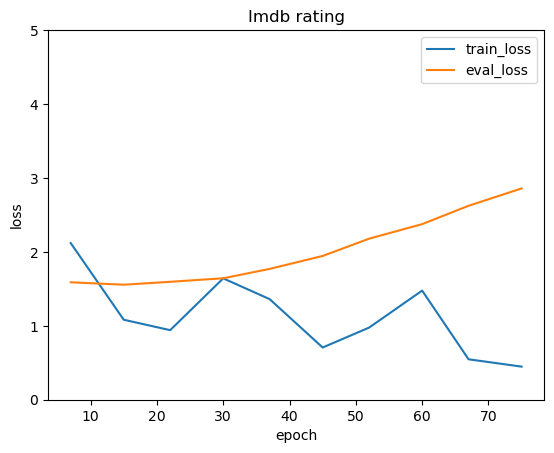

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

path = 'E:/TEST/outputs/bert-base-uncased-bs-44-ep-10-cls-model/training_progress_scores.csv'
df = pd.read_csv(path)

df = df[ df['global_step'] % 2000 != 0]
# df.insert(0, 'epoch', range(1, 1 + len(df)))
df['epoch'] = df.index + 1

print(df[ ['epoch',  'f1_score'] ])

plot = df.plot.line(x='epoch', y=['train_loss', 'eval_loss'])
plt.title('Imdb rating')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'eval_loss'], loc='upper right')
plt.ylim(0.0,5.0) 
plt.show()